# Chemical Resistance Prediction Analysis

This notebook generates all figures and tables for the paper on chemical resistance prediction using machine learning models.

## Contents
1. Setup and Imports
2. Data Loading
3. Exploratory Data Analysis
4. Figure 1 and Supplementary Figures S1-S2
5. Dataset Preparation
6. LOGOCV Cross-Validation
7. Resistance Prediction Model (Figure 3)
8. Chi Parameter Surrogate Model
9. Crystallinity Classification Model (Figure 4)
10. Virtual Polymer/Solvent Analysis (Figure 9)
11. Force Field Parameter Analysis (Figures 7-8)
12. Resistance Prediction Results (Figures 5-6)


## 1. Setup and Imports

### 1.1 Execution Configuration

In [1]:
# Execution Configuration
# Set these flags to control which analyses to run

TRAIN_RESISTANCE_MODEL = True   # Train resistance prediction model (GBDT) 
TRAIN_CHI_MODEL = True          # Train chi parameter prediction model (XGBoost)
TRAIN_CRYSTALLINITY_MODEL = True # Train crystallinity model (RandomForest)
N_JOBS = 35                      # Number of parallel jobs for computations

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Suppress joblib verbose output
import os
os.environ['JOBLIB_VERBOSITY'] = '0'

### 1.2 Standard Library Imports

In [2]:
from __future__ import annotations

import os
import sys
import json
import re
import math
from pathlib import Path
from datetime import datetime
from itertools import chain, combinations
from typing import TYPE_CHECKING, Any, Sequence, List, Optional, TypedDict

### 1.3 Scientific Computing Imports

In [3]:
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.transforms as mtransforms
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.transforms import blended_transform_factory
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
import seaborn as sns
import japanize_matplotlib  # Used for rendering Japanese characters

### 1.4 Machine Learning Imports

In [4]:
from sklearn.model_selection import KFold, LeaveOneGroupOut, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support,
    roc_curve, auc, r2_score, mean_absolute_error, mean_squared_error
)
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from joblib import dump, load, Parallel, delayed
import joblib
from minepy import MINE
from tqdm import tqdm

from rdkit import Chem
from rdkit.Chem import Draw

### 1.5 Local Utility Imports

In [5]:
# Add parent directory to path for utils imports (when running from src/)
import sys
from pathlib import Path

# For Jupyter notebooks running in src/ directory
_notebook_dir = Path('.').resolve()
if _notebook_dir.name == 'src':
    _repo_root = _notebook_dir.parent
else:
    _repo_root = _notebook_dir
sys.path.insert(0, str(_repo_root))

from utils.io import save_as_csv, save_as_csv_with_head
from utils.visualization import init_visualization

# Import utility modules
from utils.config import *
from utils import plotting
from utils import validation
from utils import train
from utils import data_preprocessing
from utils import metrics
from utils import mic

if TYPE_CHECKING:
    from matplotlib.axes import Axes
    from matplotlib.figure import Figure

---
## 2. Data Loading

Load preprocessed datasets for chemical resistance analysis.

In [6]:
print("Loading preprocessed datasets...")

# Load chemical resistance dataset
_cr_dataset = data_preprocessing.load_chemical_resistance_dataset()
valid_info_cluster = _cr_dataset.valid_info_cluster
valid_data_cluster = _cr_dataset.valid_data_cluster
feature_cols_dict = _cr_dataset.feature_cols_dict
polymer_name_dict = _cr_dataset.polymer_name_dict
solvent_name_dict = _cr_dataset.solvent_name_dict
radonpy_polymer_cols = _cr_dataset.radonpy_polymer_cols

# Unpack feature column lists
FF_solvent_cols = feature_cols_dict['FF_solvent_cols']
FF_polymer_cols = feature_cols_dict['FF_polymer_cols']
RDKit_solvent_cols = feature_cols_dict['RDKit_solvent_cols']
RDKit_polymer_cols = feature_cols_dict['RDKit_polymer_cols']
FF_solvent_wo_polars_cols = feature_cols_dict['FF_solvent_wo_polars_cols']

# Also unpack detailed FF parameter columns for later use
FF_mass_solvent_cols = feature_cols_dict['FF_mass_solvent_cols']
FF_charge_solvent_cols = feature_cols_dict['FF_charge_solvent_cols']
FF_epsilon_solvent_cols = feature_cols_dict['FF_epsilon_solvent_cols']
FF_sigma_solvent_cols = feature_cols_dict['FF_sigma_solvent_cols']
FF_k_bond_solvent_cols = feature_cols_dict['FF_k_bond_solvent_cols']
FF_r0_solvent_cols = feature_cols_dict['FF_r0_solvent_cols']
FF_polar_solvent_cols = feature_cols_dict['FF_polar_solvent_cols']
FF_k_angle_solvent_cols = feature_cols_dict['FF_k_angle_solvent_cols']
FF_theta0_solvent_cols = feature_cols_dict['FF_theta0_solvent_cols']
FF_k_dih_solvent_cols = feature_cols_dict['FF_k_dih_solvent_cols']

FF_mass_polymer_cols = feature_cols_dict['FF_mass_polymer_cols']
FF_charge_polymer_cols = feature_cols_dict['FF_charge_polymer_cols']
FF_epsilon_polymer_cols = feature_cols_dict['FF_epsilon_polymer_cols']
FF_sigma_polymer_cols = feature_cols_dict['FF_sigma_polymer_cols']
FF_k_bond_polymer_cols = feature_cols_dict['FF_k_bond_polymer_cols']
FF_r0_polymer_cols = feature_cols_dict['FF_r0_polymer_cols']
FF_polar_polymer_cols = feature_cols_dict['FF_polar_polymer_cols']
FF_k_angle_polymer_cols = feature_cols_dict['FF_k_angle_polymer_cols']
FF_theta0_polymer_cols = feature_cols_dict['FF_theta0_polymer_cols']
FF_k_dih_polymer_cols = feature_cols_dict['FF_k_dih_polymer_cols']

FF_mass_cols = feature_cols_dict['FF_mass_cols']
FF_charge_cols = feature_cols_dict['FF_charge_cols']
FF_epsilon_cols = feature_cols_dict['FF_epsilon_cols']
FF_sigma_cols = feature_cols_dict['FF_sigma_cols']
FF_k_bond_cols = feature_cols_dict['FF_k_bond_cols']
FF_r0_cols = feature_cols_dict['FF_r0_cols']
FF_polar_cols = feature_cols_dict['FF_polar_cols']
FF_k_angle_cols = feature_cols_dict['FF_k_angle_cols']
FF_theta0_cols = feature_cols_dict['FF_theta0_cols']
FF_k_dih_cols = feature_cols_dict['FF_k_dih_cols']

# Set valid_info and valid_data to point to cluster versions
valid_info = valid_info_cluster.copy()
valid_data = valid_data_cluster.copy()

print(f"✓ Preprocessed data loaded: {len(valid_info_cluster)} records")

Loading preprocessed datasets...
Loading from unified metadata (chemical_resistance_metadata.json)...
✓ Loaded chemical_resistance_metadata.json
Loading unified dataset (chemical_resistance_dataset.csv)...
✓ Loaded chemical_resistance_dataset.csv: 2231 rows
✓ Split into info (68 cols) and data (648 cols)
✓ Loaded all files from: /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/data
✓ Preprocessed data loaded: 2231 records


### 2.1 Initialize Visualization Settings

In [7]:
# Initialize visualization settings
from utils.visualization import init_visualization
init_visualization()
plotting.set_paper_style()

### 2.2 Create Merged DataFrame for Clustering Visualization

In [8]:
# Create df_merged for clustering visualization (needed later)
df_info = valid_info.copy()
df_feats = valid_data.copy()
df_info = df_info[~df_info.index.duplicated(keep='first')]
df_feats = df_feats[~df_feats.index.duplicated(keep='first')]
df_merged = pd.merge(df_info, df_feats, how="inner", left_index=True, right_index=True)

# Calculate solvent clusters for visualization
percentage_df = (df_merged
                 .groupby('solvent')['resistance_binary']
                 .apply(plotting.calculate_percentage)
                 .unstack()
                 .reset_index()
                )
percentage_df.fillna(0, inplace=True)
merged_df = df_merged.merge(percentage_df, on='solvent', how='left')
columns_rename = {'A': 'A_original', 0: 'resistance_0_(%)', 1: 'resistance_1_(%)'}
merged_df.rename(columns=columns_rename, inplace=True)
df_solv = merged_df.drop_duplicates(subset="solvent").reset_index(drop=True)
df_solv_cluster = df_solv.copy()
df_solv_cluster.sort_values("resistance_0_(%)", ascending=True, inplace=True)
df_solv_cluster.reset_index(drop=True, inplace=True)
df_solv_cluster['rank'] = df_solv_cluster['resistance_0_(%)'].rank(method='min')
clusters = np.array_split(df_solv_cluster, 10)
for i, cluster in enumerate(clusters):
    df_solv_cluster.loc[cluster.index, 'cluster_labels'] = i+1
df_solv_cluster['cluster_labels'] = df_solv_cluster['cluster_labels'].astype(int)
average_df = df_solv_cluster.groupby('cluster_labels')[['resistance_0_(%)', 'resistance_1_(%)']].mean()
average_df.reset_index(inplace=True)

# Note: Solvent renaming data is now included in the metadata JSON loaded by data_preprocessing

### 2.3 Load Additional Datasets

In [9]:
# Try to load polymer_mpk and pe_solvent datasets if available
try:
    _df_polymer_mpk = data_preprocessing.load_polymer_mpk_dataset()
    _df_pe_solvent = data_preprocessing.load_pe_solvent_dataset()
    _POLYMER_MPK_LOADED = True
    _PE_SOLVENT_LOADED = True
    print(f"✓ polymer_mpk_dataset loaded: {len(_df_polymer_mpk)} records")
    print(f"✓ pe_solvent_dataset loaded: {len(_df_pe_solvent)} records")
except FileNotFoundError:
    _POLYMER_MPK_LOADED = False
    _PE_SOLVENT_LOADED = False
    print("Note: polymer_mpk and pe_solvent datasets not found in processed dir.")
    print("      These will be loaded from original files.")

✓ Loaded polymer_mpk_dataset.csv: 40971 rows
✓ Loaded pe_solvent_dataset.csv: 9828 rows
✓ polymer_mpk_dataset loaded: 40971 records
✓ pe_solvent_dataset loaded: 9828 records


---
## 3. Exploratory Data Analysis

### 3.1 Binary Resistance Distribution Overview

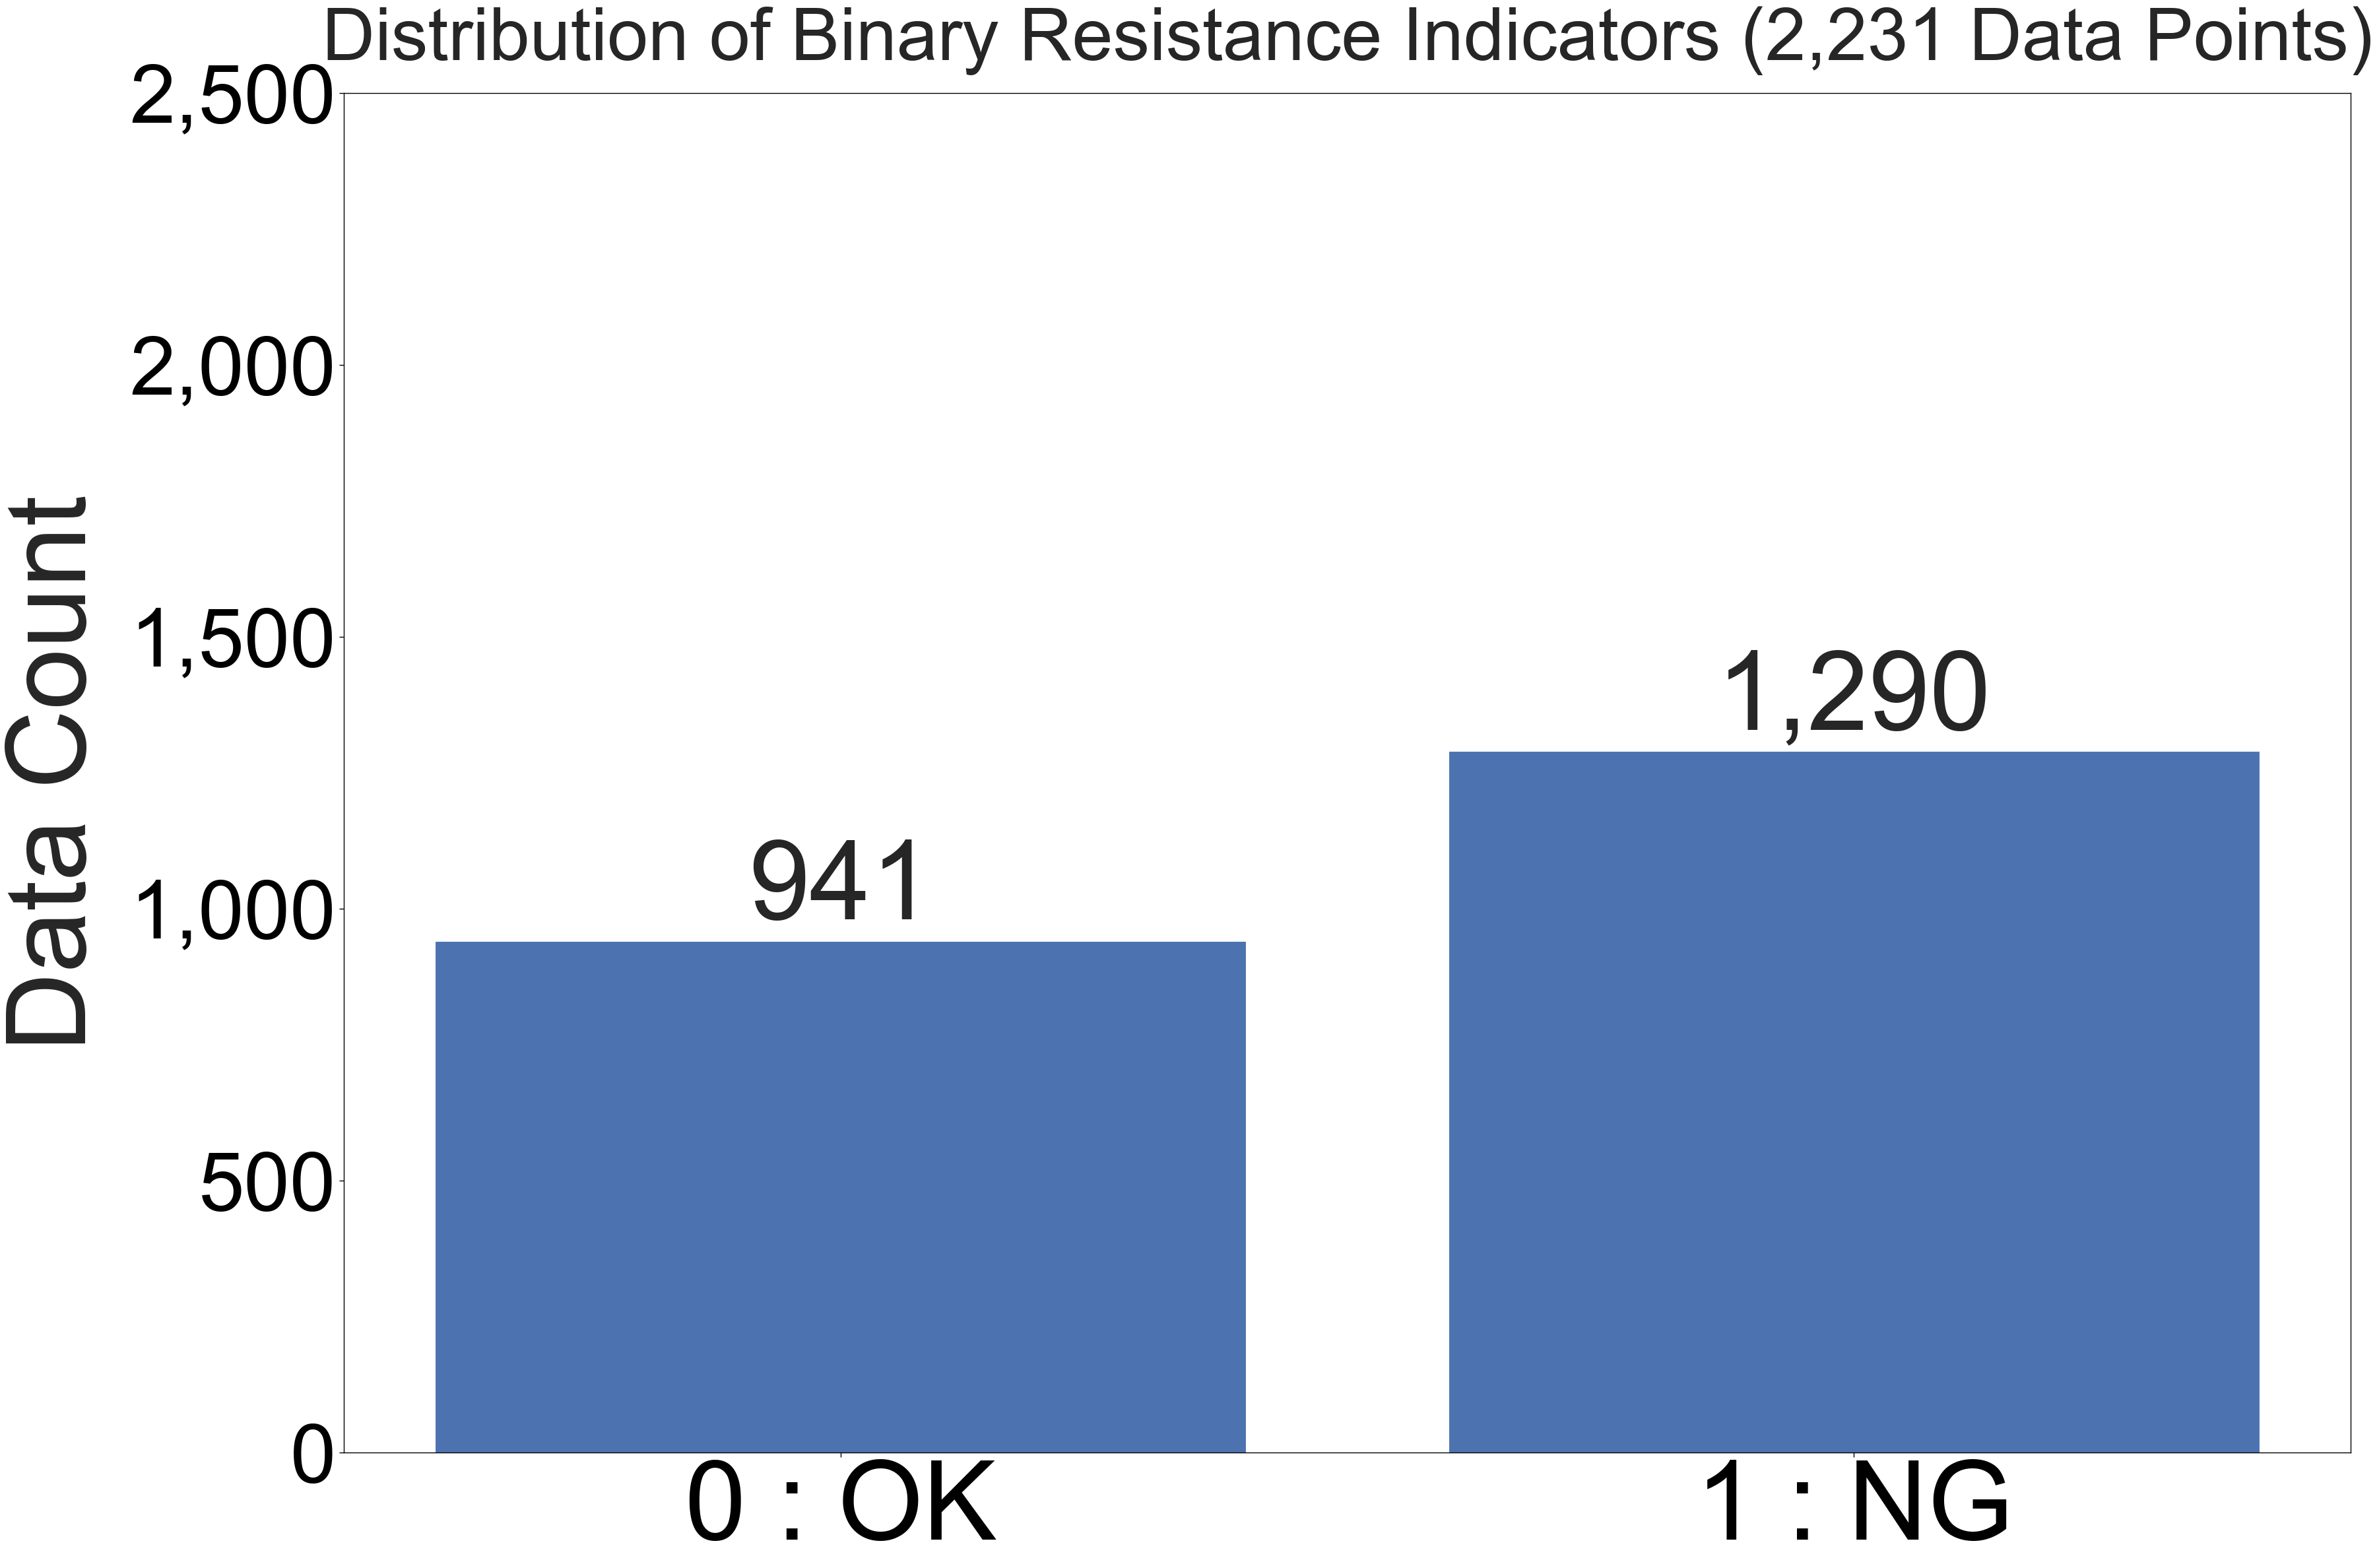

In [10]:
# Count the binary resistance indicator values
resistance_counts = valid_info_cluster['resistance_binary'].value_counts()

# Rename the index labels: map 0 to "OK" and 1 to "NG"
resistance_labels = {0: 'OK', 1: 'NG'}
resistance_counts = resistance_counts.rename(index=resistance_labels)

# Specify the order for the bar chart (OK first, then NG)
resistance_order = ['OK', 'NG']

fig, ax = plt.subplots(figsize=(36, 24))

# Draw the bar chart
bars = ax.bar(resistance_order, [resistance_counts.get(label, 0) for label in resistance_order])

# Format the y-axis with commas and set labels and title
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel('Data Count', fontsize=120, labelpad=24)
# Set the font size for y-axis tick labels
ax.tick_params(axis='y', labelsize=90)
ax.set_ylim(0, 2500)
plt.title(f'Distribution of Binary Resistance Indicators ({resistance_counts.sum():,} Data Points)', fontsize=80, y=1.02)

# Set custom x-axis tick labels with corresponding codes
ax.set_xticklabels(['0 : OK', '1 : NG'], fontsize=120)

# Add numerical labels above each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:,}', ha='center', va='bottom', fontsize=120)

plt.tight_layout()
plt.show()

### 3.2 Resistance Distribution by Polymer

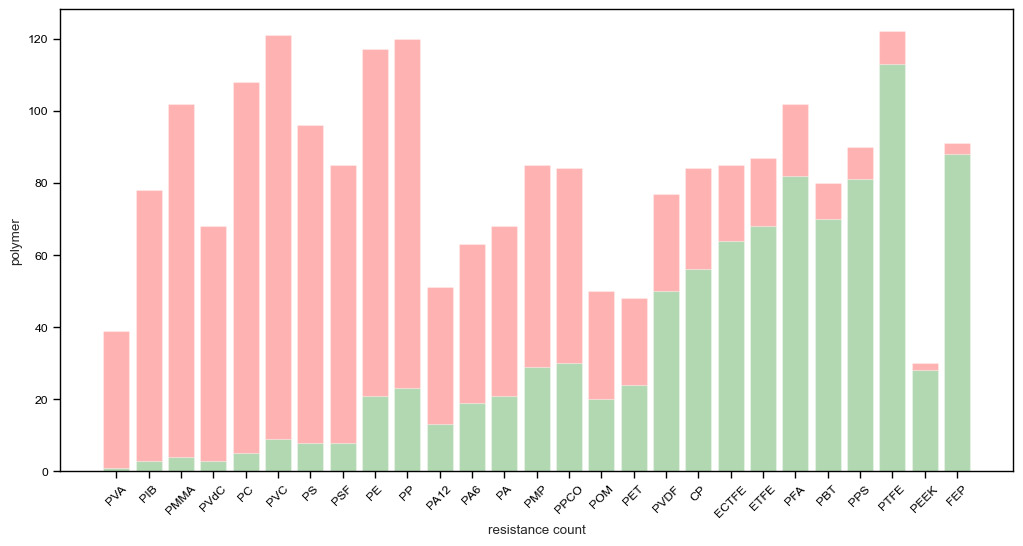

In [11]:
# Resistance data count distribution by polymer (binary classification)
fig, ax, _, _ = plotting._plot_resistance_binary_dists(valid_info_cluster, polymer_name_dict, "smiles_polymer", is_reverse=True, is_rotate=True)
ax.set(xlabel="resistance count", ylabel="polymer")
plt.show()

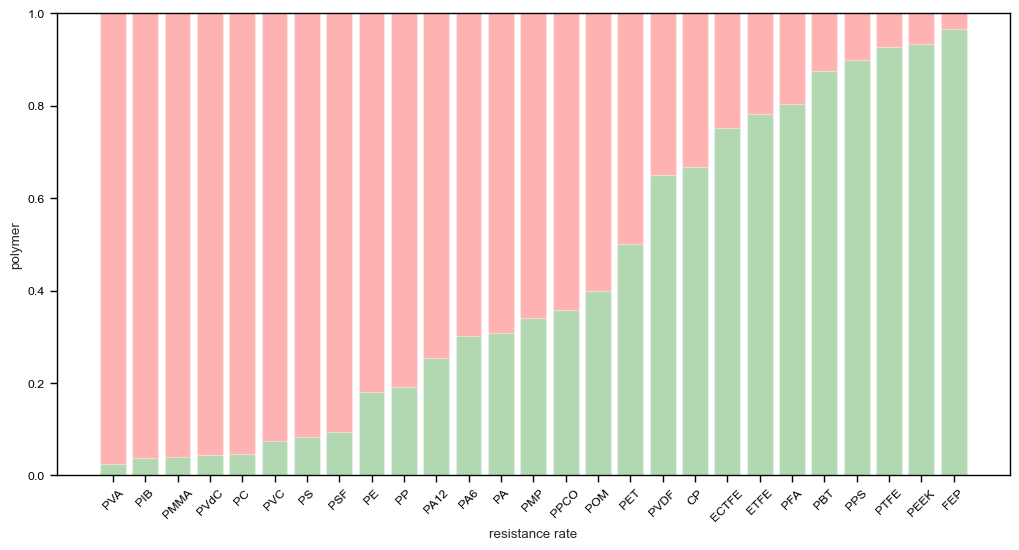

In [12]:
# Resistance data rate distribution by polymer (binary classification)
fig, ax, polymer_resistance_rank, _ = plotting._plot_resistance_binary_dists(valid_info_cluster, polymer_name_dict, "smiles_polymer", is_rate=True, is_reverse=True, is_rotate=True)
ax.set(xlabel="resistance rate", ylabel="polymer")
plt.show()

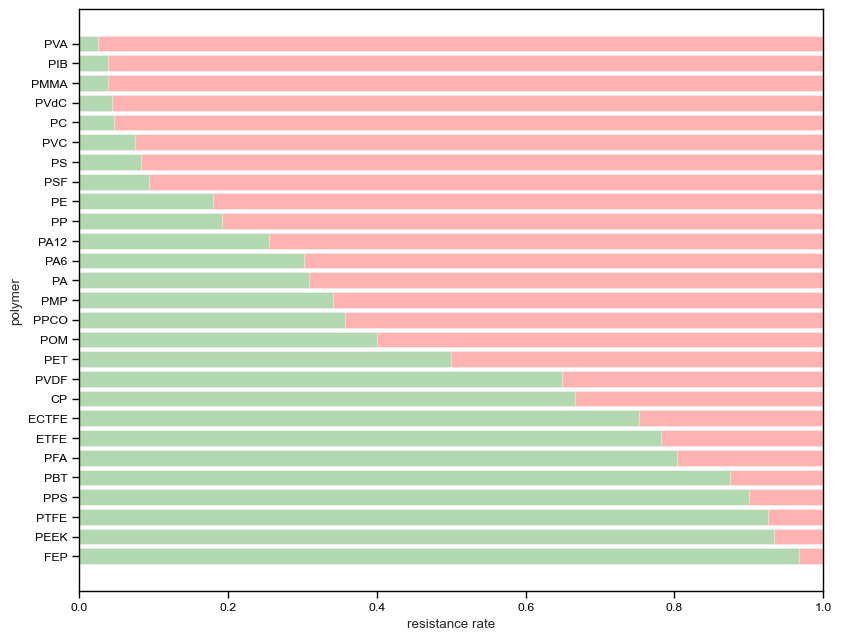

In [13]:
# Resistance data rate distribution by polymer (binary classification) - horizontal
fig, ax, polymer_resistance_rank, _ = plotting._plot_resistance_binary_dists(valid_info_cluster, polymer_name_dict, "smiles_polymer", is_rate=True, is_reverse=True)
ax.set(xlabel="resistance rate", ylabel="polymer")
plt.show()

### 3.3 Resistance Distribution by Solvent

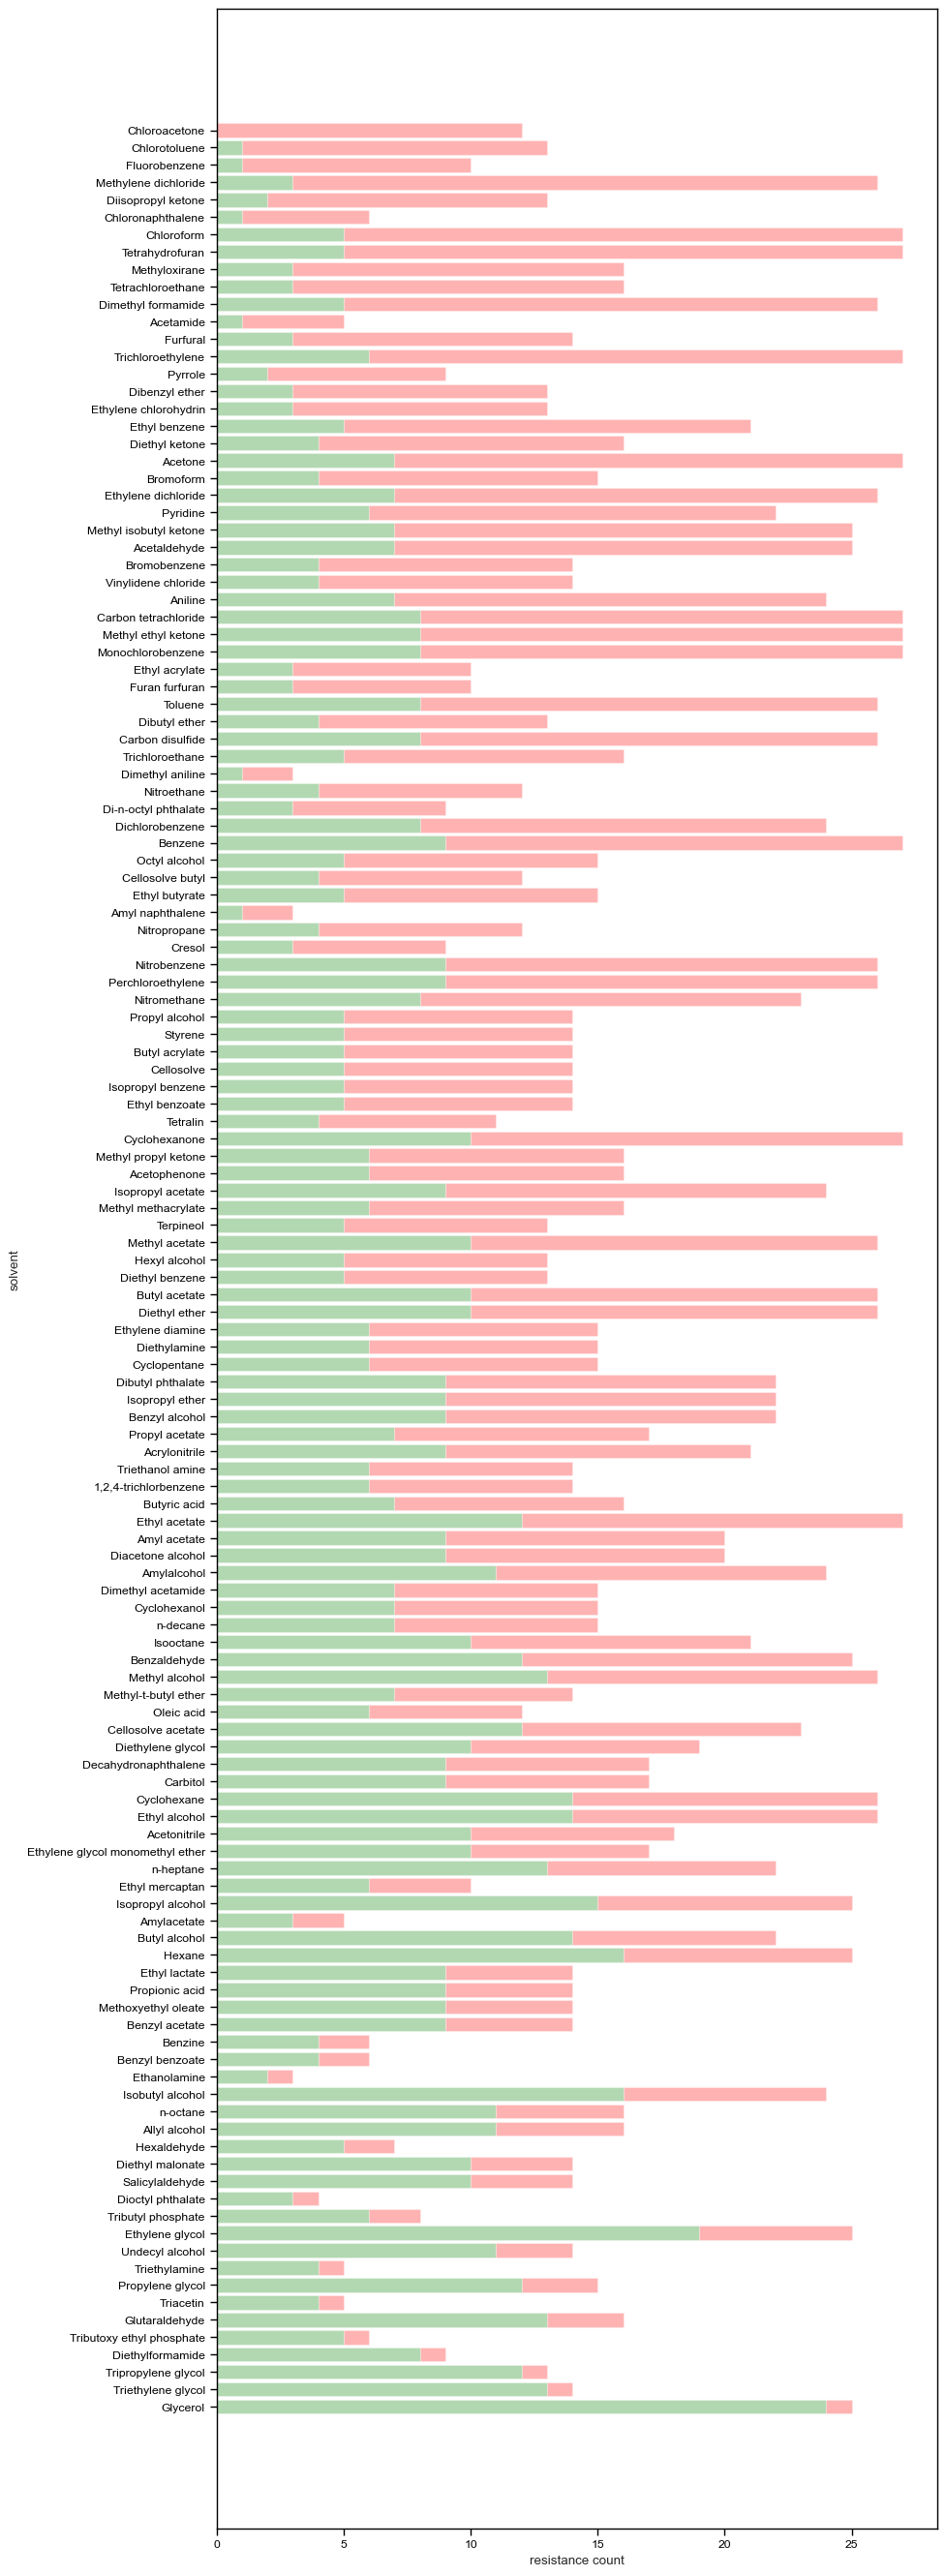

In [14]:
# Resistance data count distribution by solvent (binary classification)
fig, ax, _, _ = plotting._plot_resistance_binary_dists(valid_info_cluster, solvent_name_dict, "smiles_solvent", is_reverse=True)
ax.set(xlabel="resistance count", ylabel="solvent")
plt.show()

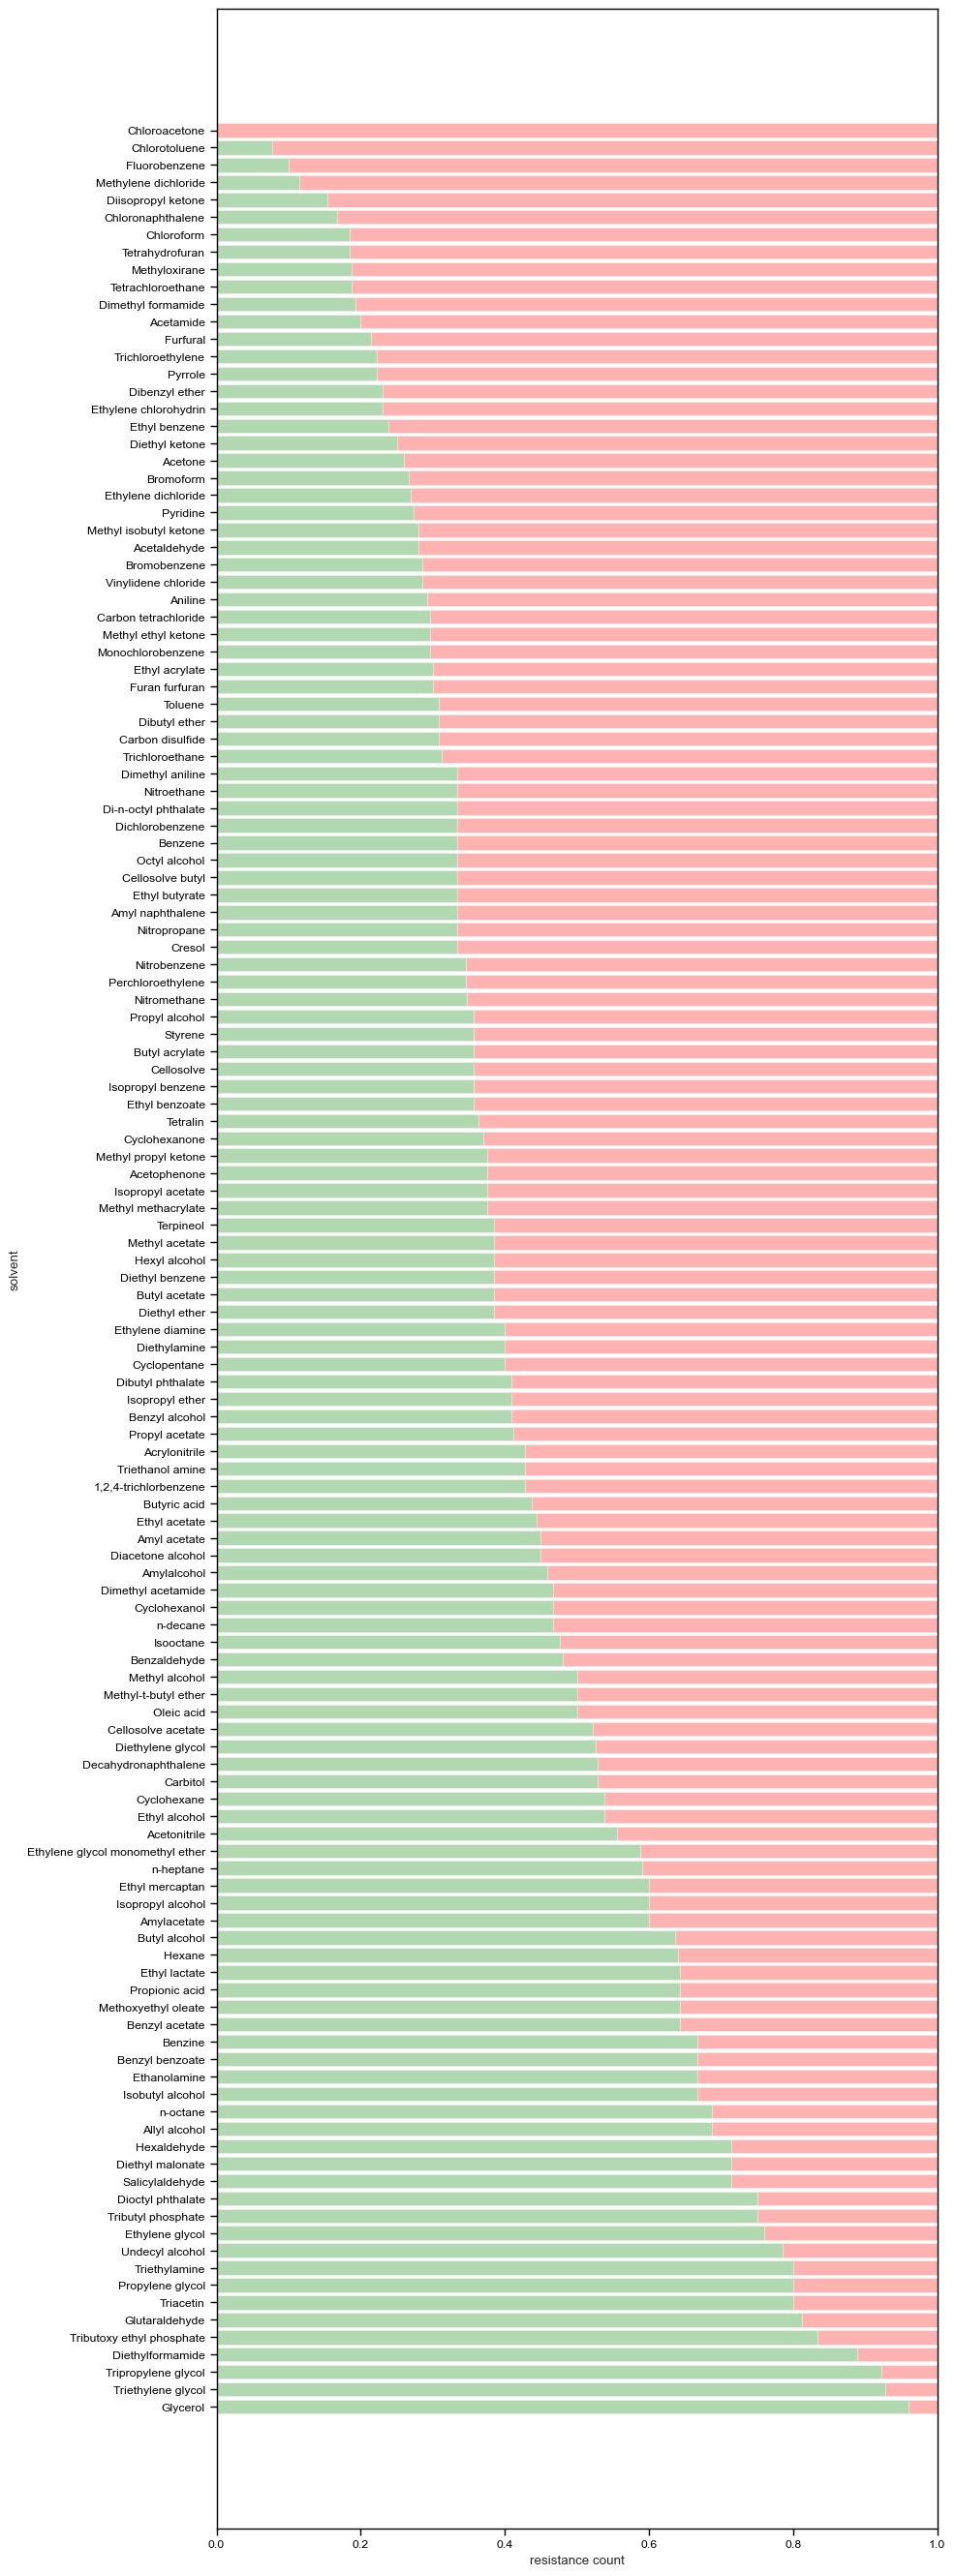

In [15]:
# Resistance data rate distribution by solvent (binary classification)
fig, ax, solvent_rank, _ = plotting._plot_resistance_binary_dists(valid_info_cluster, solvent_name_dict, "smiles_solvent", is_rate=True, is_reverse=True)
ax.set(xlabel="resistance count", ylabel="solvent")
plt.show()

### 3.4 Resistance Distribution by Solvent Cluster

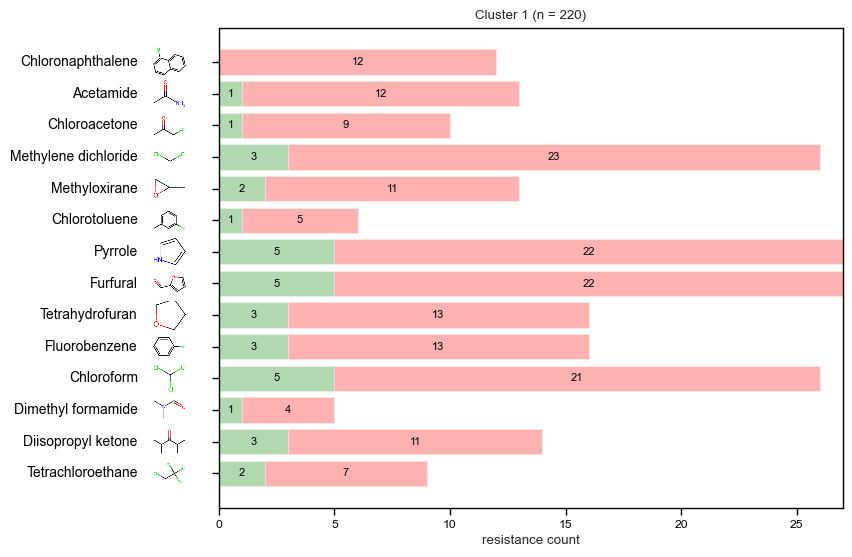

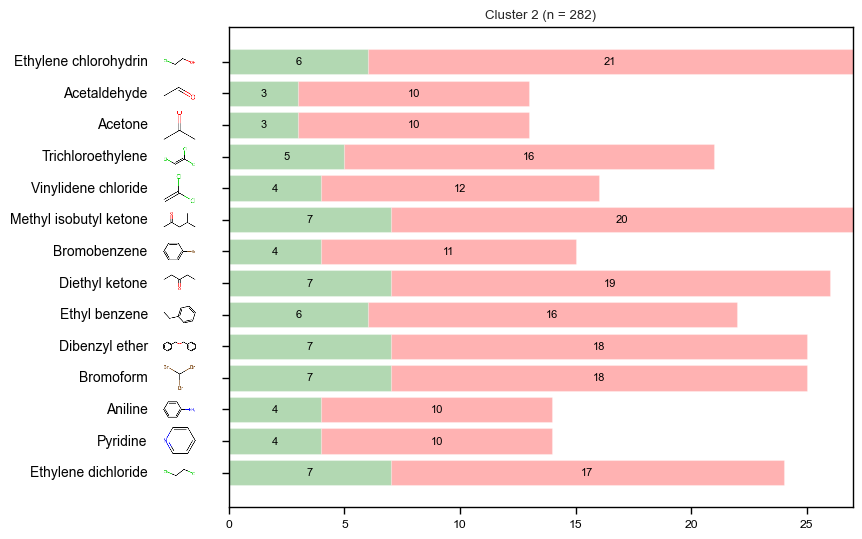

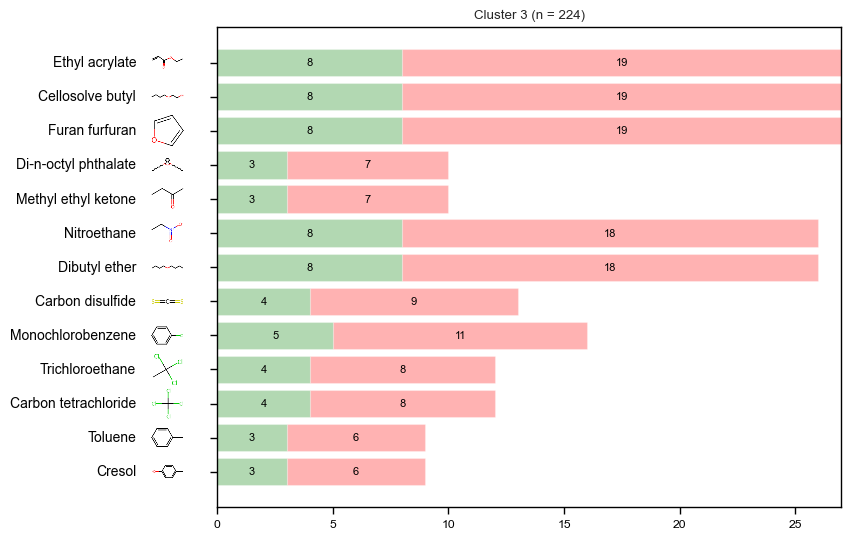

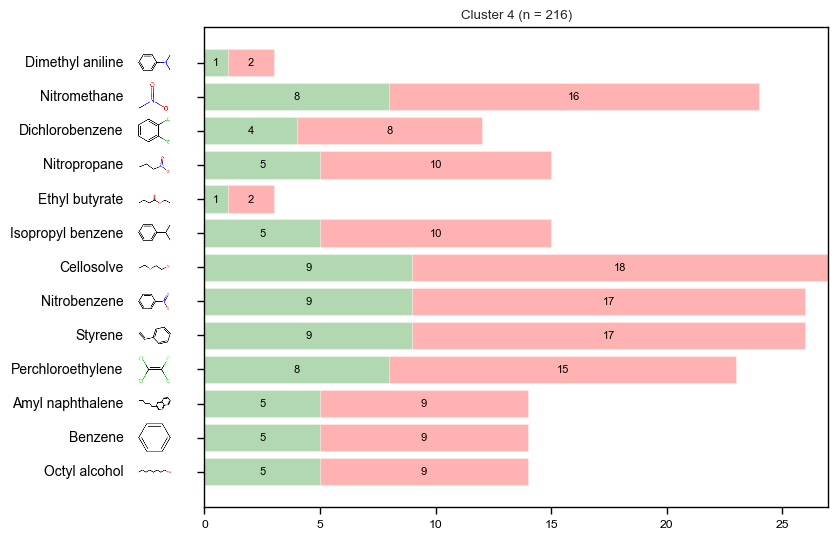

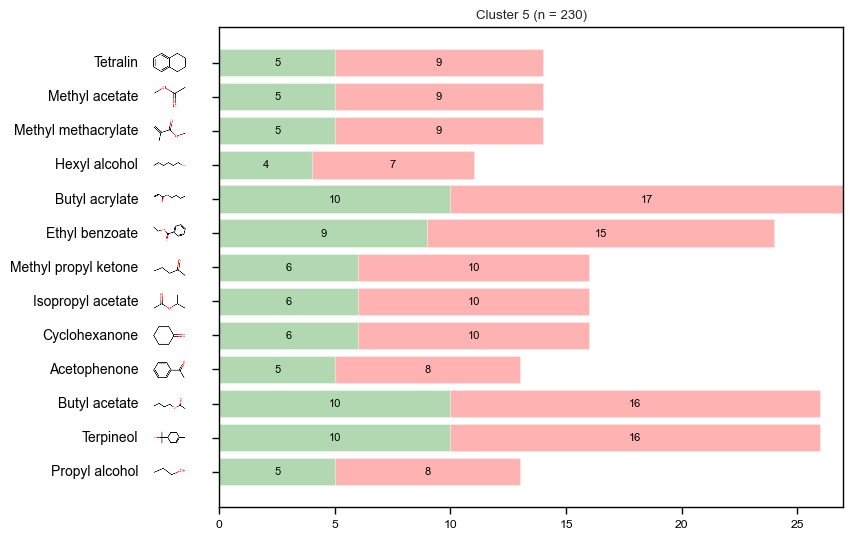

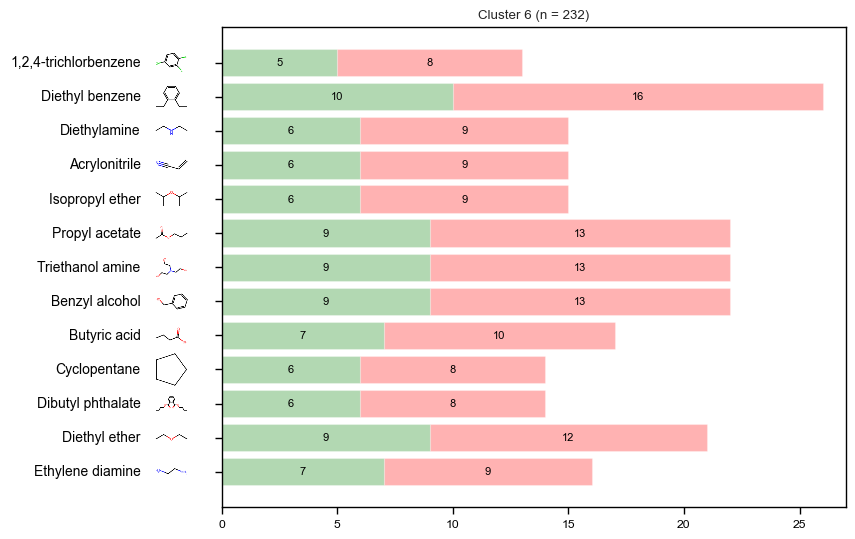

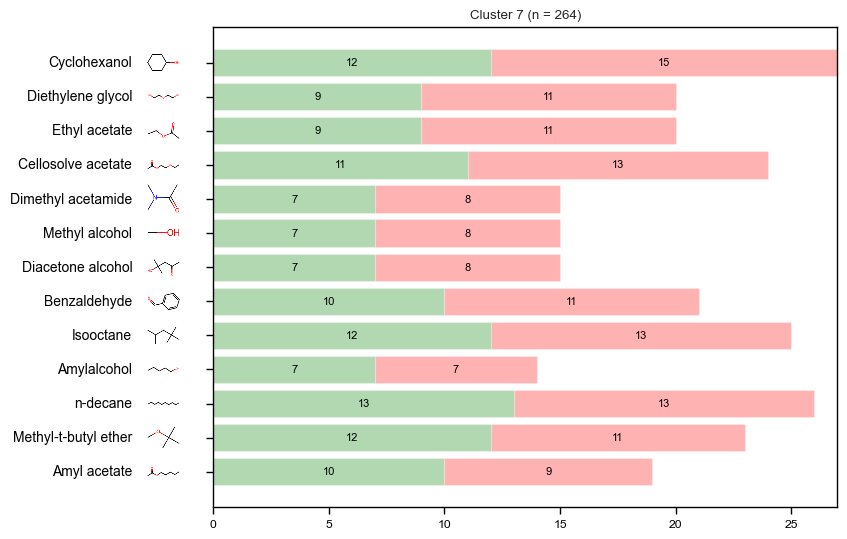

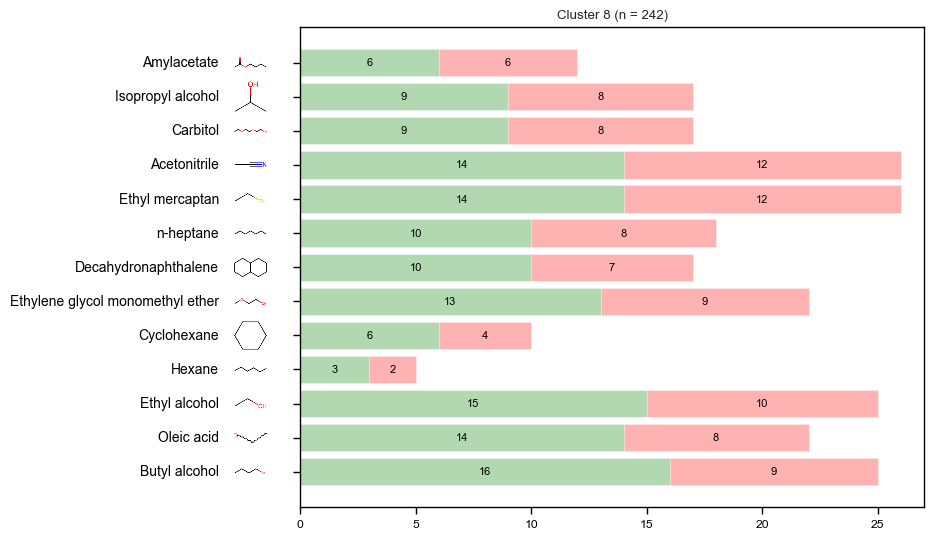

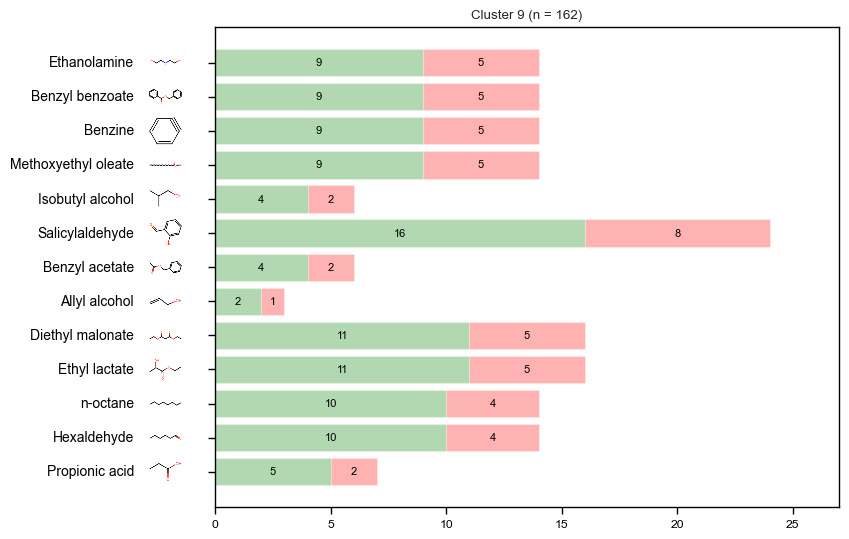

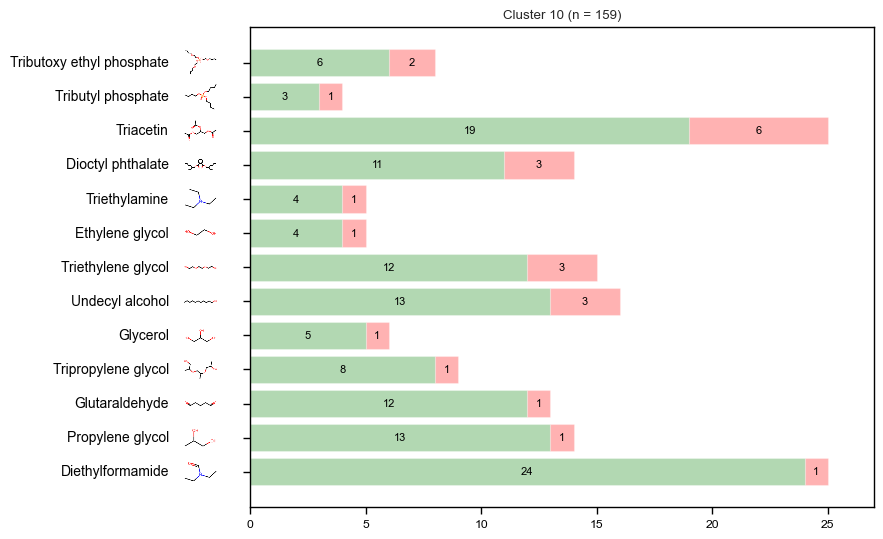

In [16]:
# Output per solvent cluster - Count
results_count = plotting.plot_resistance_by_cluster_fixed(
    valid_info_cluster,
    solvent_name_dict,
    "smiles_solvent",
    cluster_col="cluster_labels",
    is_rate=False,
    is_reverse=True,
    with_structures=True,
    image_zoom=0.25,
    label_x=-0.13,
    image_x_offset=0.05
)

for cluster, (fig, ax) in results_count.items():
    ax.set(xlabel="resistance count", ylabel="")
    fig.tight_layout()
    plt.show()

### 3.5 Detailed Cluster Visualization

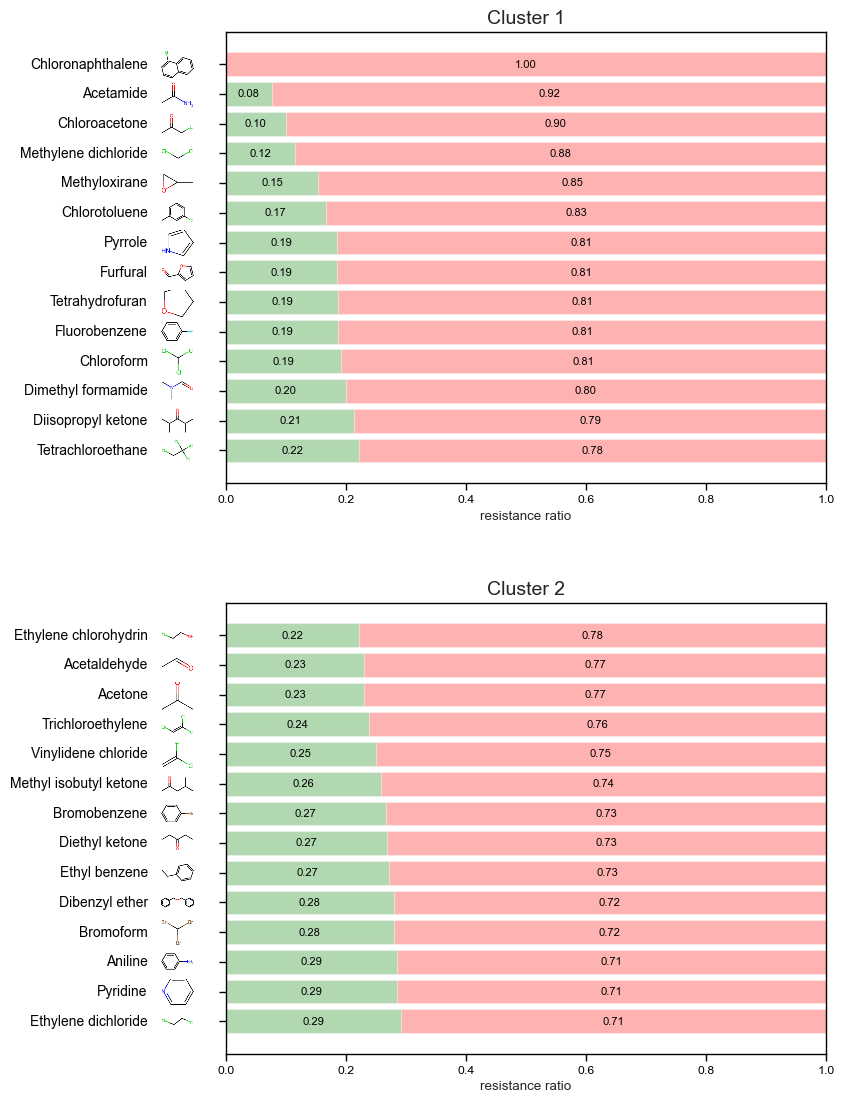

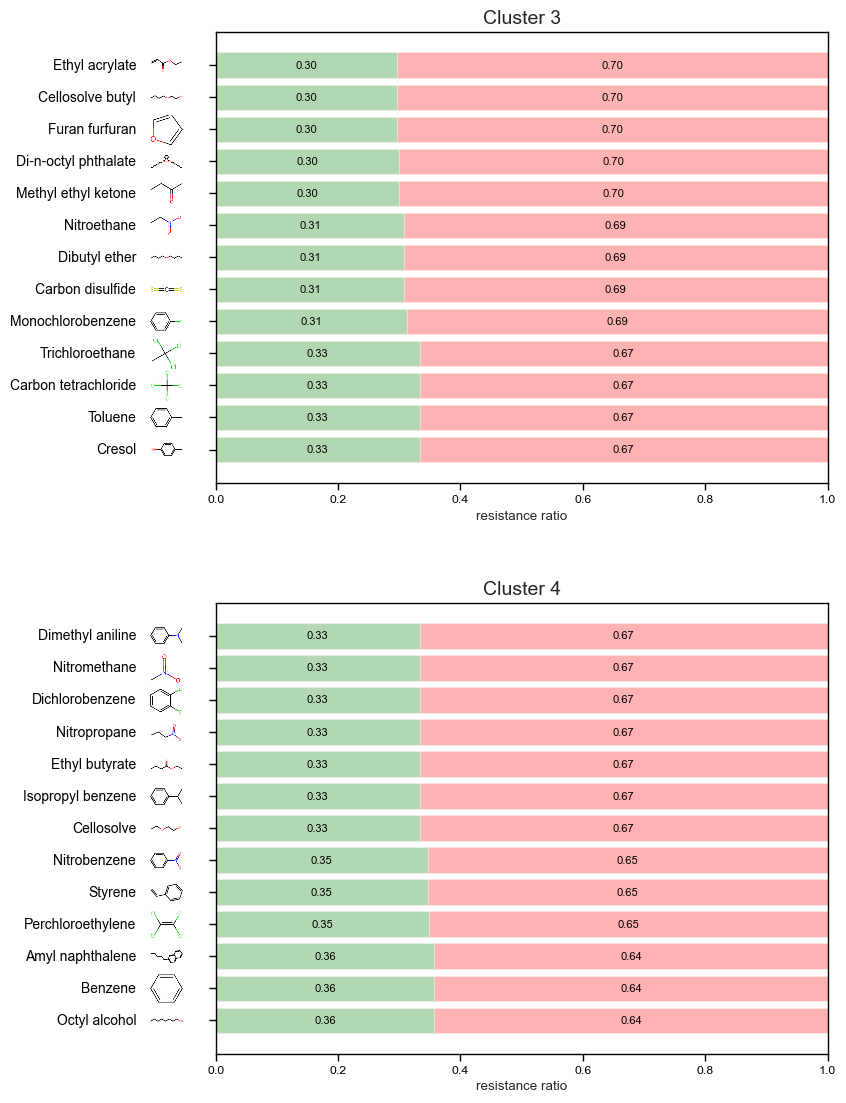

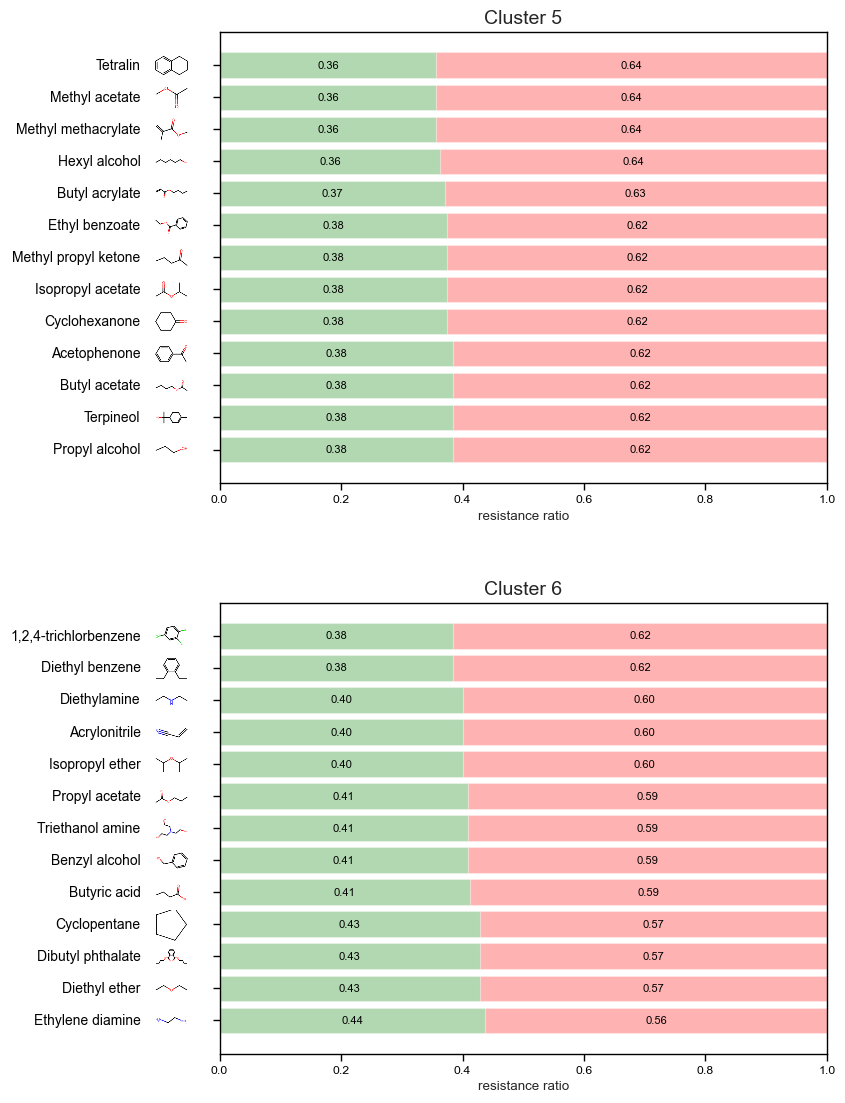

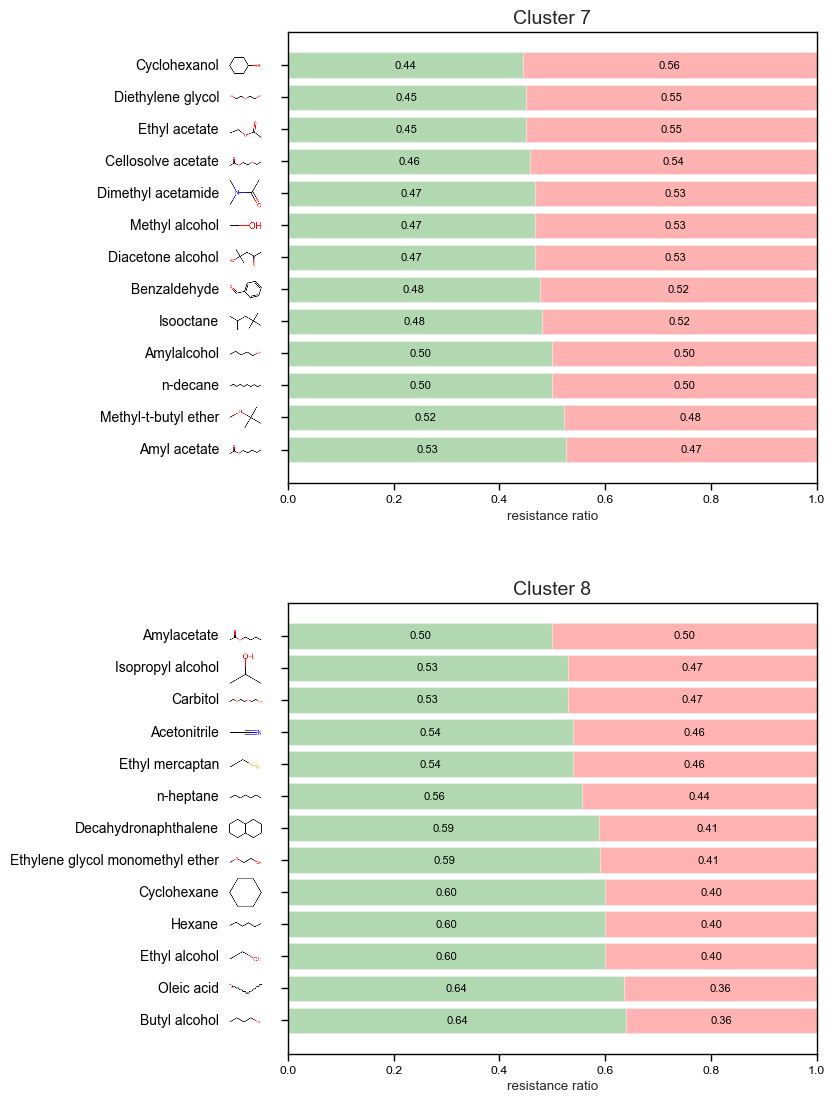

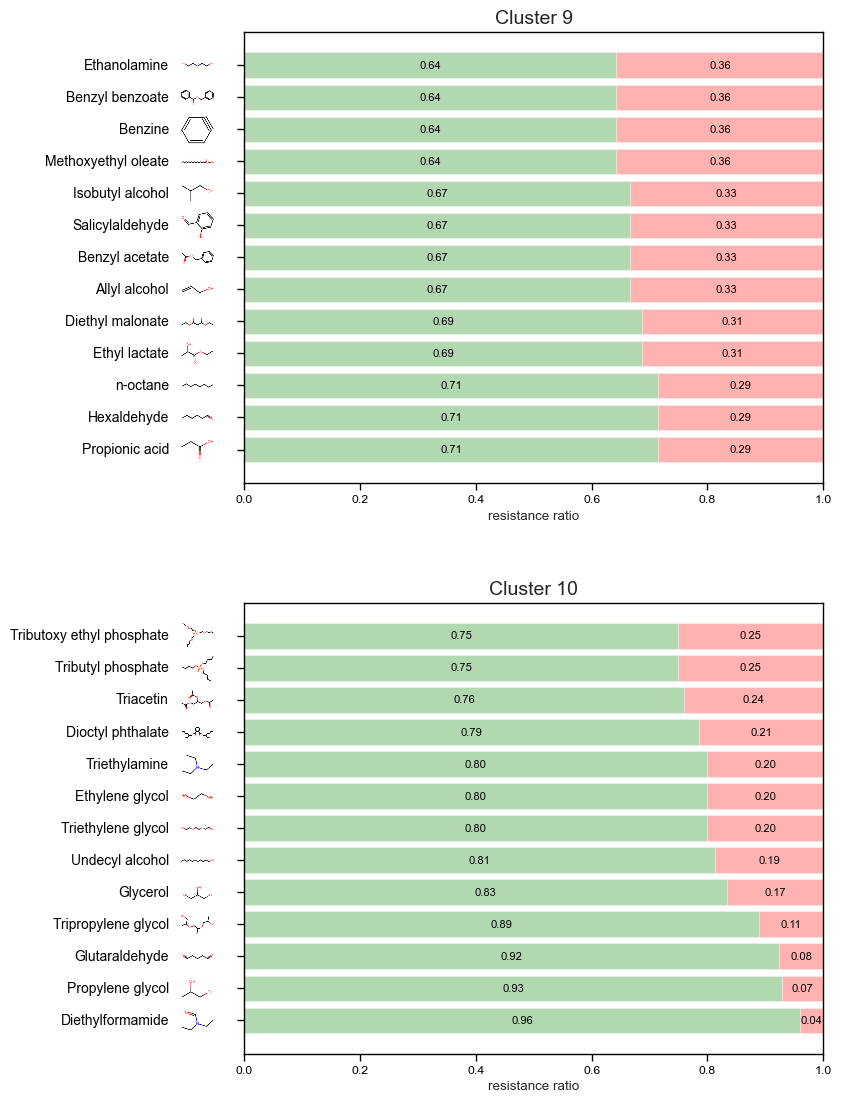

In [17]:
# Set overall default font size
base_fontsize = 14
plt.rcParams.update({'font.size': base_fontsize})

cluster_col = "cluster_labels"
key_col = "smiles_solvent"

# Mode settings
is_rate = True  
is_reverse = True
is_rotate = False
with_structures = True

# List of all clusters
clusters = sorted(valid_info_cluster[cluster_col].unique())
n_clusters = len(clusters)

# Get 2 per group to summarize as 2 rows 1 column subplots
grouped_clusters = [clusters[i:i+2] for i in range(0, n_clusters, 2)]

# Draw as one image file for each group
for group in grouped_clusters:
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9.6, 12))
    
    if len(group) == 1:
        axs = [axs]
    
    for ax, cluster in zip(axs, group):
        cluster_data = valid_info_cluster[valid_info_cluster[cluster_col] == cluster]
        
        ticklabels, keys = plotting._plot_resistance_binary_dists_fixed(
            cluster_data,
            solvent_name_dict,
            key_col,
            ax,
            sort_key=[0],
            is_rate=is_rate,
            is_reverse=is_reverse,
            is_rotate=is_rotate,
        )
        
        if not is_rate:
            cluster_count = cluster_data.shape[0]
            ax.set_title(f"Cluster {cluster} (n = {cluster_count})", fontsize=base_fontsize)
        else:
            ax.set_title(f"Cluster {cluster}", fontsize=base_fontsize)
        
        if is_rate:
            ax.set(xlabel="resistance ratio", ylabel="")
            if is_rotate:
                ax.set_ylim(0, 1)
            else:
                ax.set_xlim(0, 1)
        else:
            ax.set(xlabel="resistance count", ylabel="")
        
        if with_structures:
            plotting.add_structure_images(
                ax,
                keys,
                solvent_name_dict,
                plotting.get_rdkit_image,
                image_zoom=0.25,
                label_x=-0.13,
                image_x_offset=0.05,
                image_y_offset=0.0
            )
    
    fig.tight_layout(pad=3.0)
    plt.show()

---
## 4. Figure 1 and Supplementary Figures S1-S2

### 4.1 Supplementary Figure S1: Resistance Binary Distribution by Polymer

Saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S1_resistance_binary_rates_in_resin_no_cluster_rate.svg
Saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S1_resistance_binary_rates_in_resin_no_cluster_rate.jpg
Saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S1_resistance_binary_rates_in_resin_no_cluster_count.svg
Saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S1_resistance_binary_rates_in_resin_no_cluster_count.jpg
Supplementary Figure S1 (rate and count versions) saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub


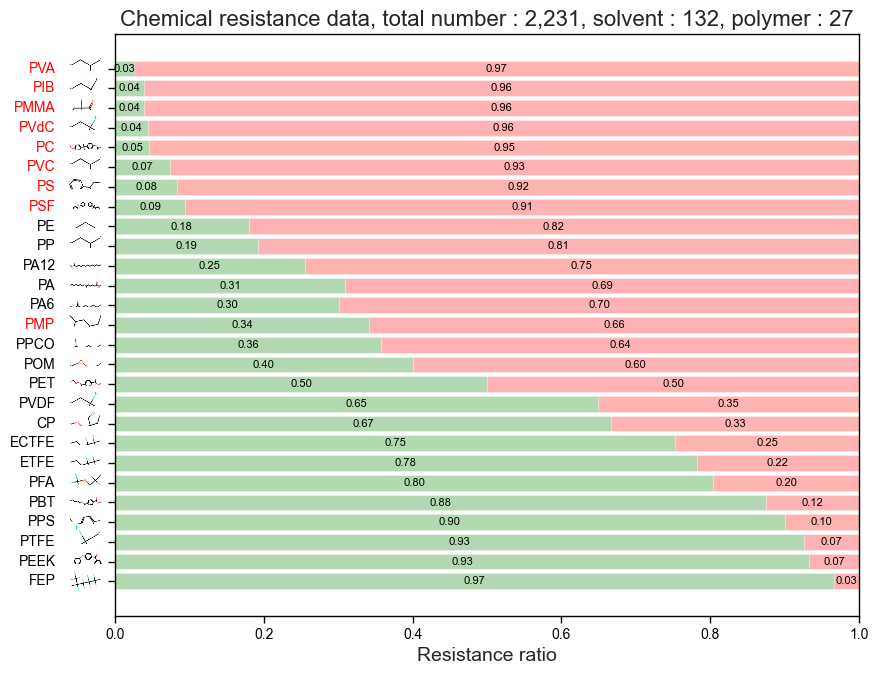

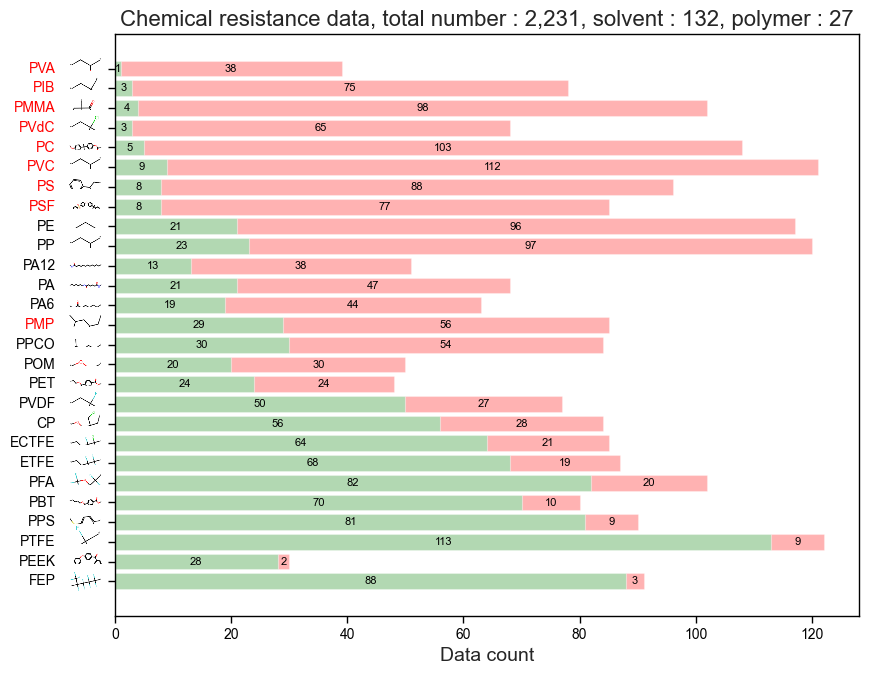

In [18]:
# Global Settings
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

# Use constants from config for non-crystalline polymers and symbol order
fig_s1_rate, fig_s1_count = plotting.generate_supplementary_s1_resistance_by_polymer(
    valid_info_cluster=valid_info_cluster,
    polymer_name_dict=polymer_name_dict,
    special_labels=NON_CRYSTALLINE_POLYMERS,
    symbol_order=SYMBOL_ORDER_S1,
    save_dir=REPORT_DIR_SUB,
    image_zoom=0.25
)
plt.show()

### 4.2 Solvent Cluster Analysis

In [19]:
# Calculate average indicator ratio for solvent clusters
average_df = df_solv_cluster.groupby('cluster_labels')[['resistance_0_(%)', 'resistance_1_(%)']].mean()
average_df.reset_index(inplace=True)
average_df

cluster_labels  resistance_0_(%)  resistance_1_(%)
0               1         15.621475         84.378525
1               2         26.163108         73.836892
2               3         31.213840         68.786160
3               4         34.191505         65.808495
4               5         37.260745         62.739255
5               6         41.011404         58.988596
6               7         47.543903         52.456097
7               8         57.485584         42.514416
8               9         67.353480         32.646520
9              10         83.016037         16.983963

In [20]:
# Convert solvent_rank index to dictionary
solvent_to_rank = {solvent: idx for idx, solvent in enumerate(solvent_rank)}

# Get rank corresponding to solvent column and add as new column
valid_info_cluster['solvent_rank'] = valid_info_cluster['solvent'].map(solvent_to_rank)

# Extract symbols and create the polymer_to_rank dictionary
polymer_to_rank = {polymer: idx for idx, polymer in enumerate(polymer_resistance_rank)}

# Get rank corresponding to symbol column and add as new column
valid_info_cluster['polymer_rank'] = valid_info_cluster['symbol'].map(polymer_to_rank)

# Check results
valid_info_cluster.head()

solvent symbol smiles_solvent smiles_polymer  \
temp_index                                                             
0           Ethylene dichloride     PE         ClCCCl            *C*   
1              Ethylene diamine     PE           NCCN            *C*   
2                 Diethyl ether     PE          CCOCC            *C*   
3              Diethylformamide     PE     CCN(C=O)CC            *C*   
4                  Amyl acetate     PE   CCCCCOC(C)=O            *C*   

            name_polymer repeating_unit  resistance_binary  \
temp_index                                                   
0           Polyethylene            *C*                  1   
1           Polyethylene            *C*                  1   
2           Polyethylene            *C*                  1   
3           Polyethylene            *C*                  0   
4           Polyethylene            *C*                  1   

            crystalinity_binary  n_mol_radonpy_polymer  \
temp_index                                               
0                           1.0                   10.0   
1                           1.0                   10.0   
2                           1.0                   10.0   
3                           1.0                   10.0   
4                           1.0                   10.0   

            qm_polarizability_xy_monomer1_radonpy_polymer  ...  \
temp_index                                                 ...   
0                                                0.028186  ...   
1                                                0.028186  ...   
2                                                0.028186  ...   
3                                                0.028186  ...   
4                                                0.028186  ...   

            qm_polarizability_yy_monomer1_radonpy_polymer  \
temp_index                                                  
0                                                3.854861   
1                                                3.854861   
2                                                3.854861   
3                                                3.854861   
4                                                3.854861   

            TC_pe_radonpy_polymer  TC_ke_radonpy_polymer  \
temp_index                                                 
0                         0.72421               2.104648   
1                         0.72421               2.104648   
2                         0.72421               2.104648   
3                         0.72421               2.104648   
4                         0.72421               2.104648   

            bulk_modulus_radonpy_polymer  tg_rmse_radonpy_polymer  \
temp_index                                                          
0                           2.833784e+09                  0.01324   
1                           2.833784e+09                  0.01324   
2                           2.833784e+09                  0.01324   
3                           2.833784e+09                  0.01324   
4                           2.833784e+09                  0.01324   

            TC_angle_radonpy_polymer  Scaled_Rg_radonpy_polymer  \
temp_index                                                        
0                           0.006448                   0.179129   
1                           0.006448                   0.179129   
2                           0.006448                   0.179129   
3                           0.006448                   0.179129   
4                           0.006448                   0.179129   

            cluster_labels  solvent_rank  polymer_rank  
temp_index                                              
0                        2            21             8  
1                        6            69             8  
2                        6            68             8  
3                       10           128             8  
4                        7            81             8  

[5 rows x 7

### 4.3 Figure 1: Chemical Resistance Heatmap (Main Figure)

Figure 1 saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Main/fig1.pdf and /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Main/fig1.svg


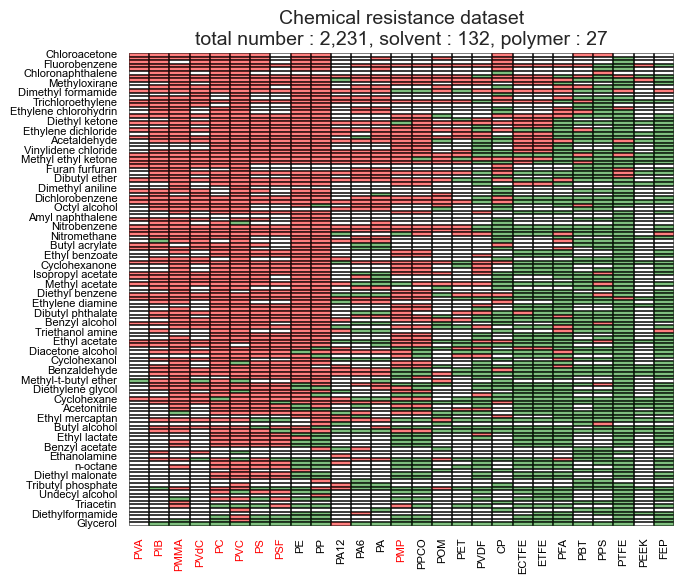

In [21]:
# Generate Figure 1: Chemical Resistance Heatmap
df_sorted = valid_info_cluster.sort_values(['solvent_rank', 'polymer_rank'])
fig1 = plotting.generate_figure1_heatmap(valid_info_cluster, save_dir=REPORT_DIR_MAIN)
plt.show()

### 4.4 Supplementary Figure S2: Cluster Heatmaps

Saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S2_resistance_matrix_clusters_1_2_file1.jpg
Saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S2_resistance_matrix_clusters_1_2_file1.svg
Saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S2_resistance_matrix_clusters_3_4_file2.jpg
Saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S2_resistance_matrix_clusters_3_4_file2.svg
Saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S2_resistance_matrix_clusters_5_6_file3.jpg
Saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S2_resistance_matrix_clusters_5_6_file3.svg
Saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_p

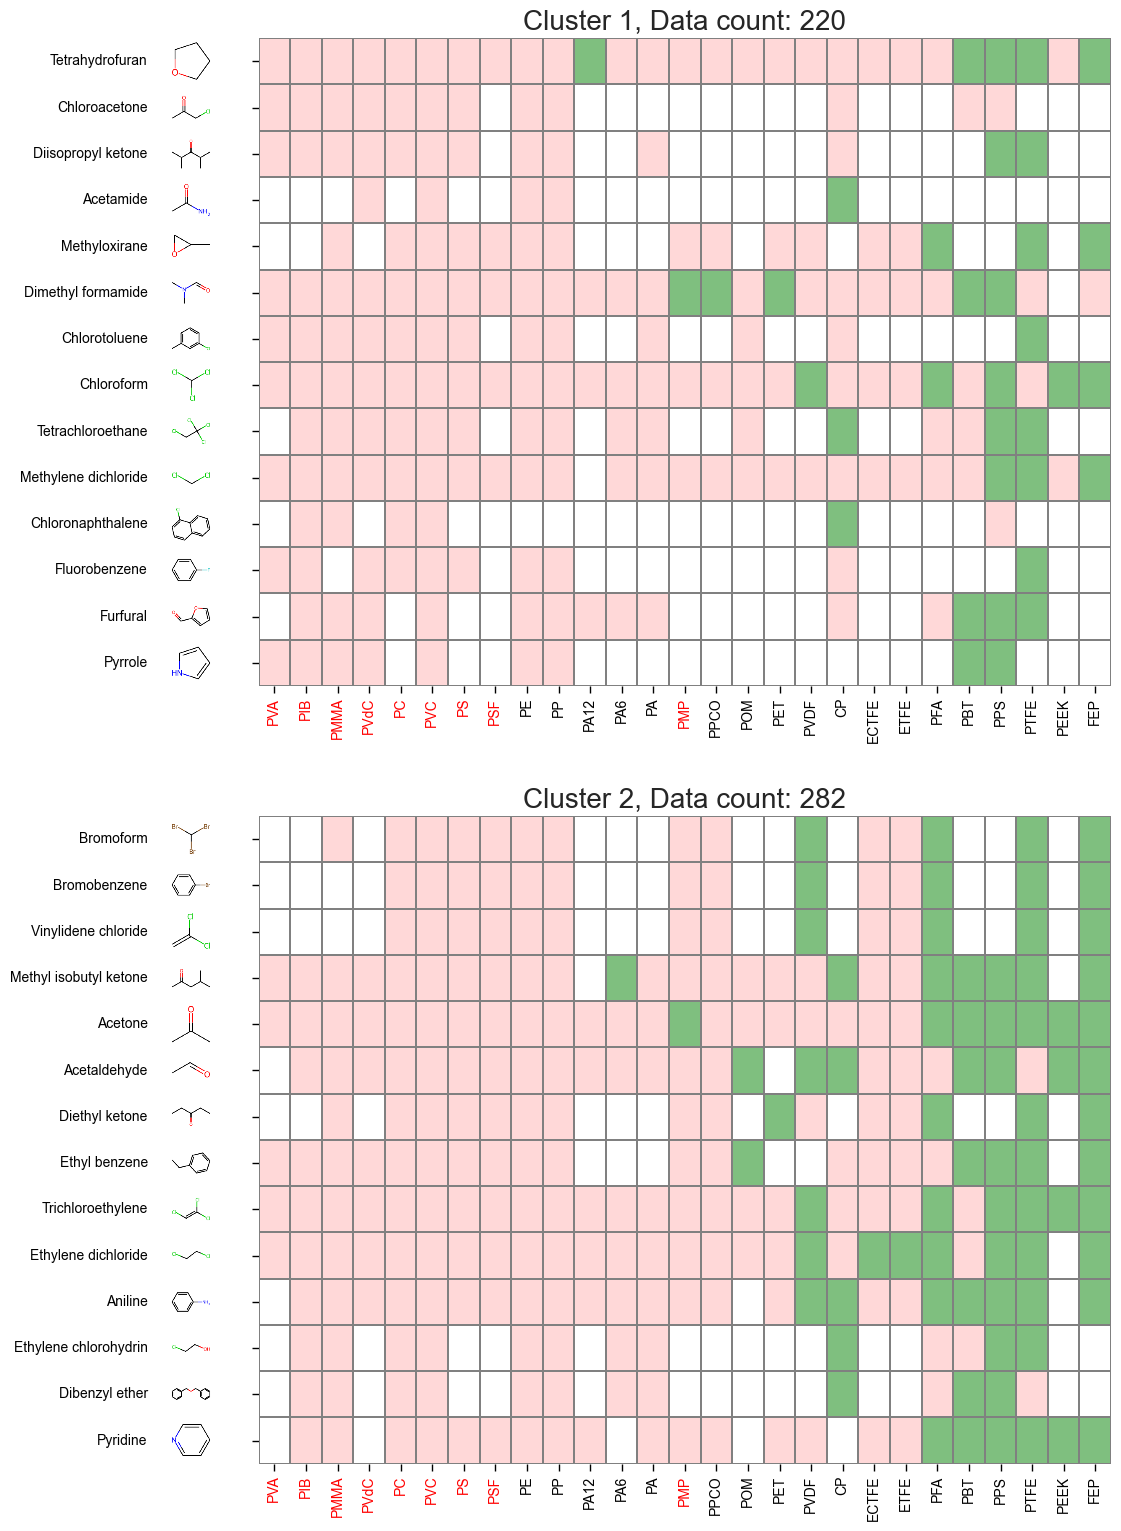

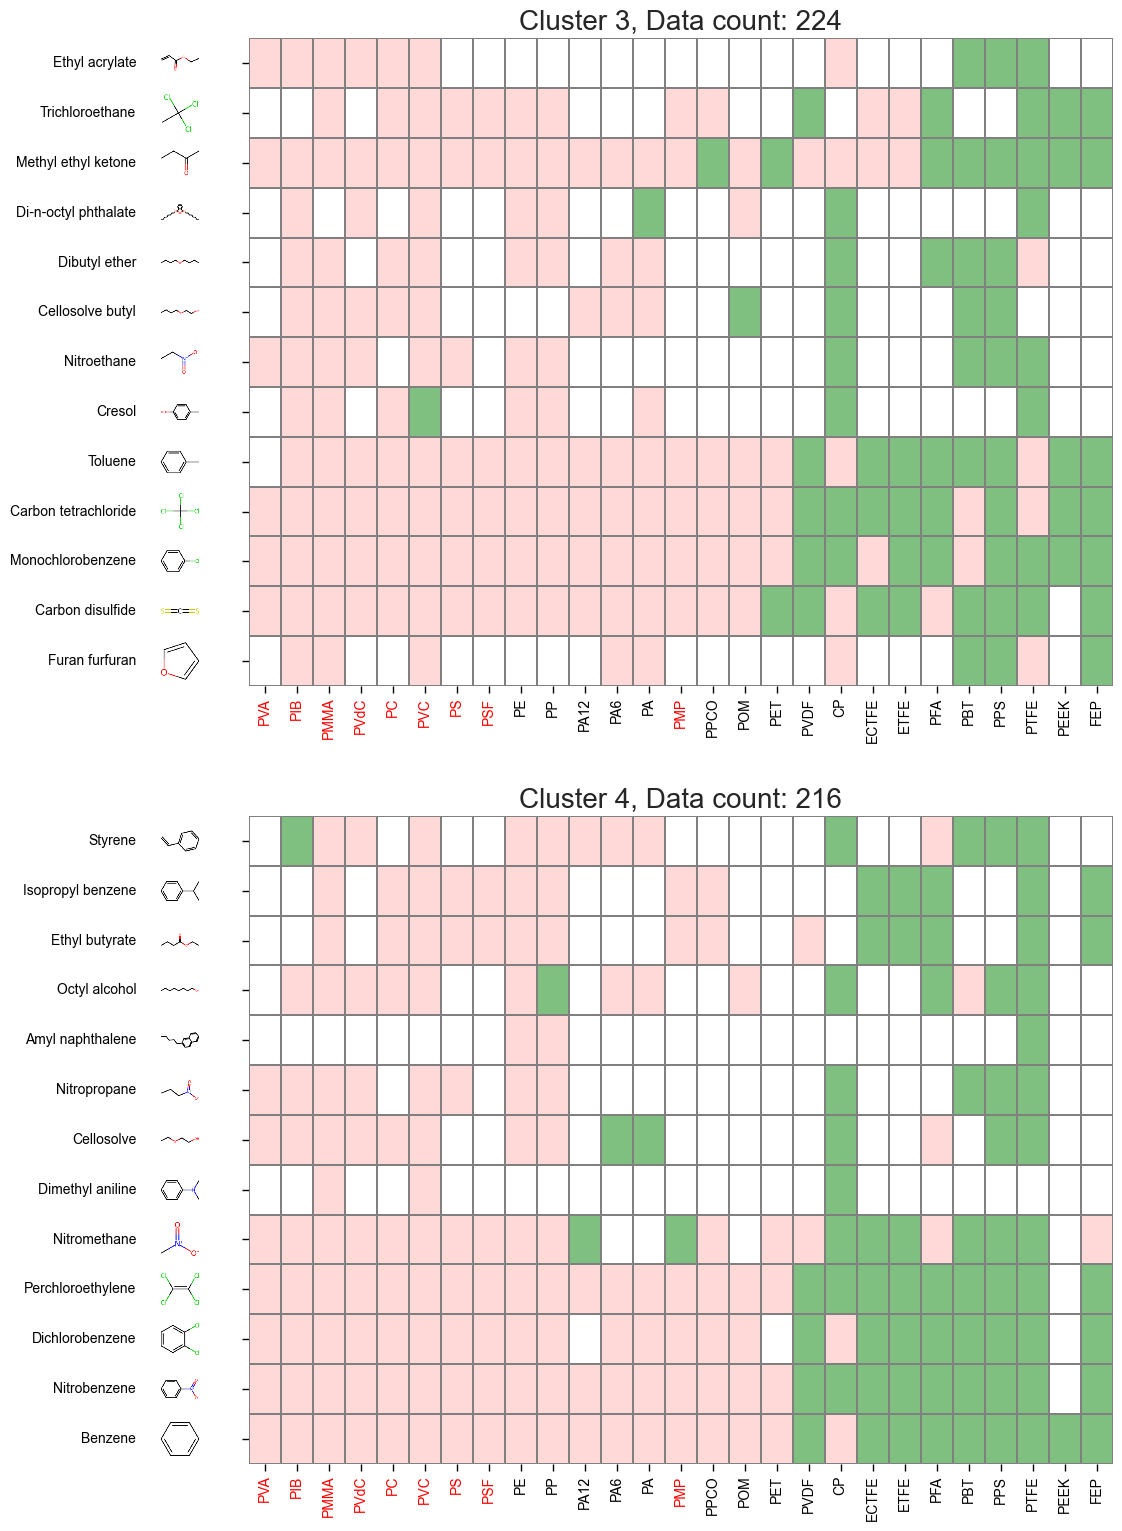

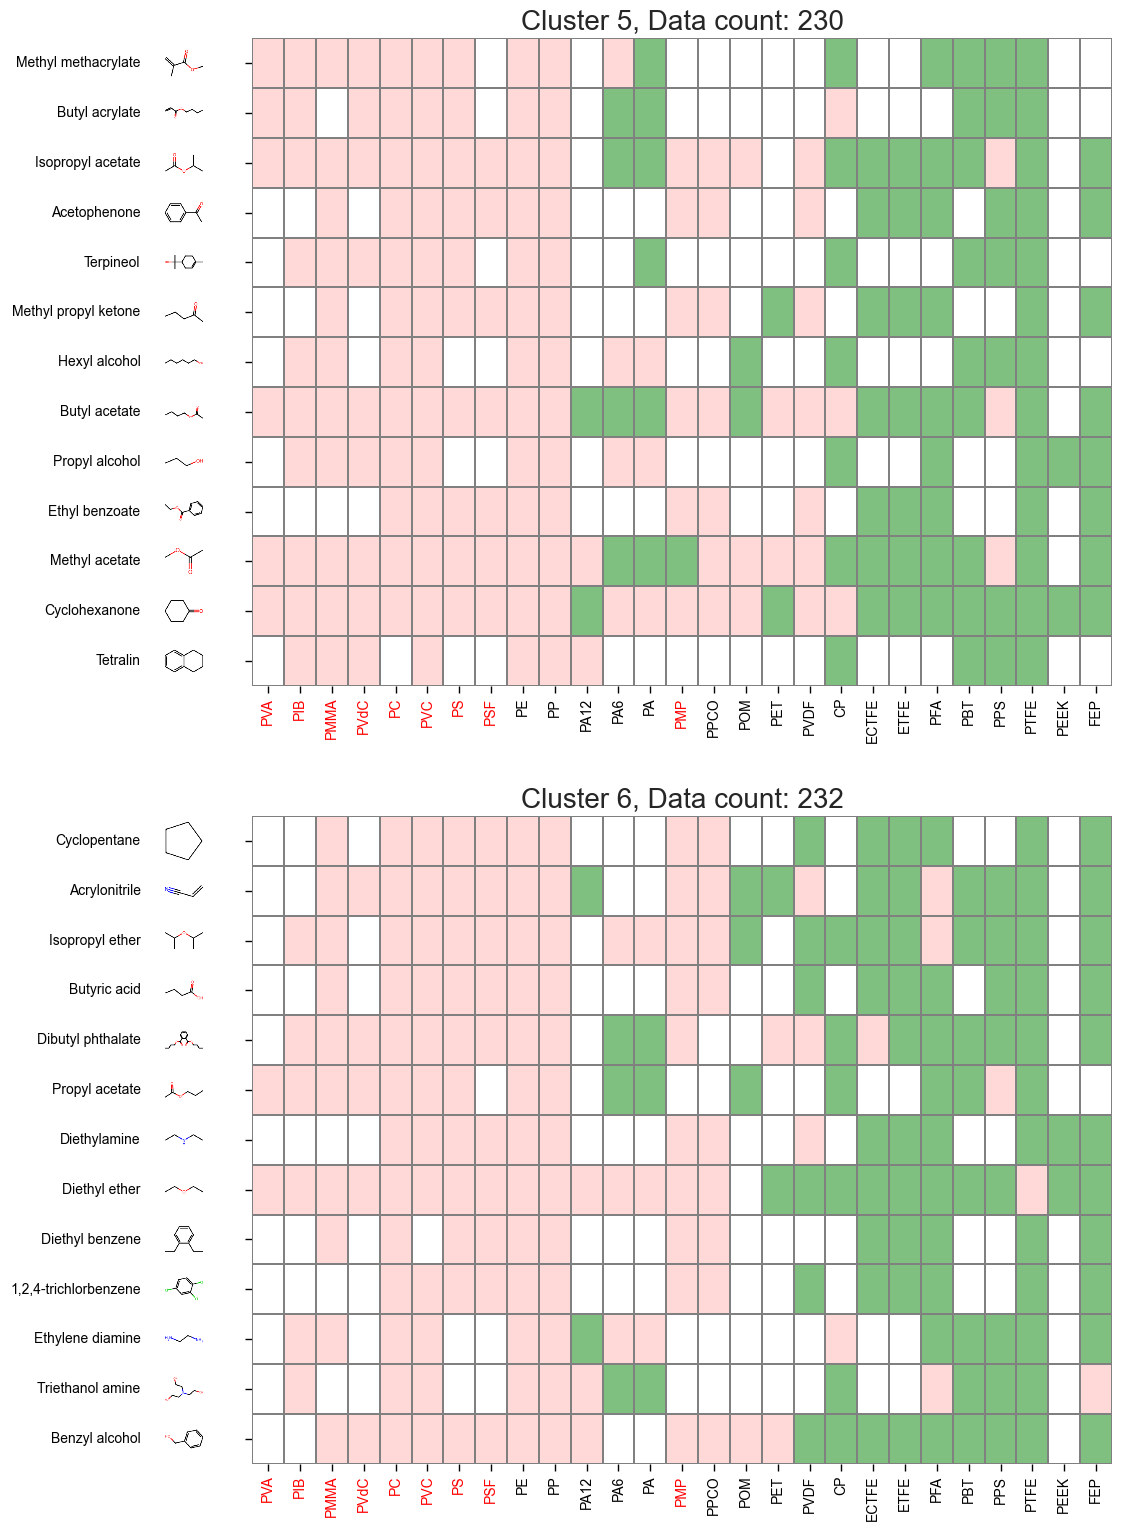

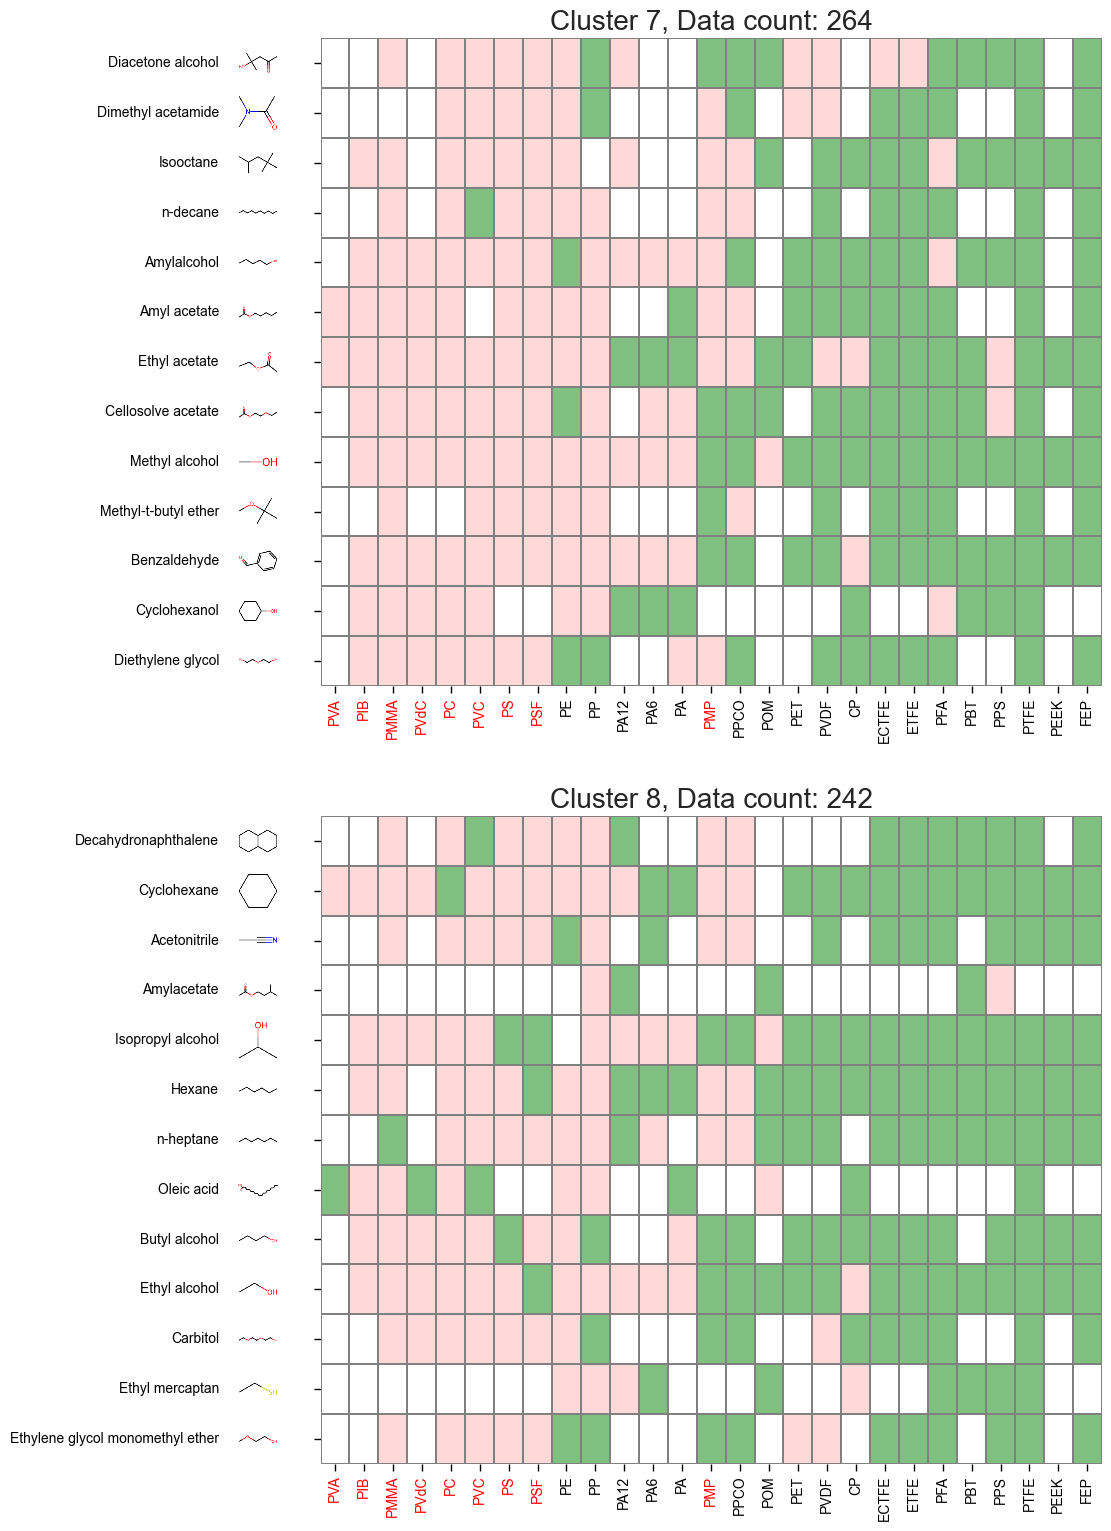

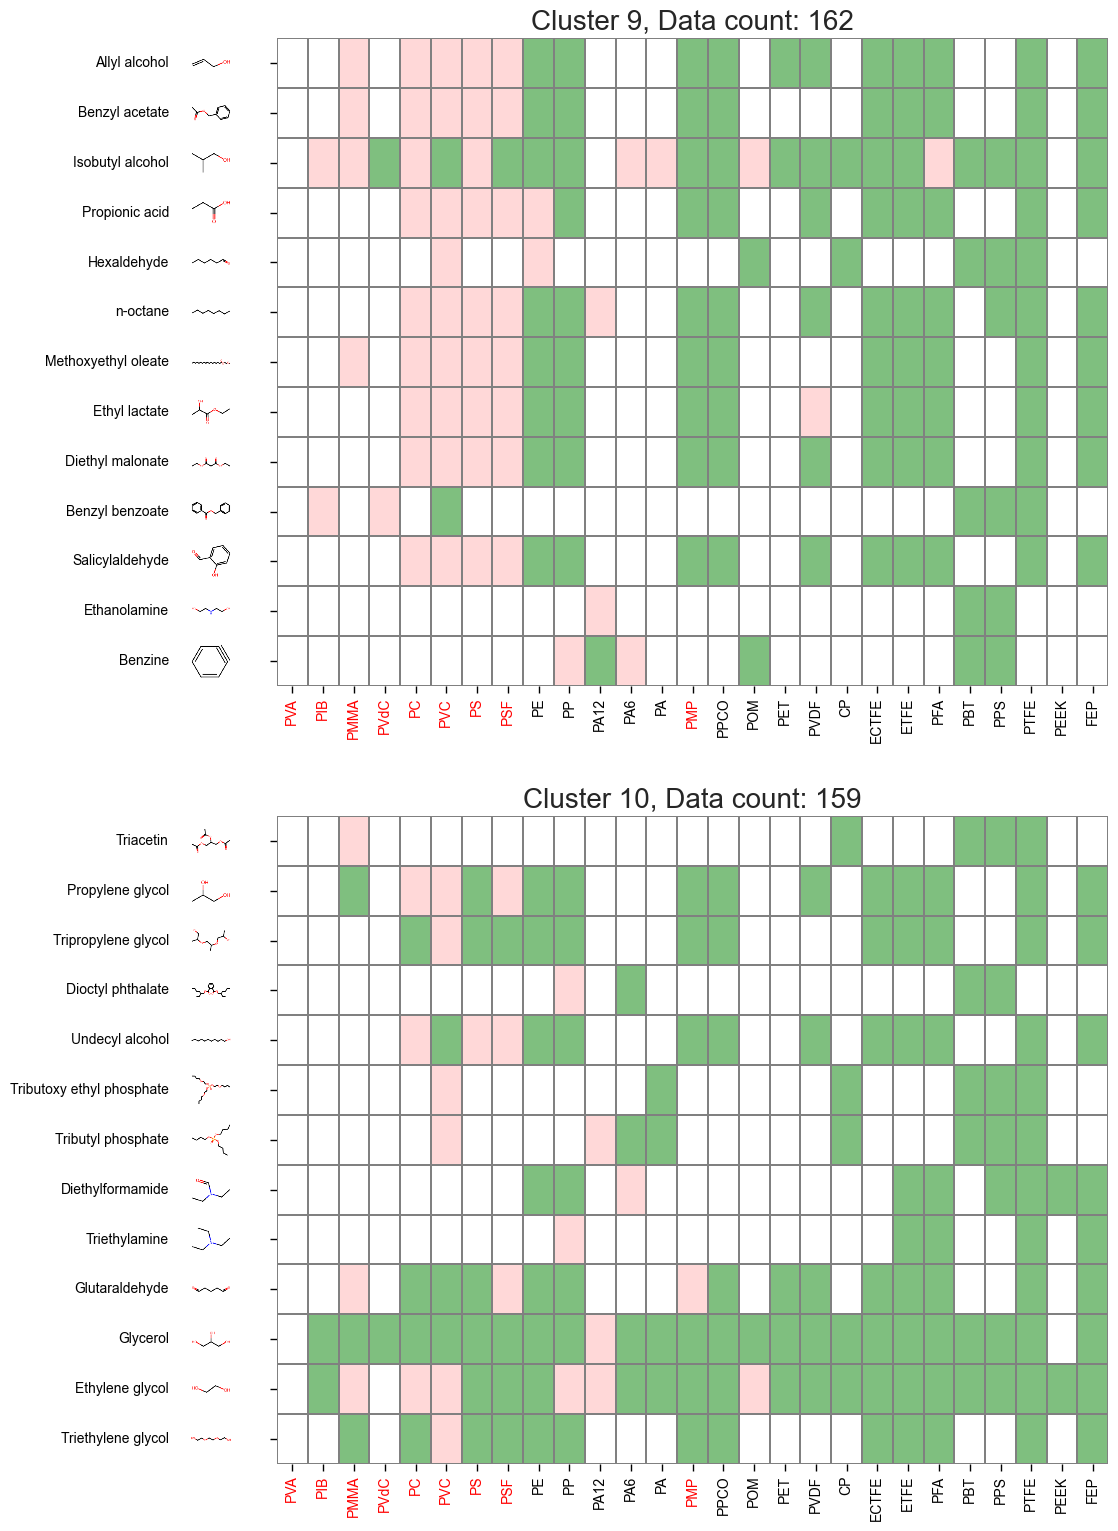

In [22]:
# Generate cluster heatmaps showing resistance patterns for each solvent cluster
plotting.generate_supplementary_s2_cluster_heatmaps(
    valid_info_cluster=valid_info_cluster,
    df_sorted=df_sorted,
    solvent_name_dict=solvent_name_dict,
    save_dir=REPORT_DIR_SUB
)
plt.show()

---
## 5. Dataset Preparation

### 5.1 Test Set Splitting

The following splitting patterns are available:
1. Split by specifying solvents for test data
2. Split by specifying polymers for test data
3. Random split so that neither solvent nor polymer has the same SMILES between train/test
4. Random split so that no same solvent SMILES between train/test
5. Random split so that no same polymer SMILES between train/test
6. Split by specifying solvent clusters for test data

In [23]:
# Preparation for splitting
unique_solvents: list[str] = valid_info["smiles_solvent"].unique().tolist()
unique_polymers: list[str] = valid_info["smiles_polymer"].unique().tolist()
np.random.default_rng(SEED).shuffle(unique_solvents)
np.random.default_rng(SEED).shuffle(unique_polymers)

In [24]:
# Classification by specified features
valid_data_cluster = valid_data_cluster[~valid_data_cluster.index.duplicated(keep='first')]
train_data = valid_data_cluster.copy()

test_data = pd.DataFrame(columns=valid_data.columns)

features = FF_solvent_cols + FF_polymer_cols

train_data = train_data[features]
test_data = test_data[features]

# Save train data
save_as_csv(train_data, directory=INTERIM_DIR)
train_info = valid_info_cluster.reindex(train_data.index)
save_as_csv(train_info, directory=INTERIM_DIR)

# Check crystallinity distribution in training data
crystallinity_counts = train_info.drop_duplicates(subset="name_polymer").value_counts("crystalinity_binary")
print(f"Crystallinity distribution in training set:")
print(crystallinity_counts)
print(f"Total training records: {len(train_info)}")

# Save test data (currently empty for this analysis)
save_as_csv(test_data, directory=INTERIM_DIR)
test_info = valid_info.reindex(test_data.index)
save_as_csv(test_info, directory=INTERIM_DIR)

print(f"Test set size: {len(test_info)} records")

Crystallinity distribution in training set:
crystalinity_binary
1.0    18
0.0     9
Name: count, dtype: int64
Total training records: 2231
Test set size: 0 records


### 5.2 Feature Combinations

Define different feature combinations for model training and evaluation.

In [25]:
# Specify target variable column (binary classification)
y_all = valid_info["resistance_binary"]
y_train = train_info["resistance_binary"]
y_test = test_info["resistance_binary"]

# True for binary classification
binary_classification = True

classification_type, num_classes = metrics.set_classification_type(binary_classification)

In [26]:
# Move cluster_labels to the last column
cluster_labels = valid_info_cluster.pop('cluster_labels')
valid_info_cluster['cluster_labels'] = cluster_labels

# CV column names
all_polymer_cols = ["cv_" + symbol for symbol in train_info.drop_duplicates(subset="symbol")["symbol"]]
solvent_cols = ["cv_solv_cluster_" + str(label) for label in train_info.drop_duplicates(subset="cluster_labels")["cluster_labels"]]
practical_polymer_cols = ["cv_PTFE","cv_PE","cv_PVC"]

In [27]:
# Crystallinity features
crystalinity_binary_col = ["crystalinity_binary"]

# RadonPy features
radonpy_choice_polymer_cols = [
    "density",
]
radonpy_choice_polymer_cols = [col + "_radonpy_polymer" for col in radonpy_choice_polymer_cols]
chi_col = ["chi"]

# Define all feature combinations
all_features_combinations = [
    FF_solvent_wo_polars_cols + FF_polymer_cols, #0
    FF_solvent_cols + FF_polymer_cols, #1
    FF_solvent_wo_polars_cols + FF_polymer_cols + crystalinity_binary_col, #2
    FF_solvent_cols + FF_polymer_cols + crystalinity_binary_col, #3
    FF_solvent_wo_polars_cols + FF_polymer_cols + radonpy_polymer_cols, #4
    FF_solvent_cols + FF_polymer_cols + radonpy_polymer_cols, #5
    FF_solvent_wo_polars_cols + FF_polymer_cols + crystalinity_binary_col + radonpy_polymer_cols, #6
    FF_solvent_cols + FF_polymer_cols + crystalinity_binary_col + radonpy_polymer_cols, #7
    FF_solvent_wo_polars_cols + FF_polymer_cols + chi_col, #8
    FF_solvent_cols + FF_polymer_cols + chi_col, #9
    FF_solvent_wo_polars_cols + FF_polymer_cols + crystalinity_binary_col + chi_col, #10
    FF_solvent_cols + FF_polymer_cols + crystalinity_binary_col + chi_col, #11
    FF_solvent_wo_polars_cols + FF_polymer_cols + radonpy_polymer_cols + chi_col, #12
    FF_solvent_cols + FF_polymer_cols + radonpy_polymer_cols + chi_col, #13
    FF_solvent_wo_polars_cols + FF_polymer_cols + crystalinity_binary_col + radonpy_polymer_cols + chi_col, #14
    FF_solvent_cols + FF_polymer_cols + crystalinity_binary_col + radonpy_polymer_cols + chi_col, #15
]

log_str_dict = {
    0:"FFwoPol", 1:"FF", 2:"FFwoPol_CL", 3:"FF_CL",
    4:"FFwoPol_RP", 5:"FF_RP", 6:"FFwoPol_CL_RP", 7:"FF_CL_RP",
    8:"FFwoPol_Chi", 9:"FF_Chi", 10:"FFwoPol_CL_Chi", 11:"FF_CL_Chi",
    12:"FFwoPol_RP_Chi", 13:"FF_RP_Chi", 14:"FFwoPol_CL_RP_Chi", 15:"FF_CL_RP_Chi",
}

# Target feature combination and parameters from config
feature_No = FEATURE_NO
params = GBDT_PARAMS
threshold = THRESHOLD

features = list(all_features_combinations[feature_No])
log_str = log_str_dict[feature_No]

print(f"Selected feature combination {feature_No}: {log_str}")
print(f"Number of features: {len(features)}")

Selected feature combination 15: FF_CL_RP_Chi
Number of features: 314


---
## 6. LOGOCV Cross-Validation

> **Note**: This section performs Leave-One-Group-Out Cross-Validation and may take significant time to execute (30-60 minutes depending on hardware).

In [28]:
def _train_cv(
    val_cluster: str, x_train: pd.DataFrame, y_train_true: pd.Series,
    x_val: pd.DataFrame, y_val_true: pd.Series, num_classes: int, threshold: float = 0.5
) -> pd.DataFrame:
    """Wrapper function for LOGOCV training."""
    return validation.train_cv_fold(
        val_cluster=val_cluster,
        x_train=x_train,
        y_train_true=y_train_true,
        x_val=x_val,
        y_val_true=y_val_true,
        num_classes=num_classes,
        threshold=threshold,
        params=params,
        dir_name=dir_name
    )

In [29]:
# LOGOCV VALIDATION
print(f"Starting LOGOCV validation with {N_JOBS} parallel jobs (this may take a long time)...")

binary_classification = True
classification_type, num_classes = metrics.set_classification_type(binary_classification)
y_all, y_train, y_test = metrics.set_y_values(binary_classification, valid_info, train_info, test_info)

# Create output directory
from utils.config import create_logocv_directory
dir_name = create_logocv_directory(classification_type)

all_features_combinations_logocv = [features]
results = []

for index, features_iter in tqdm(enumerate(all_features_combinations_logocv), total=len(all_features_combinations_logocv)):
    train_data = valid_data_cluster.copy()[list(features_iter)]
    test_data = pd.DataFrame(columns=valid_data.columns)[list(features_iter)]

    train_info_sel = valid_info_cluster.reindex(train_data.index)
    test_info_sel = valid_info.reindex(test_data.index)

    dfs = []

    # Calculate optimal n_jobs based on number of groups
    n_polymer_groups = train_info_sel['smiles_polymer'].nunique()
    n_solvent_groups = train_info_sel['cluster_labels'].nunique()
    
    n_jobs_polymer = min(n_polymer_groups, N_JOBS) if N_JOBS > 0 else n_polymer_groups
    n_jobs_solvent = min(n_solvent_groups, N_JOBS) if N_JOBS > 0 else n_solvent_groups
    
    print(f"  Polymer LOGOCV: {n_polymer_groups} groups, using {n_jobs_polymer} parallel jobs")
    print(f"  Solvent LOGOCV: {n_solvent_groups} groups, using {n_jobs_solvent} parallel jobs")

    # Cross-validation for polymer (parallel processing)
    validation.run_logocv_validation(
        train_data=train_data, train_info=train_info_sel, y_train=y_train,
        group_column="smiles_polymer", cv_prefix="cv", dfs=dfs,
        num_classes=num_classes, threshold=threshold, iloc_index=1,
        n_jobs=n_jobs_polymer, train_cv_func=_train_cv,
    )

    # Cross-validation for solvent (parallel processing)
    validation.run_logocv_validation(
        train_data=train_data, train_info=train_info_sel, y_train=y_train,
        group_column="cluster_labels", cv_prefix="cv_solv_cluster", dfs=dfs,
        num_classes=num_classes, threshold=threshold, iloc_index=-1,
        n_jobs=n_jobs_solvent, train_cv_func=_train_cv,
    )

    result = pd.concat(dfs, axis=1)
    result['features'] = [features_iter] * len(result)

    metric_names = ["micro_f1", "macro_f1", "auc", "accuracy", "fpr", "fnr"]
    for metric in metric_names:
        polymer_cols_metric = [f"{col}_{metric}" for col in all_polymer_cols]
        practical_polymer_cols_metric = [f"{col}_{metric}" for col in practical_polymer_cols]
        solvent_cols_filtered = [f"{col}_{metric}" for col in solvent_cols]
    
        result[f"all_polymer_mean_{metric}"] = result[polymer_cols_metric].mean(axis=1)
        result[f"all_polymer_std_{metric}"] = result[polymer_cols_metric].std(axis=1)
        result[f"practical_polymer_mean_{metric}"] = result[practical_polymer_cols_metric].mean(axis=1)
        result[f"practical_polymer_std_{metric}"] = result[practical_polymer_cols_metric].std(axis=1)
        result[f"all_solvent_mean_{metric}"] = result[solvent_cols_filtered].mean(axis=1)
        result[f"all_solvent_std_{metric}"] = result[solvent_cols_filtered].std(axis=1)
        result[f"all_mean_{metric}"] = result[[f"all_polymer_mean_{metric}", f"all_solvent_mean_{metric}"]].mean(axis=1)
        result = metrics.calc_std_all(result, metric)

    results.append(result)

# Save final results as CSV
final_result = pd.concat(results, axis=0)
for metric in metric_names:
    final_result_metric = final_result.filter(like=f"_{metric}")
    final_result_metric["features"] = final_result["features"]
    final_result_metric.sort_values(f"all_mean_{metric}", ascending=False, inplace=True)
    final_result_metric.reset_index(drop=True, inplace=True)
    filename = os.path.join(dir_name, f"result_{metric}.csv")
    final_result_metric.to_csv(filename)
    print(f"Saved final result for {metric} to {filename}")

Starting LOGOCV validation with 35 parallel jobs (this may take a long time)...


  0%|          | 0/1 [00:00<?, ?it/s]

  Polymer LOGOCV: 27 groups, using 27 parallel jobs
  Solvent LOGOCV: 10 groups, using 10 parallel jobs


[Parallel(n_jobs=27)]: Using backend LokyBackend with 27 concurrent workers.
[Parallel(n_jobs=27)]: Done   4 out of  27 | elapsed:   48.9s remaining:  4.7min
[Parallel(n_jobs=27)]: Done   7 out of  27 | elapsed:   49.1s remaining:  2.3min
[Parallel(n_jobs=27)]: Done  10 out of  27 | elapsed:   49.2s remaining:  1.4min
[Parallel(n_jobs=27)]: Done  13 out of  27 | elapsed:   49.3s remaining:   53.1s
[Parallel(n_jobs=27)]: Done  16 out of  27 | elapsed:   49.6s remaining:   34.1s
[Parallel(n_jobs=27)]: Done  19 out of  27 | elapsed:   49.7s remaining:   20.9s
[Parallel(n_jobs=27)]: Done  22 out of  27 | elapsed:   49.9s remaining:   11.3s
[Parallel(n_jobs=27)]: Done  25 out of  27 | elapsed:   50.1s remaining:    4.0s
[Parallel(n_jobs=27)]: Done  27 out of  27 | elapsed:   50.3s finished


Processing PC
Processing PVC
Processing PTFE
Processing PMMA
Processing PPS
Processing FEP
Processing PP
Processing CP
Processing PS
Processing ECTFE
Processing PBT
Processing PSF
Processing ETFE
Processing PE
Processing POM
Processing PMP
Processing PA6
Processing PVA
Processing PA12
Processing PVdC
Processing PFA
Processing PIB
Processing PVDF
Processing PA
Processing PET
Processing PPCO
Processing PEEK


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:   45.2s remaining:  1.8min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:   45.7s remaining:   45.7s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:   46.1s remaining:   19.7s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   47.1s finished
100%|██████████| 1/1 [01:38<00:00, 98.32s/it]

Saved final result for micro_f1 to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/LOGOCV/result_micro_f1.csv
Saved final result for macro_f1 to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/LOGOCV/result_macro_f1.csv
Saved final result for auc to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/LOGOCV/result_auc.csv
Saved final result for accuracy to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/LOGOCV/result_accuracy.csv
Saved final result for fpr to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/LOGOCV/result_fpr.csv
Saved final result for fnr to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/LOGOCV/result_fnr.csv


### 6.1 Supplementary Figure S3: ROC Curves and Confusion Matrices

In [30]:
# SUPPLEMENTARY FIGURE S3: ROC Curves and Confusion Matrices
# Use LOGOCV_DIR from config
logocv_dir = LOGOCV_DIR
plot_data_dir = logocv_dir / "plot_data"

# Convert symbol_order to list
symbol_order = list(df_sorted.sort_values('polymer_rank')['symbol'].unique())

# Generate S3 figures (saved in reports_paper/Sub/S3/)
plotting.generate_supplementary_s3_roc_confusion(
    plot_data_dir=str(plot_data_dir),
    output_dir=REPORT_DIR_SUB,
    symbol_order=symbol_order,
    font_size=16
)
plt.show()

Saved: /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S3/S3_19_CP_combined.svg and /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S3/S3_19_CP_combined.jpg
Saved: /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S3/S3_20_ECTFE_combined.svg and /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S3/S3_20_ECTFE_combined.jpg
Saved: /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S3/S3_21_ETFE_combined.svg and /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S3/S3_21_ETFE_combined.jpg
Saved: /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S3/S3_27_FEP_combined.svg and /home/jovyan/HD/200_Projects/85th/303_pape

### 6.2 Load and Analyze LOGOCV Results

In [31]:
# Read LOGOCV results
metric_names = ["micro_f1", "macro_f1", "auc", "accuracy", "fpr", "fnr"]
# Use LOGOCV_DIR from config
logocv_dir = LOGOCV_DIR
result_files = {}
for metric in metric_names:
    result_file = logocv_dir / f"result_{metric}.csv"
    if result_file.exists():
        result_files[metric] = result_file
    else:
        print(f"Warning: No result file found for metric '{metric}' in {logocv_dir}")
        result_files[metric] = None

# Read the results for each metric into a DataFrame
dfs = {}
for metric in metric_names:
    if result_files[metric] and result_files[metric].exists():
        dfs[metric] = pd.read_csv(result_files[metric], index_col=0)
        print(f"Loaded {metric} results from {result_files[metric].name}")
    else:
        print(f"Skipping {metric}: file not found")

Loaded micro_f1 results from result_micro_f1.csv
Loaded macro_f1 results from result_macro_f1.csv
Loaded auc results from result_auc.csv
Loaded accuracy results from result_accuracy.csv
Loaded fpr results from result_fpr.csv
Loaded fnr results from result_fnr.csv


---
## 7. Resistance Prediction Model (Figure 3)

> **Note**: This section trains the resistance prediction model and may take significant time to execute (10-20 minutes depending on hardware). Pre-trained models are available in the `models/` directory.

### 7.1 Helper Functions for Visualization

In [32]:
# 2-class classification value extraction
def _get_resistance_binary_values(
    info: pd.DataFrame,
    smiles_name_dict: dict[str, dict[str, str]],
    key_col: str,
    *,
    sort_key: Sequence[Any] = [0, 1],
    is_rate: bool = False,
    is_reverse: bool = False,
) -> pd.DataFrame:
    key_samples = info.drop_duplicates(subset=key_col)
    keys: list[str] = key_samples[key_col].tolist()
    ticklabels = [smiles_name_dict[key]["jp_abbr"] for key in keys]

    counts = pd.DataFrame(
        {
            ylabel: info.loc[info[key_col] == key, "resistance_binary"].value_counts()
            for key, ylabel in zip(keys, ticklabels, strict=True)
        },
    )

    values = counts.fillna(0).astype(int)
    if is_rate:
        values = values.div(values.sum(axis=0), axis=1)

    values = values.sort_values(by=sort_key, ascending=not is_reverse, axis=1)

    return values

values = _get_resistance_binary_values(valid_info, polymer_name_dict, "smiles_polymer", is_rate=True, is_reverse=True)

columns = values.columns
new_columns = [re.search('\((.*?)\)', col).group(1) if '(' in col else col for col in columns]
print(new_columns)

['FEP', 'PEEK', 'PTFE', 'PPS', 'PBT', 'PFA', 'ETFE', 'ECTFE', 'CP', 'PVDF', 'PET', 'POM', 'PPCO', 'PMP', 'PA', 'PA6', 'PA12', 'PP', 'PE', 'PSF', 'PS', 'PVC', 'PC', 'PVdC', 'PMMA', 'PIB', 'PVA']


### 7.2 Figure 3: Combined LOGOCV Results

Figure 3 saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Main/fig3.svg and /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Main/fig3.pdf


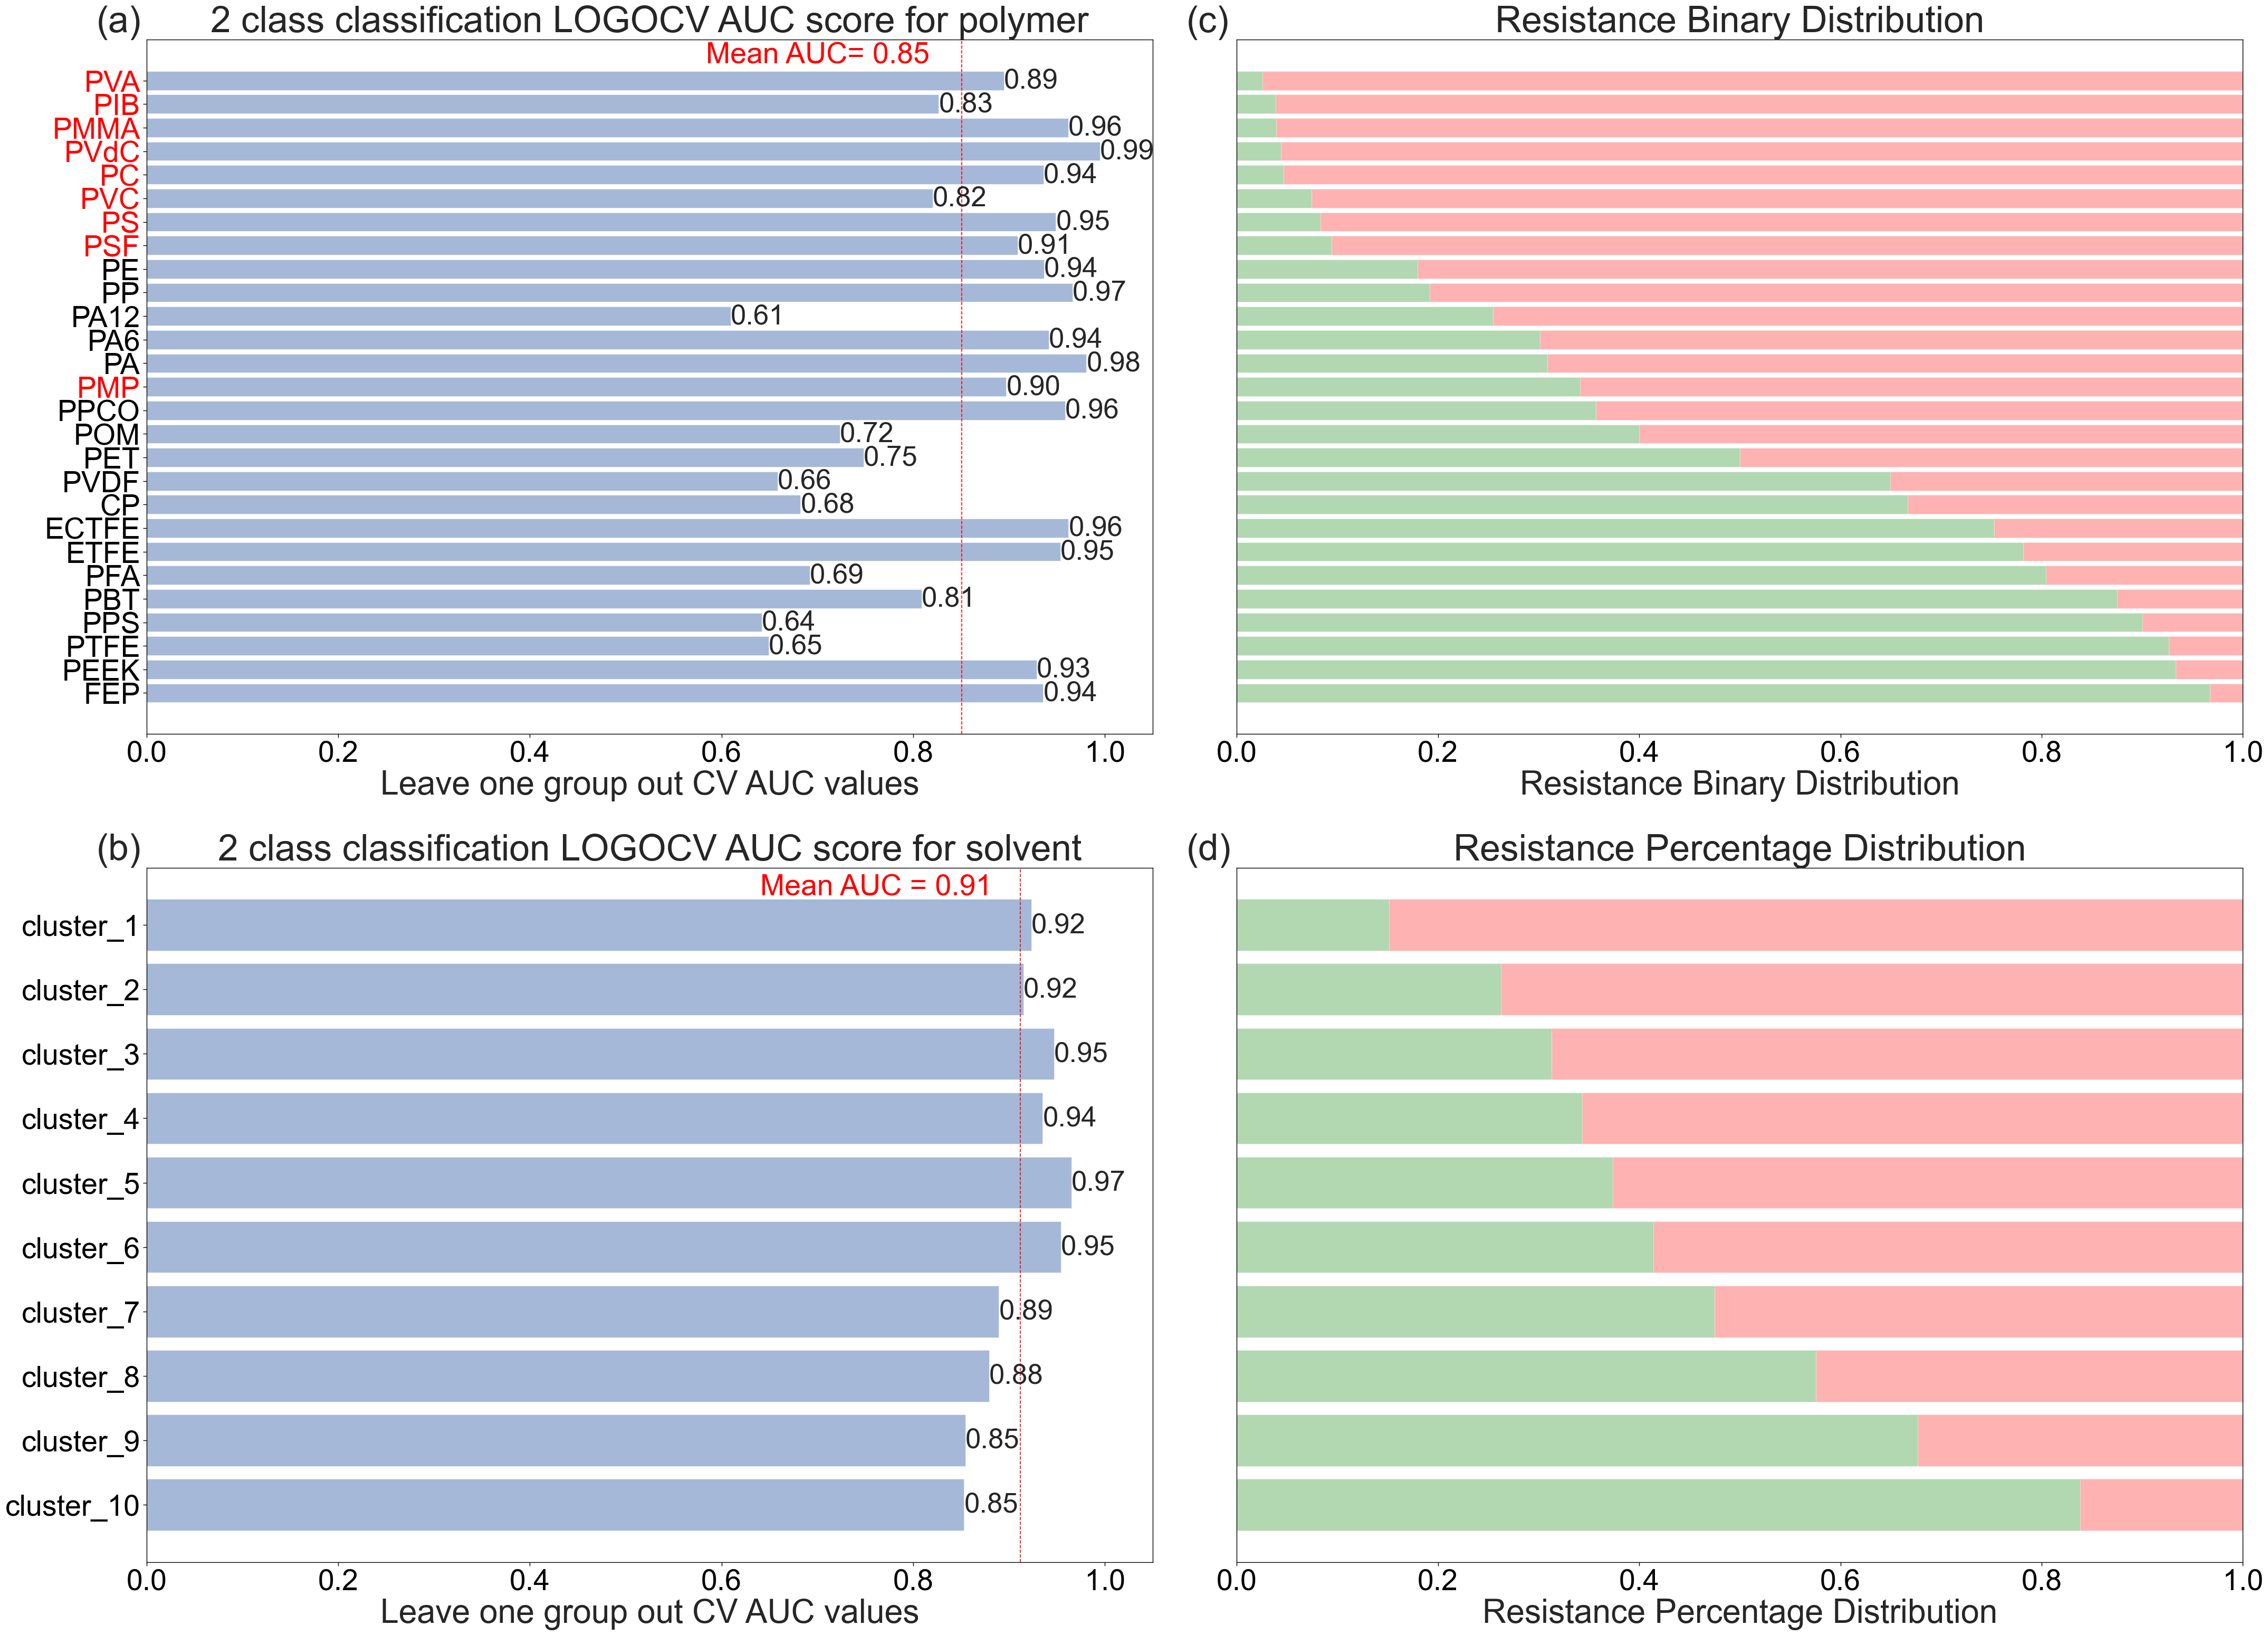

In [33]:
# Font size constants
BASE_FONT_SIZE = 40
TITLE_FONT_SIZE = int(BASE_FONT_SIZE * 1.25)
LABEL_FONT_SIZE = int(BASE_FONT_SIZE * 1.125)
TICK_FONT_SIZE = BASE_FONT_SIZE
ANNOTATION_FONT_SIZE = BASE_FONT_SIZE - 2

plt.rcParams.update({
    'font.size': BASE_FONT_SIZE,
    'axes.titlesize': TITLE_FONT_SIZE,
    'axes.labelsize': LABEL_FONT_SIZE,
    'xtick.labelsize': TICK_FONT_SIZE,
    'ytick.labelsize': TICK_FONT_SIZE,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'pdf.fonttype': 42
})

fig3 = plotting.generate_figure3_combined(
    dfs=dfs,
    values=values,
    valid_info=valid_info,
    valid_info_cluster=valid_info_cluster,
    average_df=average_df,
    polymer_name_dict=polymer_name_dict,
    save_dir=REPORT_DIR_MAIN
)
plt.show()

### 7.3 Train Resistance Model

In [34]:
# Prepare features
features = list(all_features_combinations[feature_No]) 
print("all", len(features))

# Columns to exclude
exclude_cols = ['n_atom_radonpy_polymer', 'mol_weight_radonpy_polymer']
features = [col for col in features if col not in exclude_cols]
print("excluded", len(features))

train_data = valid_data_cluster.copy()[list(features)]
X_train = train_data[features]

# RESISTANCE MODEL: Training or Loading
dir_name = MODEL_DIR

if TRAIN_RESISTANCE_MODEL:
    # Train and save new model
    print("Training new resistance prediction model...")
    gbdt_model = train.train_and_save_resistance_model(X_train, y_train, params, dir_name)
    print(f"Model saved to {dir_name}")
else:
    # Load pre-trained model
    print("Loading pre-trained resistance prediction model...")
    model_filepath = os.path.join(dir_name, "chemical_resistance_model.pkl")
    gbdt_model = train.load_model(model_filepath)

all 314
excluded 314
Training new resistance prediction model...
Model saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Model


### 7.4 Model Evaluation

In [35]:
# Model Analysis and Evaluation
features = list(all_features_combinations[feature_No])
exclude_cols = ['n_atom_radonpy_polymer', 'mol_weight_radonpy_polymer']
features = [col for col in features if col not in exclude_cols]

train_data = valid_data_cluster.copy()[list(features)]
X_train = train_data[features]

result_dir = os.path.join(REPORT_DIR_SUB, "gbdt_model_result")
_ = plotting.save_model_results(gbdt_model, X_train, y_train, save_dir=result_dir, threshold=0.9)

# Evaluation by group
metrics_save_dir = os.path.join(REPORT_DIR_SUB, "gbdt_model_result")
_ = metrics.save_metrics_by_group(
    model=gbdt_model, X_data=X_train, y_data=y_train,
    group_info=train_info, group_column="symbol",
    save_dir=metrics_save_dir, num_classes=num_classes, threshold=0.5, new_columns=new_columns
)

_ = metrics.save_metrics_by_group(
    model=gbdt_model, X_data=X_train, y_data=y_train,
    group_info=train_info, group_column="cluster_labels",
    save_dir=metrics_save_dir, num_classes=num_classes, threshold=0.5, new_columns=new_columns
)

### 7.5 Feature Importance Analysis

In [36]:
# Feature Importance
fi_save_dir = os.path.join(REPORT_DIR_SUB, "gbdt_model_result", "feature_importance")
_ = plotting.plot_feature_importance(gbdt_model, X_train.columns.tolist(), save_dir=fi_save_dir, top_n=50)
plt.close('all')

### 7.6 MIC Calculation for Feature Importance

> **Note**: MIC calculation may take 10-30 minutes depending on dataset size and hardware.

In [37]:
# MIC calculation for feature importance analysis
print(f"Calculating MIC for feature importance (experimental data)...")
mic_dir = os.path.join(REPORT_DIR_SUB, "gbdt_model_result", "feature_importance")
os.makedirs(mic_dir, exist_ok=True)

filename = "mic_feature_importance_all.jpg"

print(f"  Dataset: Experimental data (n={len(X_train)})")
print(f"  Features: {len(X_train.columns)} features")

mic.calculate_and_save_mic(gbdt_model, X_train, y_train, dir_name=mic_dir, top_n=100, filename=filename, n_jobs=N_JOBS)

Calculating MIC for feature importance (experimental data)...
  Dataset: Experimental data (n=2231)
  Features: 314 features
📊 Starting MIC calculation...
📈 Number of features to compute: 314
🔄 Computing MIC (35 parallel jobs)...
Processing 2
Processing 7
Processing 6
Processing 8
Processing 1
Processing 4
Processing 5
Processing 3
Processing 9
Processing 10


[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 tasks      | elapsed:    5.9s
[Parallel(n_jobs=35)]: Done  15 tasks      | elapsed:    6.0s
[Parallel(n_jobs=35)]: Done  28 tasks      | elapsed:    6.1s
[Parallel(n_jobs=35)]: Done  43 tasks      | elapsed:    6.2s
[Parallel(n_jobs=35)]: Done  58 tasks      | elapsed:    6.2s
[Parallel(n_jobs=35)]: Done  75 tasks      | elapsed:    6.2s
[Parallel(n_jobs=35)]: Batch computation too fast (0.19838717360127223s.) Setting batch_size=2.
[Parallel(n_jobs=35)]: Done  92 tasks      | elapsed:    6.2s
[Parallel(n_jobs=35)]: Done 111 tasks      | elapsed:    6.3s
[Parallel(n_jobs=35)]: Done 130 tasks      | elapsed:    6.3s
[Parallel(n_jobs=35)]: Done 151 tasks      | elapsed:    6.3s
[Parallel(n_jobs=35)]: Batch computation too fast (0.058807373046875s.) Setting batch_size=4.
[Parallel(n_jobs=35)]: Done 175 tasks      | elapsed:    6.3s
[Parallel(n_jobs=35)]: Done 220 tasks      | elapse

🖼️ Figure saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/gbdt_model_result/feature_importance/mic_feature_importance_all.jpg
📄 MIC scores saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/gbdt_model_result/feature_importance/mic_feature_importance_all_mic_scores.csv
✅ MIC calculation completed.


feature       MIC
183   FF_charge_12_polymer  0.392893
184   FF_charge_13_polymer  0.392893
188   FF_charge_17_polymer  0.392893
187   FF_charge_16_polymer  0.392893
186   FF_charge_15_polymer  0.392893
..                     ...       ...
82    FF_k_bond_17_solvent  0.082293
44   FF_epsilon_18_solvent  0.082132
78    FF_k_bond_13_solvent  0.082064
83    FF_k_bond_18_solvent  0.079625
84    FF_k_bond_19_solvent  0.079495

[314 rows x 2 columns]

---
## 8. Chi Parameter Surrogate Model

> **Note**: This section trains the chi parameter prediction model and may take significant time to execute (5-15 minutes depending on hardware).

### 8.1 10-Fold Cross Validation

In [38]:
# Chi Parameter Surrogate Model
features = all_features_combinations[feature_No]
exclude_cols = ['n_atom_radonpy_polymer', 'mol_weight_radonpy_polymer']
features = [col for col in features if col not in exclude_cols]
data = valid_data_cluster.copy()[list(features)]
chi_explanatory_cols = FF_solvent_cols + FF_polymer_cols + radonpy_polymer_cols
chi_explanatory_cols = [col for col in chi_explanatory_cols if col not in exclude_cols]
X = data[chi_explanatory_cols]
y = data[chi_col]
model_name = "XGBoost"

print("=== 10-Fold Cross Validation ===")
save_dir = os.path.join(REPORT_DIR_SUB, f"chi_model_{model_name}")
os.makedirs(save_dir, exist_ok=True)

# Run chi parameter CV using validation module
chi_cv_results = validation.run_chi_parameter_cv(
    X=X, y=y,
    model=train.get_chi_model(model_name),
    n_splits=10, random_state=42
)

r2_scores = chi_cv_results['r2_scores']
mae_scores = chi_cv_results['mae_scores']
rmse_scores = chi_cv_results['rmse_scores']
cv_results = chi_cv_results['cv_results']
parity_data = chi_cv_results['parity_data']
mean_r2 = chi_cv_results['mean_r2']
std_r2 = chi_cv_results['std_r2']
mean_mae = chi_cv_results['mean_mae']
std_mae = chi_cv_results['std_mae']
mean_rmse = chi_cv_results['mean_rmse']
std_rmse = chi_cv_results['std_rmse']

mean_row = pd.DataFrame({'Fold': ['Mean'], 'R2': [mean_r2], 'MAE': [mean_mae], 'RMSE': [mean_rmse]})
std_row = pd.DataFrame({'Fold': ['Std'], 'R2': [std_r2], 'MAE': [std_mae], 'RMSE': [std_rmse]})

cv_results_df = pd.DataFrame(cv_results)
cv_results_df = pd.concat([cv_results_df, mean_row, std_row], ignore_index=True)
cv_results_df.to_csv(os.path.join(save_dir, 'cv_results.csv'), index=False)

print("\n=== Cross-Validation Summary ===")
print(cv_results_df)

=== 10-Fold Cross Validation ===

=== Cross-Validation Summary ===
    Fold        R2       MAE      RMSE
0      1  0.931412  0.159832  0.286481
1      2  0.919093  0.187811  0.293066
2      3  0.807523  0.211830  0.466949
3      4  0.479903  0.253142  1.198886
4      5  0.931668  0.172326  0.270356
5      6  0.596754  0.245698  0.634830
6      7  0.908722  0.170996  0.300961
7      8  0.888353  0.177743  0.393340
8      9  0.763313  0.227100  0.545587
9     10  0.826719  0.182043  0.402302
10  Mean  0.805346  0.198852  0.479276
11   Std  0.154207  0.033267  0.280314


### 8.2 Train Final Chi Parameter Model

In [39]:
# CHI MODEL: Training or Loading
features = all_features_combinations[feature_No]
exclude_cols = ['n_atom_radonpy_polymer', 'mol_weight_radonpy_polymer']
features = [col for col in features if col not in exclude_cols]
data = valid_data_cluster.copy()[list(features)]
chi_explanatory_cols = FF_solvent_cols + FF_polymer_cols + radonpy_polymer_cols
chi_explanatory_cols = [col for col in chi_explanatory_cols if col not in exclude_cols]
X = data[chi_explanatory_cols]
y = data[chi_col]
model_path = os.path.join(MODEL_DIR, "chi_parameter_model.pkl")

if TRAIN_CHI_MODEL:
    print("Training new chi parameter prediction model...")
    model_name = "XGBoost"
    final_model = train.train_and_save_chi_model(
        X_train=X, y_train=y, save_dir=MODEL_DIR,
        model_name=model_name, model_filename="chi_parameter_model.pkl", random_state=42
    )
    
    # Evaluate final model
    y_pred_full = final_model.predict(X)
    r2_full = r2_score(y, y_pred_full)
    mae_full = mean_absolute_error(y, y_pred_full)
    rmse_full = np.sqrt(mean_squared_error(y, y_pred_full))
    
    print("\n=== Model Evaluation Results ===")
    print(f"R2: {r2_full:.4f}")
    print(f"MAE: {mae_full:.4f}")
    print(f"RMSE: {rmse_full:.4f}")
else:
    print("Loading pre-trained chi parameter prediction model...")
    final_model = train.load_model(model_path)
    print(f"Model loaded from: {model_path}")

Training new chi parameter prediction model...

=== Model Evaluation Results ===
R2: 0.9994
MAE: 0.0188
RMSE: 0.0274


---
## 9. Crystallinity Classification Model (Figure 4)

> **Note**: This section trains the crystallinity model with 100 random seeds for robust evaluation. This may take 20-40 minutes depending on hardware.

### 9.1 Model Training with Multiple Random Seeds

In [40]:
# CRYSTALLINITY MODEL: Training or Loading Results
data = valid_data_cluster.copy()[list(features)]
data.drop_duplicates(subset=FF_polymer_cols, inplace=True)
CL_explanatory_cols = radonpy_polymer_cols
exclude_cols = ['n_atom_radonpy_polymer', 'mol_weight_radonpy_polymer']
CL_explanatory_cols = [col for col in CL_explanatory_cols if col not in exclude_cols]
X = data[CL_explanatory_cols]
y = data[crystalinity_binary_col]

if TRAIN_CRYSTALLINITY_MODEL:
    n_iterations = 100
    cv_results_dict = validation.run_crystallinity_cv(
        X=X, y=y, n_iterations=n_iterations, n_splits=9, n_jobs=N_JOBS
    )
    
    all_accuracies = cv_results_dict['accuracies']
    all_precisions = cv_results_dict['precisions']
    all_recalls = cv_results_dict['recalls']
    all_f1_scores = cv_results_dict['f1_scores']
    all_roc_aucs = cv_results_dict['roc_aucs']
    all_fold_roc_aucs = cv_results_dict['all_fold_roc_aucs']
    all_fold_f1_scores = cv_results_dict['all_fold_f1_scores']
    
    all_roc_aucs = [x for x in all_roc_aucs if not np.isnan(x)]
    
    # Save results
    df_results = pd.DataFrame({
        "Random State": np.arange(len(all_accuracies)),
        "Accuracy": all_accuracies,
        "Precision": all_precisions,
        "Recall": all_recalls,
        "F1 Score": all_f1_scores,
        "ROC-AUC": all_roc_aucs + [np.nan] * (len(all_accuracies) - len(all_roc_aucs))
    })

    df_summary = df_results.drop(columns=["Random State"]).describe().T
    df_summary = df_summary.rename(columns={"mean": "Mean", "std": "Std Dev", "50%": "Median", "min": "Min", "max": "Max"})
    df_summary = df_summary[["Mean", "Std Dev", "Median", "Min", "Max"]]
    save_dir = os.path.join(REPORT_DIR_SUB, "cl_model")
    os.makedirs(save_dir, exist_ok=True)

    csv_filename = os.path.join(save_dir, "cl_model_evaluation_results.csv")
    df_results.to_csv(csv_filename, index=False)
    
    summary_filename = os.path.join(save_dir, "cl_model_evaluation_summary.csv")
    df_summary.to_csv(summary_filename, index=True)
    
    # Save fold-level results
    fold_results_filename = os.path.join(save_dir, "cl_model_fold_results.pkl")
    import pickle
    with open(fold_results_filename, 'wb') as f:
        pickle.dump({'all_fold_roc_aucs': all_fold_roc_aucs, 'all_fold_f1_scores': all_fold_f1_scores}, f)
else:
    save_dir = os.path.join(REPORT_DIR_SUB, "cl_model")
    csv_filename = os.path.join(save_dir, "cl_model_evaluation_results.csv")
    summary_filename = os.path.join(save_dir, "cl_model_evaluation_summary.csv")
    
    if os.path.exists(csv_filename) and os.path.exists(summary_filename):
        df_results = pd.read_csv(csv_filename)
        df_summary = pd.read_csv(summary_filename, index_col=0)
        
        fold_results_filename = os.path.join(save_dir, "cl_model_fold_results.pkl")
        if os.path.exists(fold_results_filename):
            import pickle
            with open(fold_results_filename, 'rb') as f:
                fold_data = pickle.load(f)
            all_fold_roc_aucs = fold_data['all_fold_roc_aucs']
            all_fold_f1_scores = fold_data['all_fold_f1_scores']
        else:
            all_fold_roc_aucs = []
            all_fold_f1_scores = []
    else:
        all_fold_roc_aucs = []
        all_fold_f1_scores = []

### 9.2 Supplementary Figure S4: Cross-Validation Performance

In [41]:
# SUPPLEMENTARY FIGURE S4: Cross-Validation Performance Scatter Plots
if all_fold_roc_aucs and all_fold_f1_scores:
    plotting.generate_supplementary_s4_cv_performance(
        all_fold_roc_aucs=all_fold_roc_aucs,
        all_fold_f1_scores=all_fold_f1_scores,
        save_dir=REPORT_DIR_SUB,
        font_size=16
    )
    plt.show()
else:
    print("Skipping S4 generation: No cross-validation fold data available.")

Saved: /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S4_cl_model_9fold_roc_auc_scatter.svg and /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S4_cl_model_9fold_roc_auc_scatter.jpg
Saved: /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S4_cl_model_9fold_f1_score_scatter.svg and /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S4_cl_model_9fold_f1_score_scatter.jpg
Generated 2 scatter plots for S4 in /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub


### 9.3 Train Final Crystallinity Model

In [42]:
# Train crystallinity model on all data
model = train.train_and_save_crystallinity_model(
    X_train=X, y_train=y.values.ravel(), save_dir=MODEL_DIR,
    model_filename="crystallinity_model.pkl", random_state=42
)

# Feature importance
feature_importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot feature importance
save_dir = os.path.join(REPORT_DIR_SUB, "cl_model")
os.makedirs(save_dir, exist_ok=True)
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance (RandomForestClassifier)')
plt.gca().invert_yaxis()
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f"{value:.3f}", va='center')
plt.tight_layout()
feature_importance_path = os.path.join(save_dir, "feature_importance.png")
plt.savefig(feature_importance_path)
plt.close('all')

### 9.4 Model Evaluation Metrics

In [43]:
# Evaluate model on all data
y_1d = y.values.ravel()
y_pred = model.predict(X)
y_proba = model.predict_proba(X)[:, 1]
cm = confusion_matrix(y_1d, y_pred)
tn, fp, fn, tp = cm.ravel()
fpr_value = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr_value = fn / (fn + tp) if (fn + tp) > 0 else 0
f1 = f1_score(y_1d, y_pred)
roc_auc = roc_auc_score(y_1d, y_proba)

# Confusion Matrix - save to file
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
conf_matrix_path = os.path.join(save_dir, "confusion_matrix.png")
plt.savefig(conf_matrix_path)
plt.close('all')

# ROC Curve - save to file
fpr, tpr, thresholds = roc_curve(y_1d, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
roc_curve_path = os.path.join(save_dir, "roc_curve.png")
plt.savefig(roc_curve_path)
plt.close('all')

### 9.5 MIC Analysis for Figure 4

In [44]:
# Load model and apply to virtual polymer data
model_path = os.path.join(MODEL_DIR, "crystallinity_model.pkl")
model = train.load_model(model_path)
print("✅ Model loaded successfully!")

if _POLYMER_MPK_LOADED:
    df_acetone_vPolymer = _df_polymer_mpk.copy()
    print("✓ Using preprocessed polymer_mpk_dataset")
else:
    df_acetone_vPolymer = pd.read_csv(DATA_DIR / "vPolymer_vSolvent" / "MPK_vPolymer_40971_data.csv", index_col=0)

rename_cols = {col: col.replace("_resin", "_polymer") for col in df_acetone_vPolymer.columns if "_resin" in col}
df_acetone_vPolymer = df_acetone_vPolymer.rename(columns=rename_cols)
df_acetone_vPolymer["crystalinity_binary"] = model.predict(df_acetone_vPolymer[CL_explanatory_cols])
df_acetone_vPolymer["crystalinity_prob"] = model.predict_proba(df_acetone_vPolymer[CL_explanatory_cols])[:,1]
df_acetone_vPolymer.value_counts("crystalinity_binary")

✅ Model loaded successfully!
✓ Using preprocessed polymer_mpk_dataset


crystalinity_binary
1.0    24361
0.0    16610
Name: count, dtype: int64

In [45]:
# MIC for Figure 4: Crystallinity prediction model
dir_name = os.path.join(REPORT_DIR_SUB, "cl_model", "analysis_MIC")
os.makedirs(dir_name, exist_ok=True)
filename = "mic_analysis_cl.jpg"
X_cl = df_acetone_vPolymer[CL_explanatory_cols].copy()
y_cl = df_acetone_vPolymer["crystalinity_prob"].copy()
_ = mic.calculate_and_save_mic(
    model, X_cl, y_cl,
    dir_name=dir_name, top_n=20,
    filename=filename, n_jobs=N_JOBS
)

📊 Starting MIC calculation...
📈 Number of features to compute: 17
🔄 Computing MIC (35 parallel jobs)...


[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   1 tasks      | elapsed:   27.8s
[Parallel(n_jobs=35)]: Done   2 out of  17 | elapsed:   28.0s remaining:  3.5min
[Parallel(n_jobs=35)]: Done   4 out of  17 | elapsed:   28.2s remaining:  1.5min
[Parallel(n_jobs=35)]: Done   6 out of  17 | elapsed:   31.8s remaining:   58.4s
[Parallel(n_jobs=35)]: Done   8 out of  17 | elapsed:   32.1s remaining:   36.1s
[Parallel(n_jobs=35)]: Done  10 out of  17 | elapsed:   32.2s remaining:   22.6s
[Parallel(n_jobs=35)]: Done  12 out of  17 | elapsed:   32.7s remaining:   13.6s
[Parallel(n_jobs=35)]: Done  14 out of  17 | elapsed:   33.1s remaining:    7.1s
[Parallel(n_jobs=35)]: Done  17 out of  17 | elapsed:   33.7s finished


🖼️ Figure saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/cl_model/analysis_MIC/mic_analysis_cl.jpg
📄 MIC scores saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/cl_model/analysis_MIC/mic_analysis_cl_mic_scores.csv
✅ MIC calculation completed.


### 9.6 Figure 4: Feature Importance Analysis

Figure 4 saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Main/fig4.svg, .jpg and .pdf


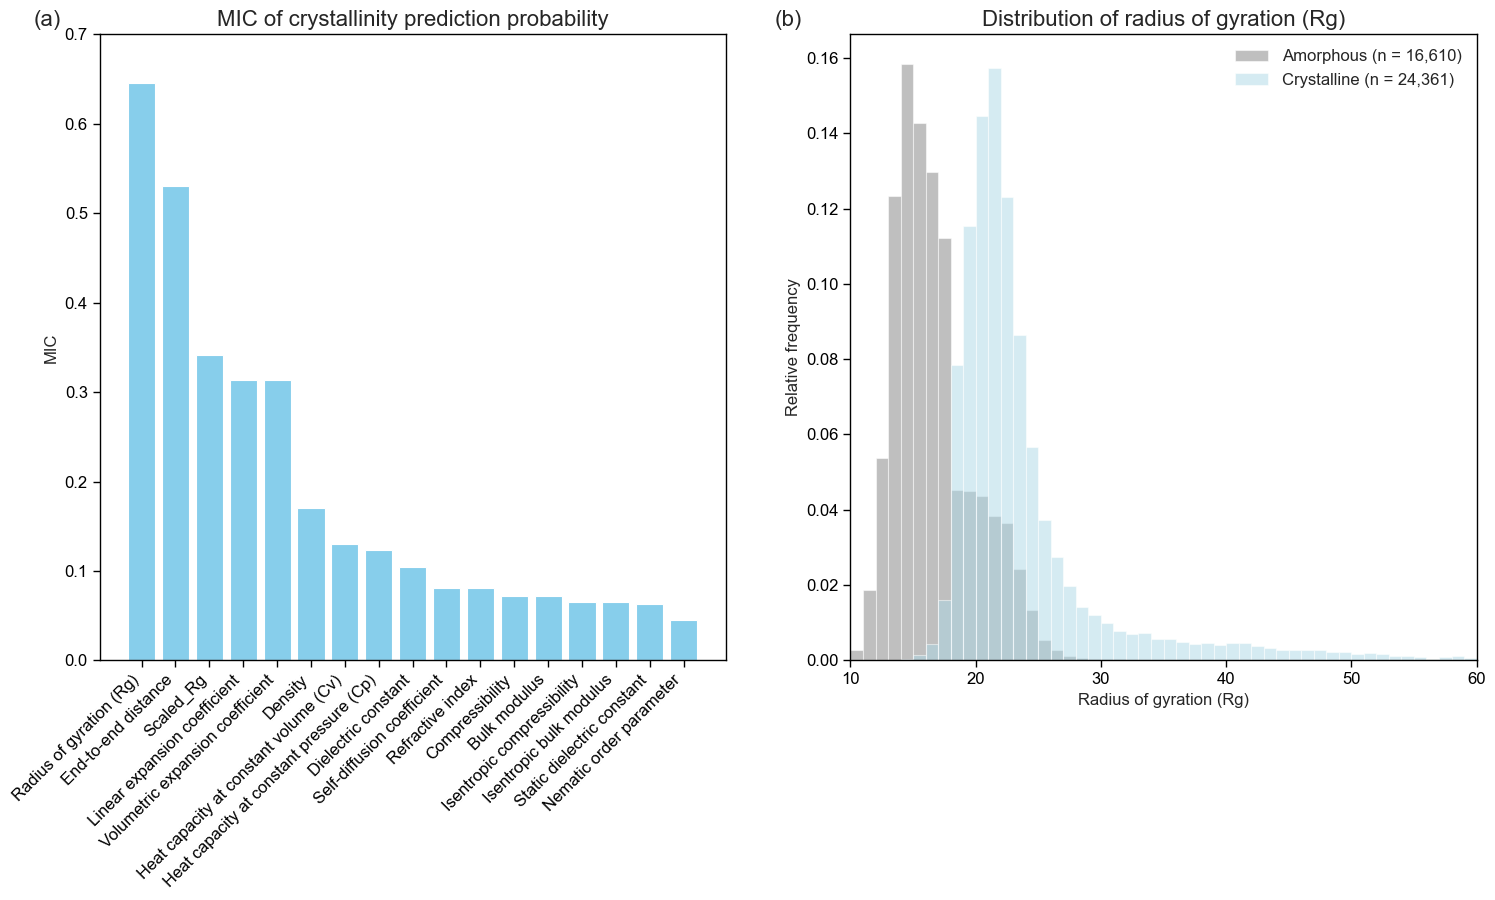

In [46]:
# FIGURE 4: Feature Importance Analysis
mic_csv_path = os.path.join(REPORT_DIR_SUB, "cl_model", "analysis_MIC", "mic_analysis_cl_mic_scores.csv")
fig4 = plotting.generate_figure4_mic_and_rg(
    mic_csv_path=mic_csv_path,
    df_acetone_vPolymer=df_acetone_vPolymer,
    save_dir=REPORT_DIR_MAIN,
    base_fontsize=12
)
plt.show()

---
## 10. Virtual Polymer/Solvent Analysis (Figure 9)

### 10.1 Load Virtual Solvent Data

In [47]:
# Load Polyethylene and Virtual Solvent Data
model_path = os.path.join(MODEL_DIR, "chi_parameter_model.pkl")
final_model = load(model_path)

chi_explanatory_cols = FF_solvent_cols + FF_polymer_cols + radonpy_polymer_cols
exclude_cols = ['n_atom_radonpy_polymer', 'mol_weight_radonpy_polymer']
chi_explanatory_cols = [col for col in chi_explanatory_cols if col not in exclude_cols]

if _PE_SOLVENT_LOADED:
    df_PE_vSolv = _df_pe_solvent.copy()
else:
    df_PE_vSolv = pd.read_csv(DATA_DIR / "vPolymer_vSolvent" / "PE_vsolv_9828_data.csv", index_col=0)

rename_cols = {col: col.replace("_resin", "_polymer") for col in df_PE_vSolv.columns if "_resin" in col}
df_PE_vSolv = df_PE_vSolv.rename(columns=rename_cols)
df_PE_vSolv["chi"] = final_model.predict(df_PE_vSolv[chi_explanatory_cols])

### 10.2 Calculate Chi Parameter for All Experimental Resins

In [48]:
# Calculate Chi Parameter for All Experimental Resins and Virtual Solvents
data = valid_data_cluster[FF_polymer_cols + radonpy_polymer_cols]
info = valid_info_cluster.reindex(data.index)

common_cols = data.columns.intersection(info.columns)
info_reduced = info.drop(columns=common_cols)
df_merged = pd.merge(info_reduced, data, left_index=True, right_index=True)
df_merged = df_merged[["symbol"] + FF_polymer_cols + radonpy_polymer_cols + ["crystalinity_binary"]]
df_merged_unique = df_merged.drop_duplicates(subset="symbol")

df_dict = {}
for _, row in df_merged_unique.iterrows():
    symbol_key = row["symbol"]
    df_temp = df_PE_vSolv.copy()
    cols_to_replace = FF_polymer_cols + radonpy_polymer_cols + ["crystalinity_binary"]
    df_temp.loc[:, cols_to_replace] = row[cols_to_replace].values
    df_temp["chi"] = final_model.predict(df_temp[chi_explanatory_cols])
    df_temp["resistance_pred"] = gbdt_model.predict_proba(df_temp[features])[:, 1]
    df_temp["resistance_pred_binary"] = (df_temp["resistance_pred"] >= 0.9).astype(int)
    df_dict[symbol_key] = df_temp

print(f"Created predictions for {len(df_dict)} polymers")

Created predictions for 27 polymers


### 10.3 Supplementary Figure S6: Chi Parameter Histogram by Polymer

✅ S6 (Group 1: 1-12) saved: /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S6_chi_hist_group1_1to12.svg
✅ S6 (Group 2: 13-27) saved: /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S6_chi_hist_group2_13to27.svg


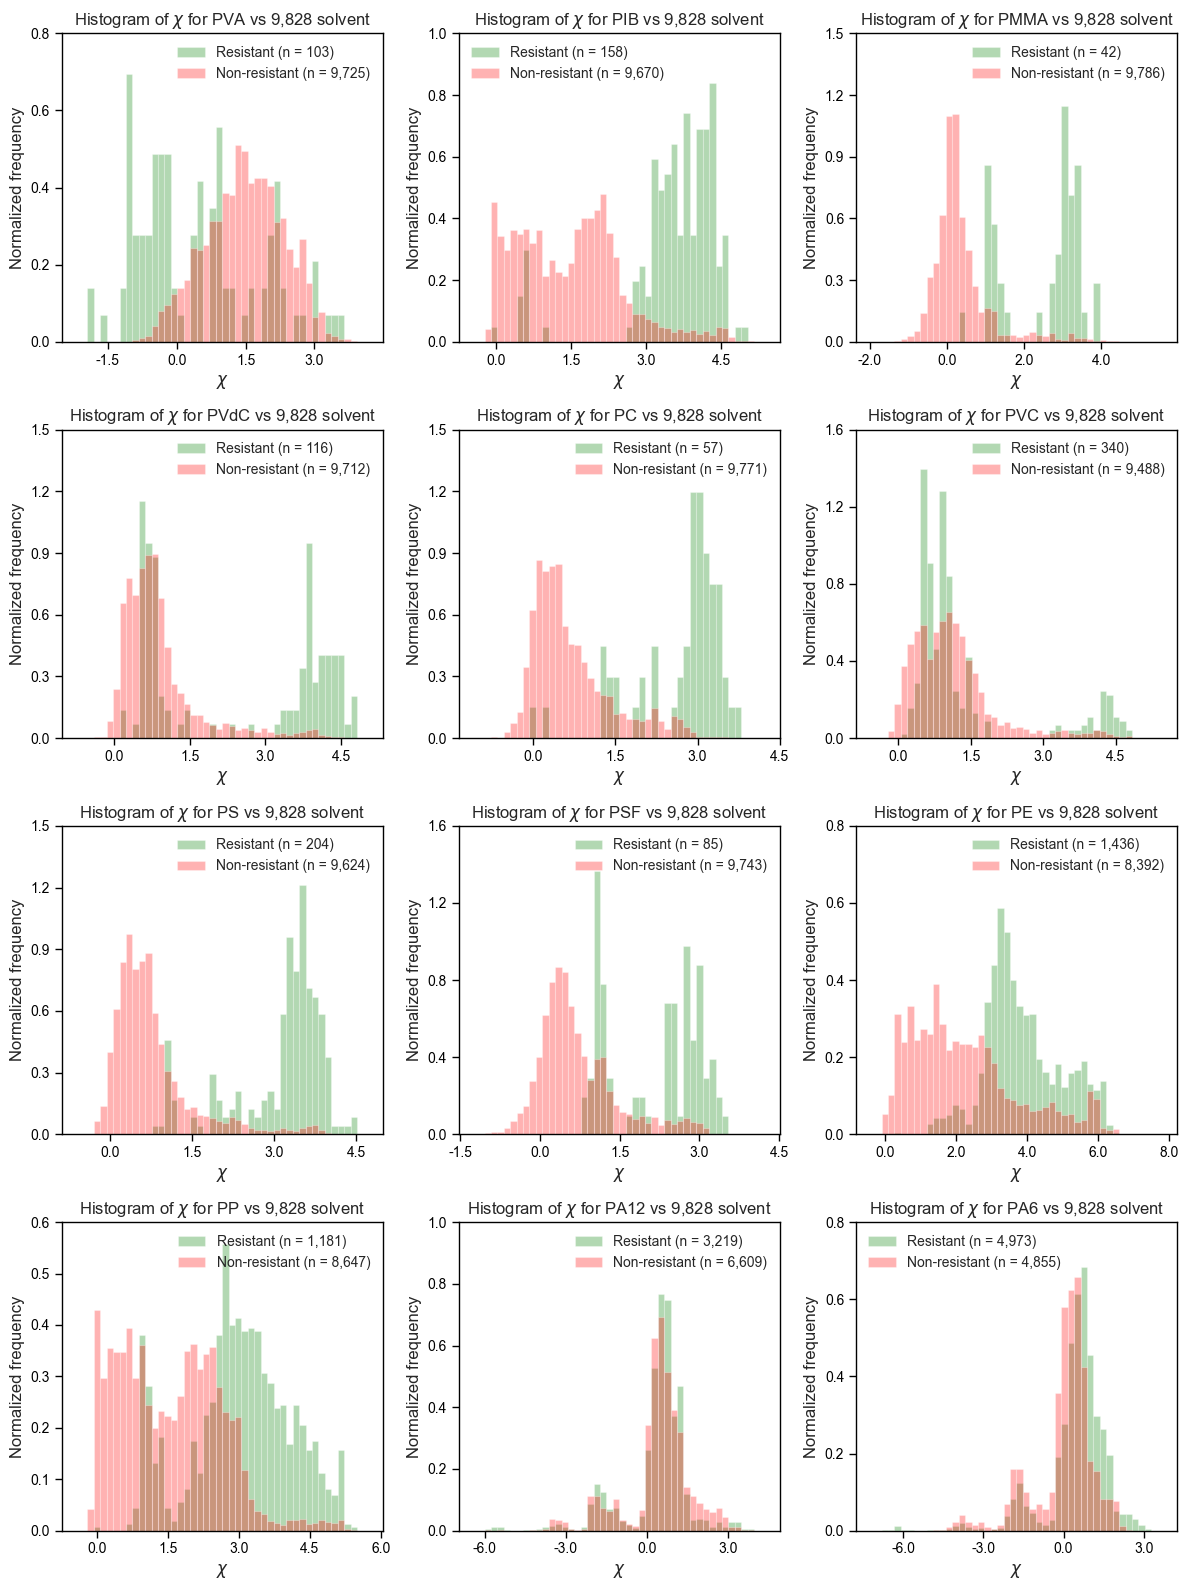

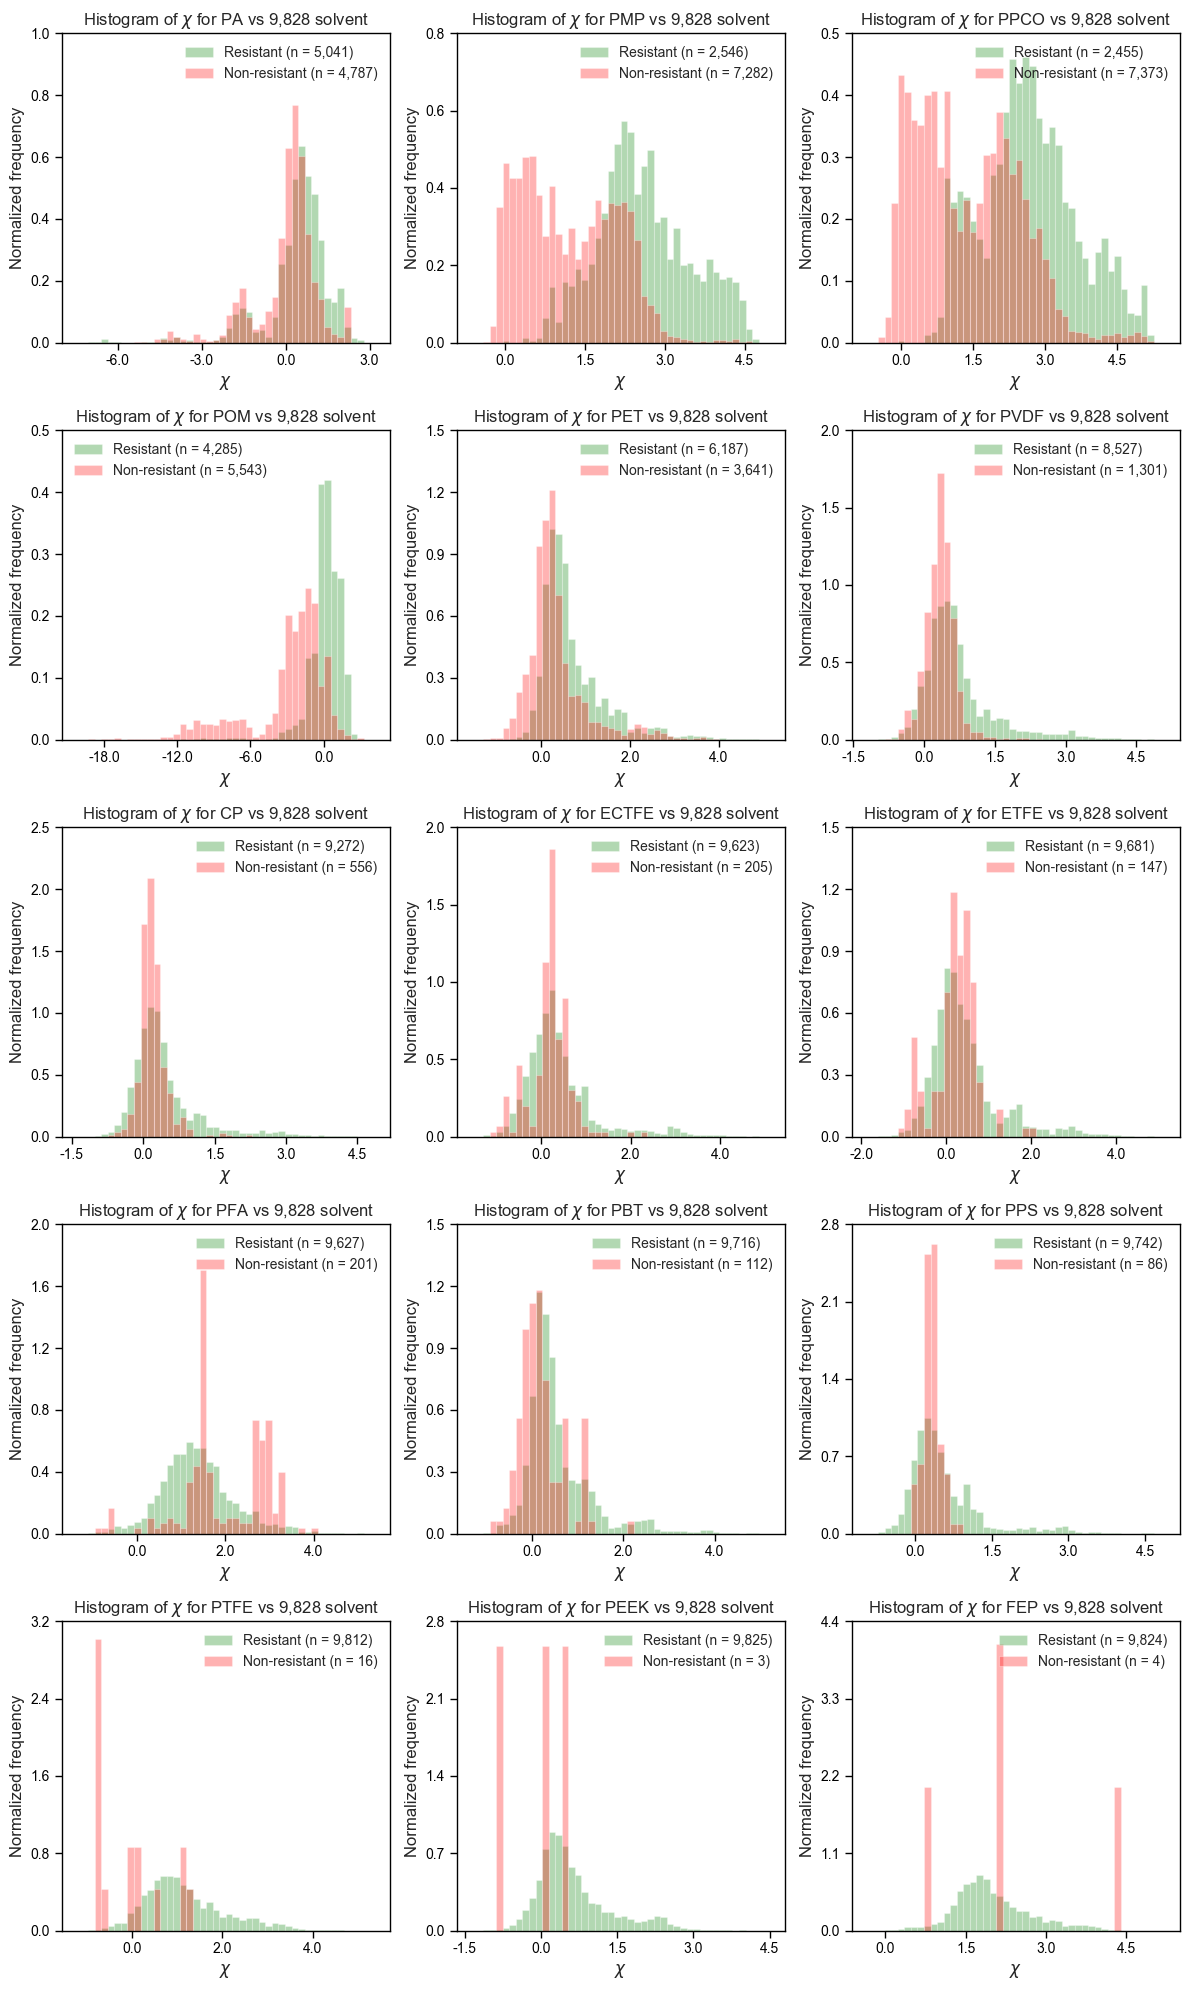

In [49]:
# SUPPLEMENTARY FIGURE S6: Chi Parameter Histogram by Polymer
fig_s6_group1, fig_s6_group2 = plotting.generate_supplementary_s6_chi_histograms(
    df_dict=df_dict,
    symbol_order=symbol_order,
    save_dir=REPORT_DIR_SUB,
    base_fontsize=10,
    chi_col="chi",
    binary_col="resistance_pred_binary"
)
plt.show()

### 10.4 Figure 9: Crystallinity Parameter Analysis

Figure 9 saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Main


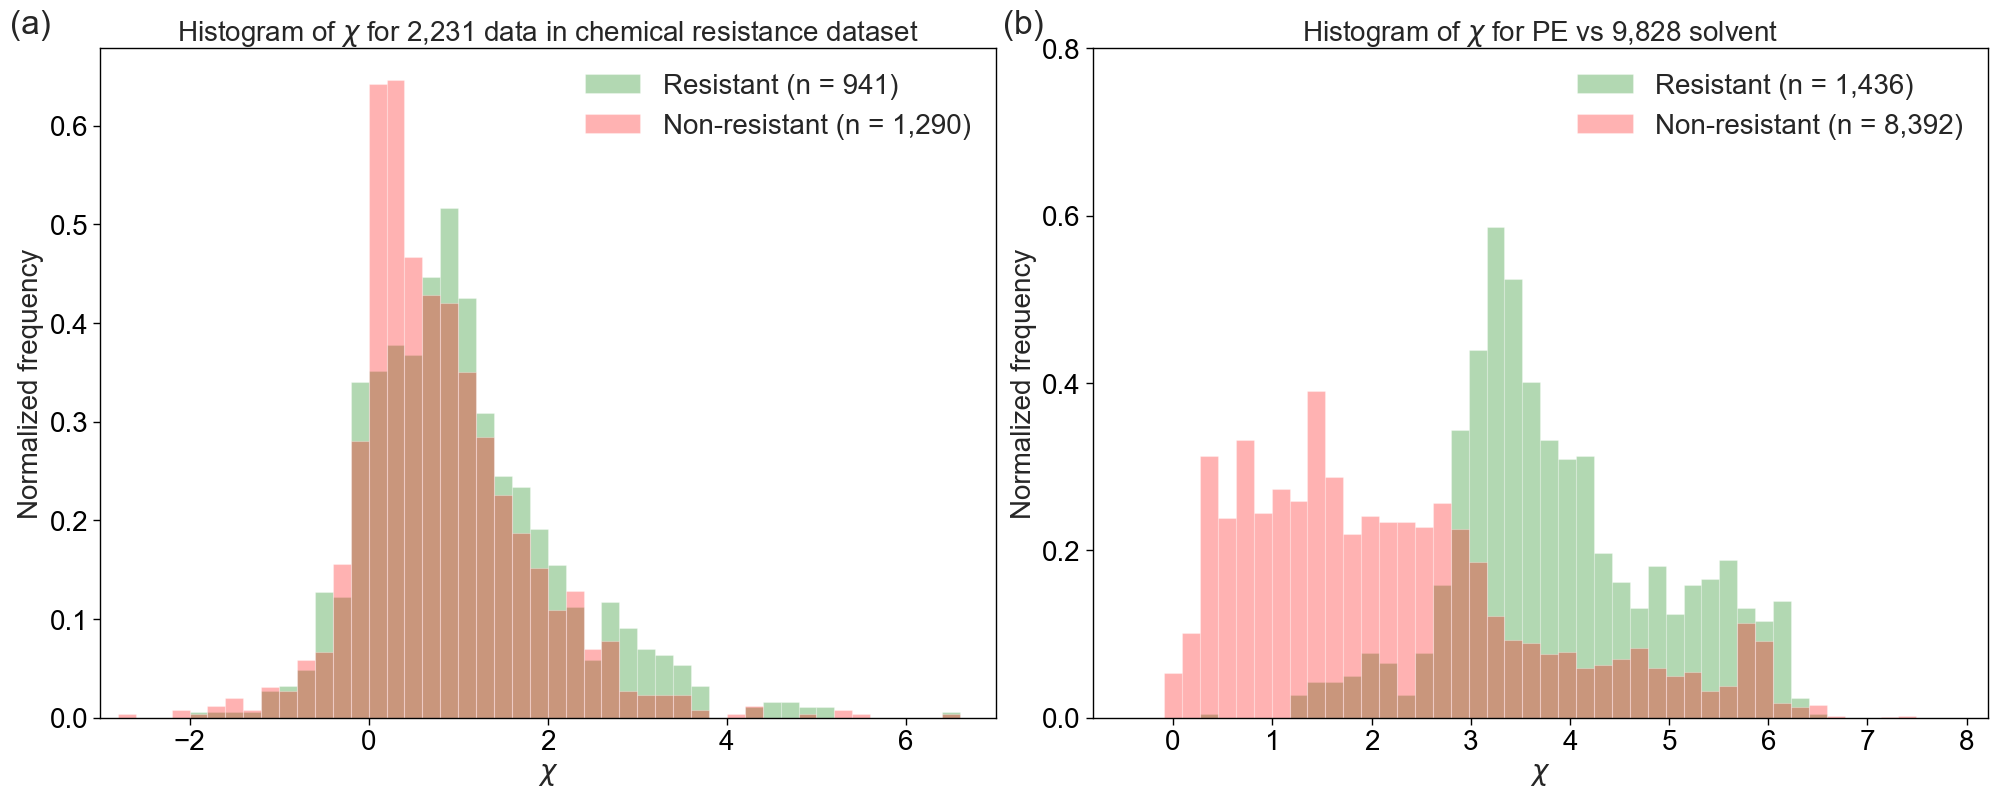

In [50]:
# FIGURE 9: Crystallinity Parameter Analysis
fig9 = plotting.generate_figure9_chi_analysis(
    valid_data_cluster=valid_data_cluster,
    valid_info_cluster=valid_info_cluster,
    gbdt_model=gbdt_model,
    all_features_combinations=all_features_combinations,
    feature_No=feature_No,
    df_dict=df_dict,
    symbol_order=symbol_order,
    save_dir=REPORT_DIR_MAIN,
    base_fontsize=20
)
plt.show()

---
## 11. Force Field Parameter Analysis (Figures 7-8)

### 11.1 MIC Calculation for Figure 7

In [51]:
# Prepare data
df_PE_vSolv.loc[:, "crystalinity_binary"] = 1  # PE is crystalline
df_PE_vSolv["resistance_pred"] = gbdt_model.predict_proba(df_PE_vSolv[features])[:, 1]
df_PE_vSolv["resistance_pred_binary"] = (df_PE_vSolv["resistance_pred"] >= 0.9).astype(int)

X_train = df_PE_vSolv[features]
y_train = df_PE_vSolv["resistance_pred"]

# MIC CALCULATION FOR FIGURE 7
dir_name = os.path.join(REPORT_DIR_SUB, "gbdt_model_result", "analysis_solvent")
os.makedirs(dir_name, exist_ok=True)
filename = "mic_analysis_polar.jpg"
_ = mic.calculate_and_save_mic(gbdt_model, X_train, y_train, dir_name=dir_name, top_n=20, filename=filename, n_jobs=N_JOBS)

📊 Starting MIC calculation...
📈 Number of features to compute: 314
🔄 Computing MIC (35 parallel jobs)...


[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=35)]: Done  15 tasks      | elapsed:    3.1s
[Parallel(n_jobs=35)]: Done  28 tasks      | elapsed:    3.5s
[Parallel(n_jobs=35)]: Done  43 tasks      | elapsed:    5.4s
[Parallel(n_jobs=35)]: Done  58 tasks      | elapsed:    6.6s
[Parallel(n_jobs=35)]: Done  75 tasks      | elapsed:    8.1s
[Parallel(n_jobs=35)]: Done  92 tasks      | elapsed:    9.7s
[Parallel(n_jobs=35)]: Done 111 tasks      | elapsed:   10.9s
[Parallel(n_jobs=35)]: Done 130 tasks      | elapsed:   12.8s
[Parallel(n_jobs=35)]: Done 151 tasks      | elapsed:   13.4s
[Parallel(n_jobs=35)]: Done 172 tasks      | elapsed:   13.6s
[Parallel(n_jobs=35)]: Done 195 tasks      | elapsed:   13.7s
[Parallel(n_jobs=35)]: Done 218 tasks      | elapsed:   13.8s
[Parallel(n_jobs=35)]: Done 243 tasks      | elapsed:   13.9s
[Parallel(n_jobs=35)]: Done 277 out of 314 | elapsed:  

🖼️ Figure saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/gbdt_model_result/analysis_solvent/mic_analysis_polar.jpg
📄 MIC scores saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/gbdt_model_result/analysis_solvent/mic_analysis_polar_mic_scores.csv
✅ MIC calculation completed.


In [52]:
# Load MIC results
dir_name = os.path.join(REPORT_DIR_SUB, "gbdt_model_result", "analysis_solvent")
filename = os.path.join(dir_name, "mic_analysis_polar_mic_scores.csv")
df_vsolvent_MIC = pd.read_csv(filename)

### 11.2 Figure 7: Chi Parameter Analysis

Figure 7c saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Main/fig7c_FF_solvent_MIC.svg and /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Main/fig7c_FF_solvent_MIC.jpg


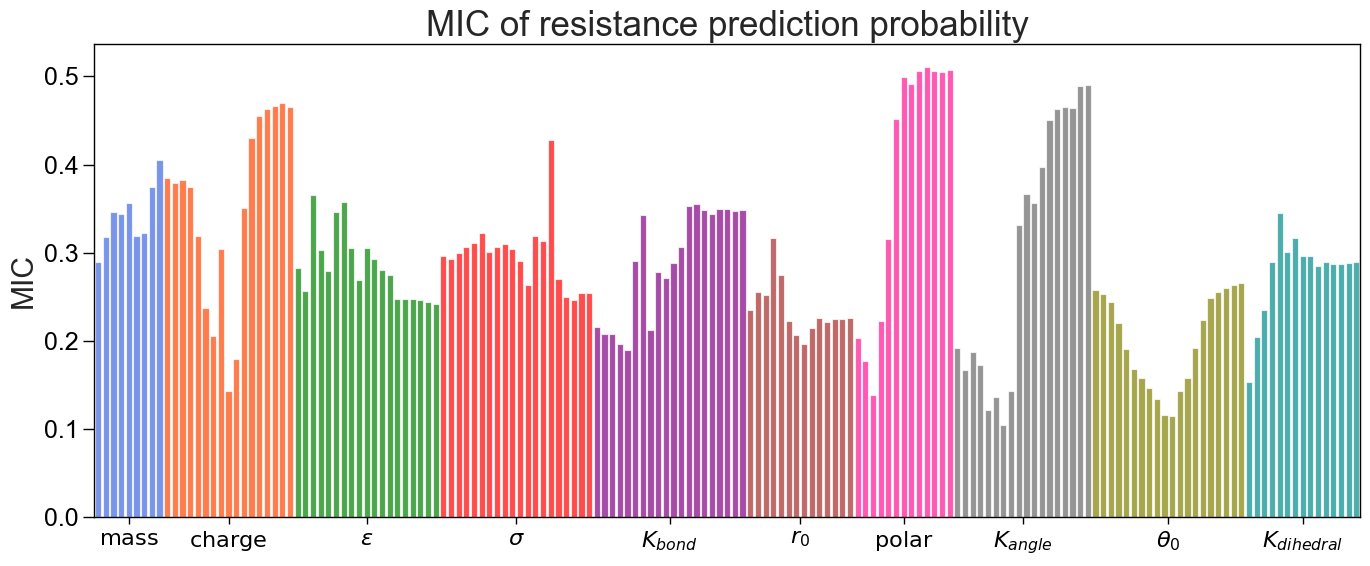

In [53]:
# FIGURE 7c: Chi Parameter Distribution by Polymer Type
fig7c = plotting.generate_figure7c_chi_mic(
    df_vsolvent_MIC=df_vsolvent_MIC,
    FF_solvent_cols=FF_solvent_cols,
    save_dir=REPORT_DIR_MAIN,
    base_font_size=18
)
plt.show()

Figure 7b (plot) saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Main/fig7b_FF_solvent_resistance_pred.svg and /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Main/fig7b_FF_solvent_resistance_pred.jpg


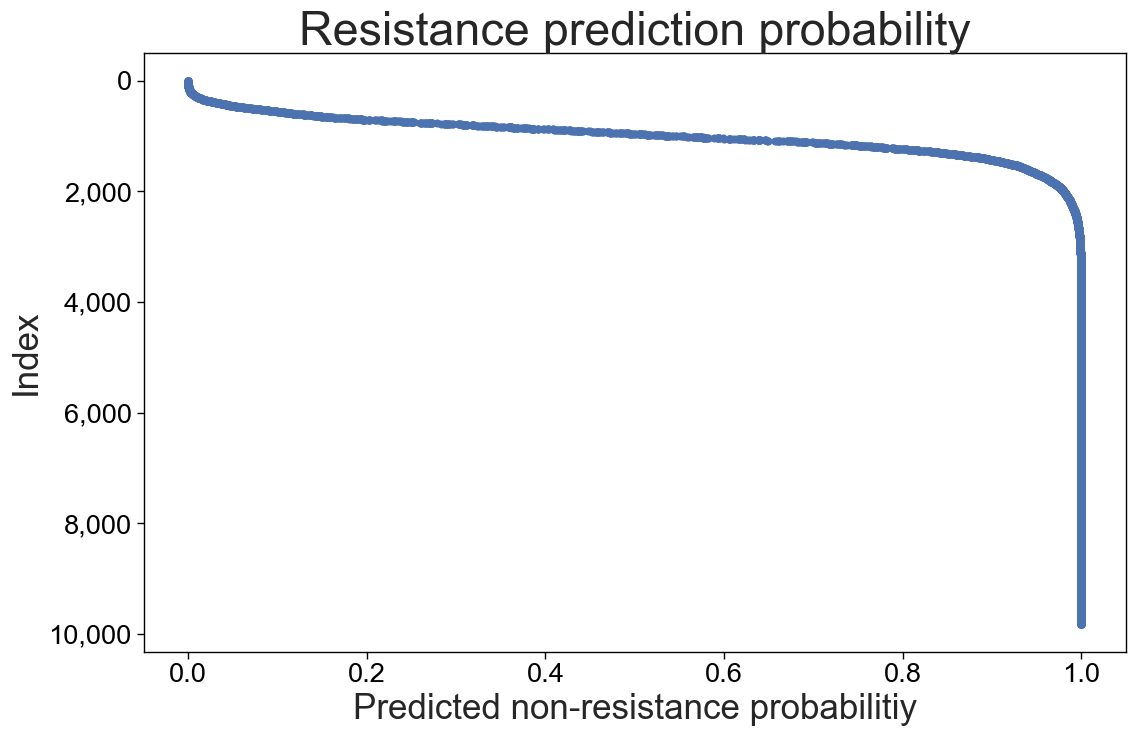

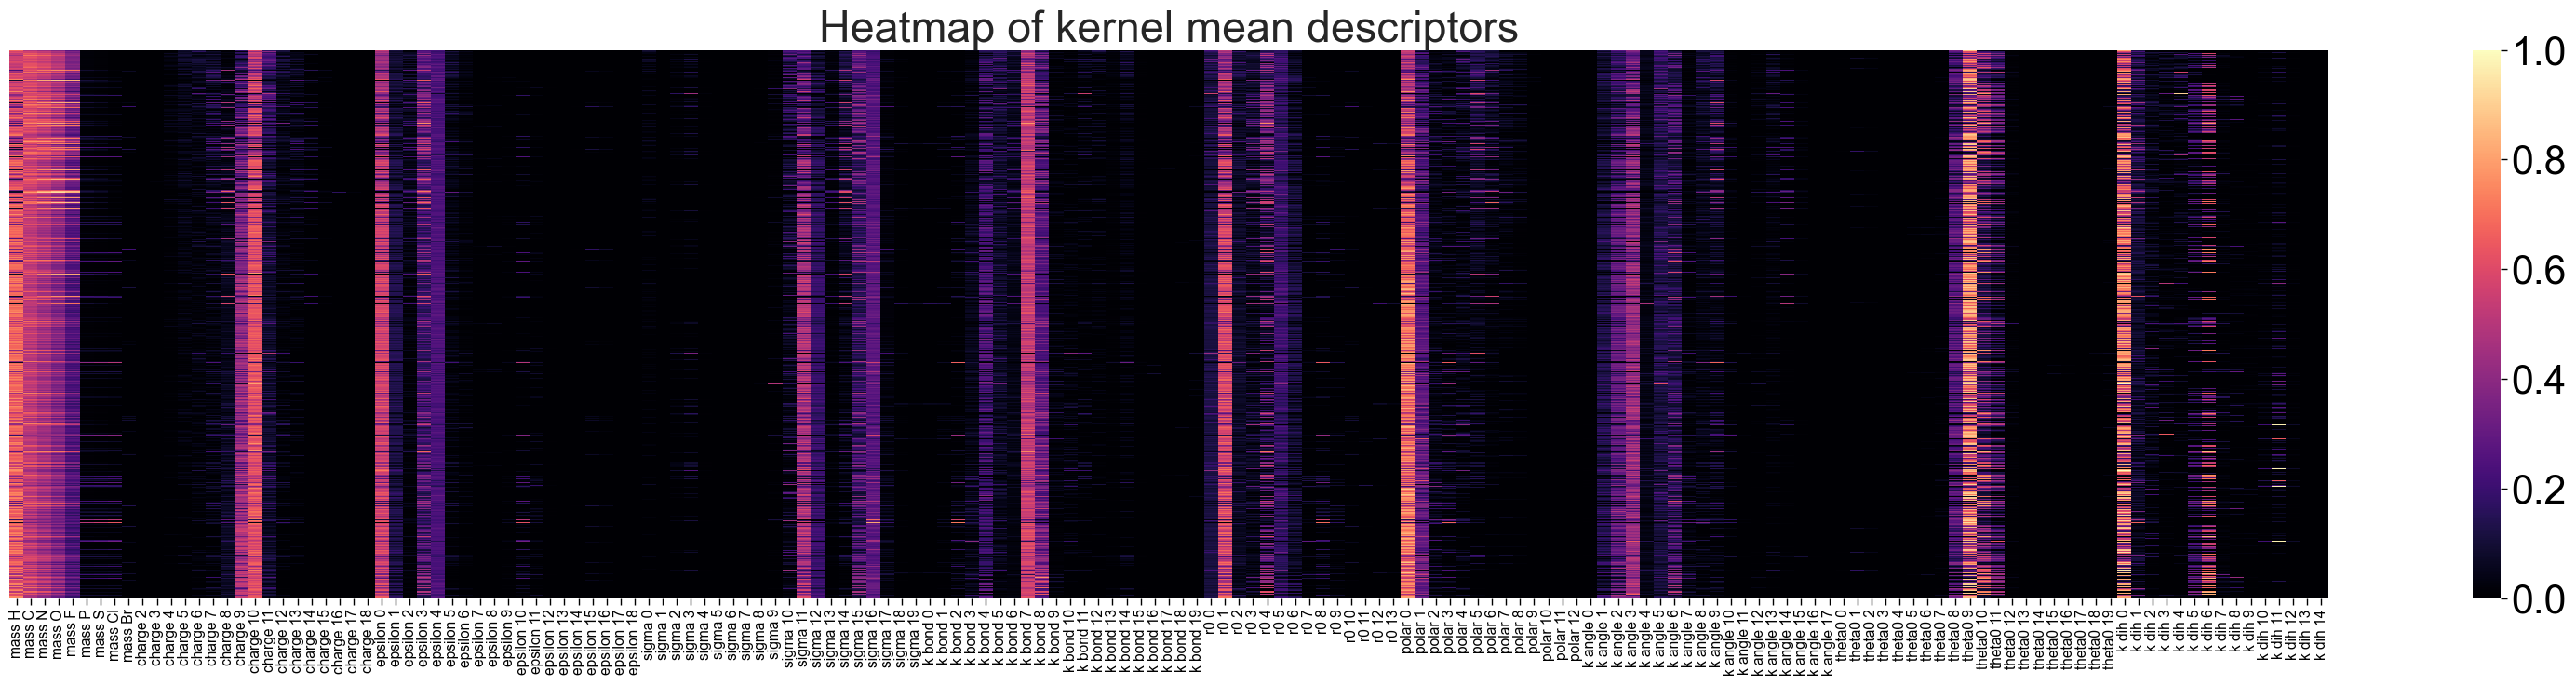

In [54]:
# FIGURE 7a & 7b: Chi Parameter Relationship Analysis
# This cell generates both Figure 7a (heatmap) and Figure 7b (scatter plot)
fig7b_plot, fig7b_heatmap = plotting.generate_figure7b_resistance_analysis(
    df_PE_vSolv=df_PE_vSolv,
    FF_solvent_cols=FF_solvent_cols,
    save_dir=REPORT_DIR_MAIN,
    base_font_size=28
)
plt.show()

Figure 7d saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Main/fig7d_PC_heatmap.svg and /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Main/fig7d_PC_heatmap.jpg


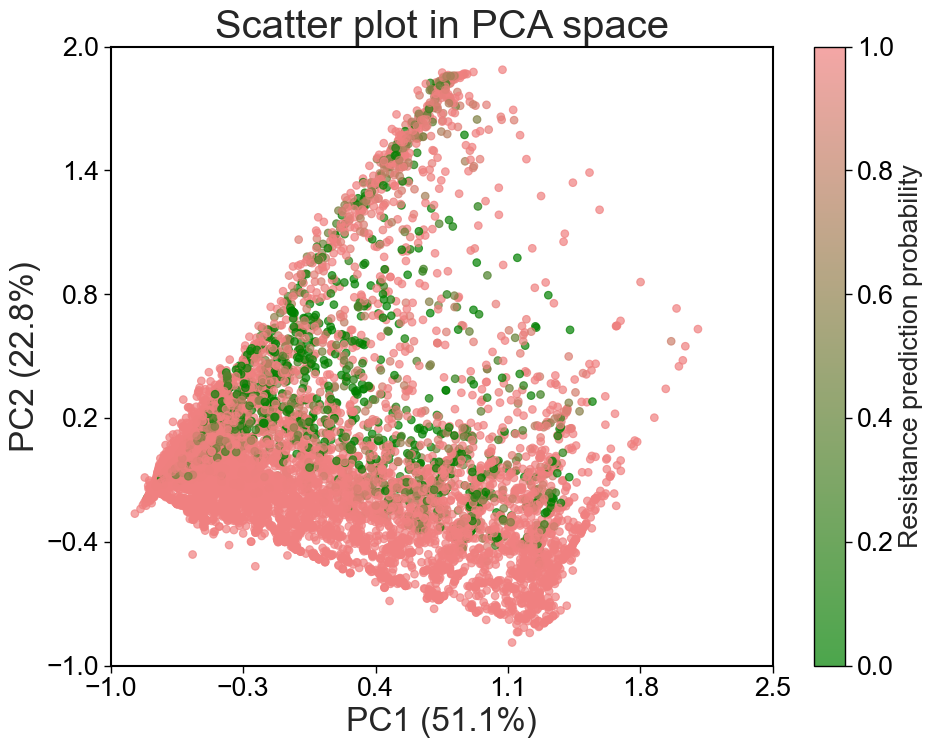

In [55]:
# FIGURE 7d: Chi Parameter Feature Importance (PCA Scatter Plot)
fig7d = plotting.generate_figure7d_pca_scatter(
    df_PE_vSolv=df_PE_vSolv,
    features=FF_solvent_cols,
    save_dir=REPORT_DIR_MAIN,
    base_font_size=24
)
plt.show()

### 11.3 Supplementary Figure S5: Force Field Parameter Analysis

✅ S5 (4-panel) saved: /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S5_subplot_4_Average_with_Std.svg and /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S5_subplot_4_Average_with_Std.jpg
✅ S5 (6-panel) saved: /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S5_subplot_6_Average_with_Std.svg and /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/S5_subplot_6_Average_with_Std.jpg


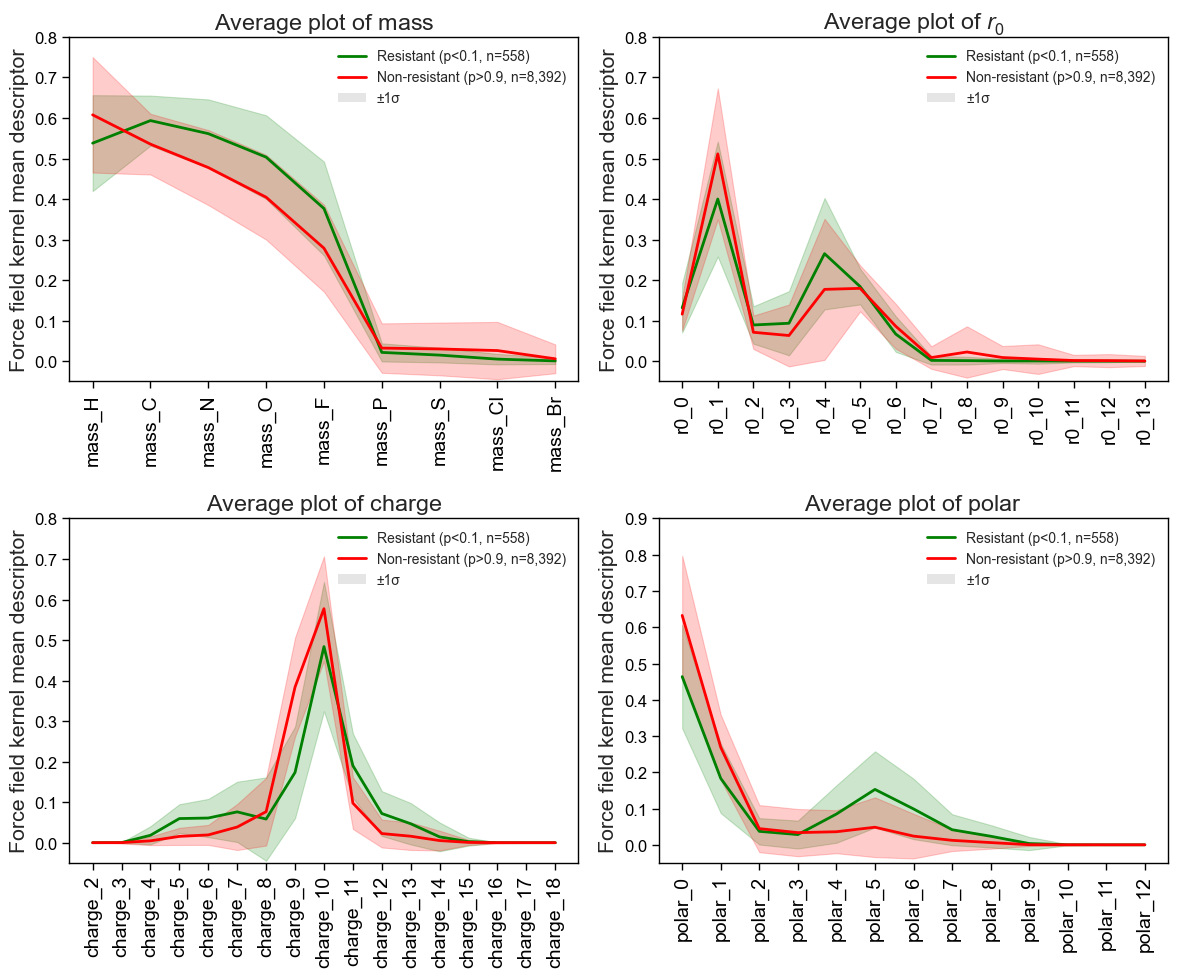

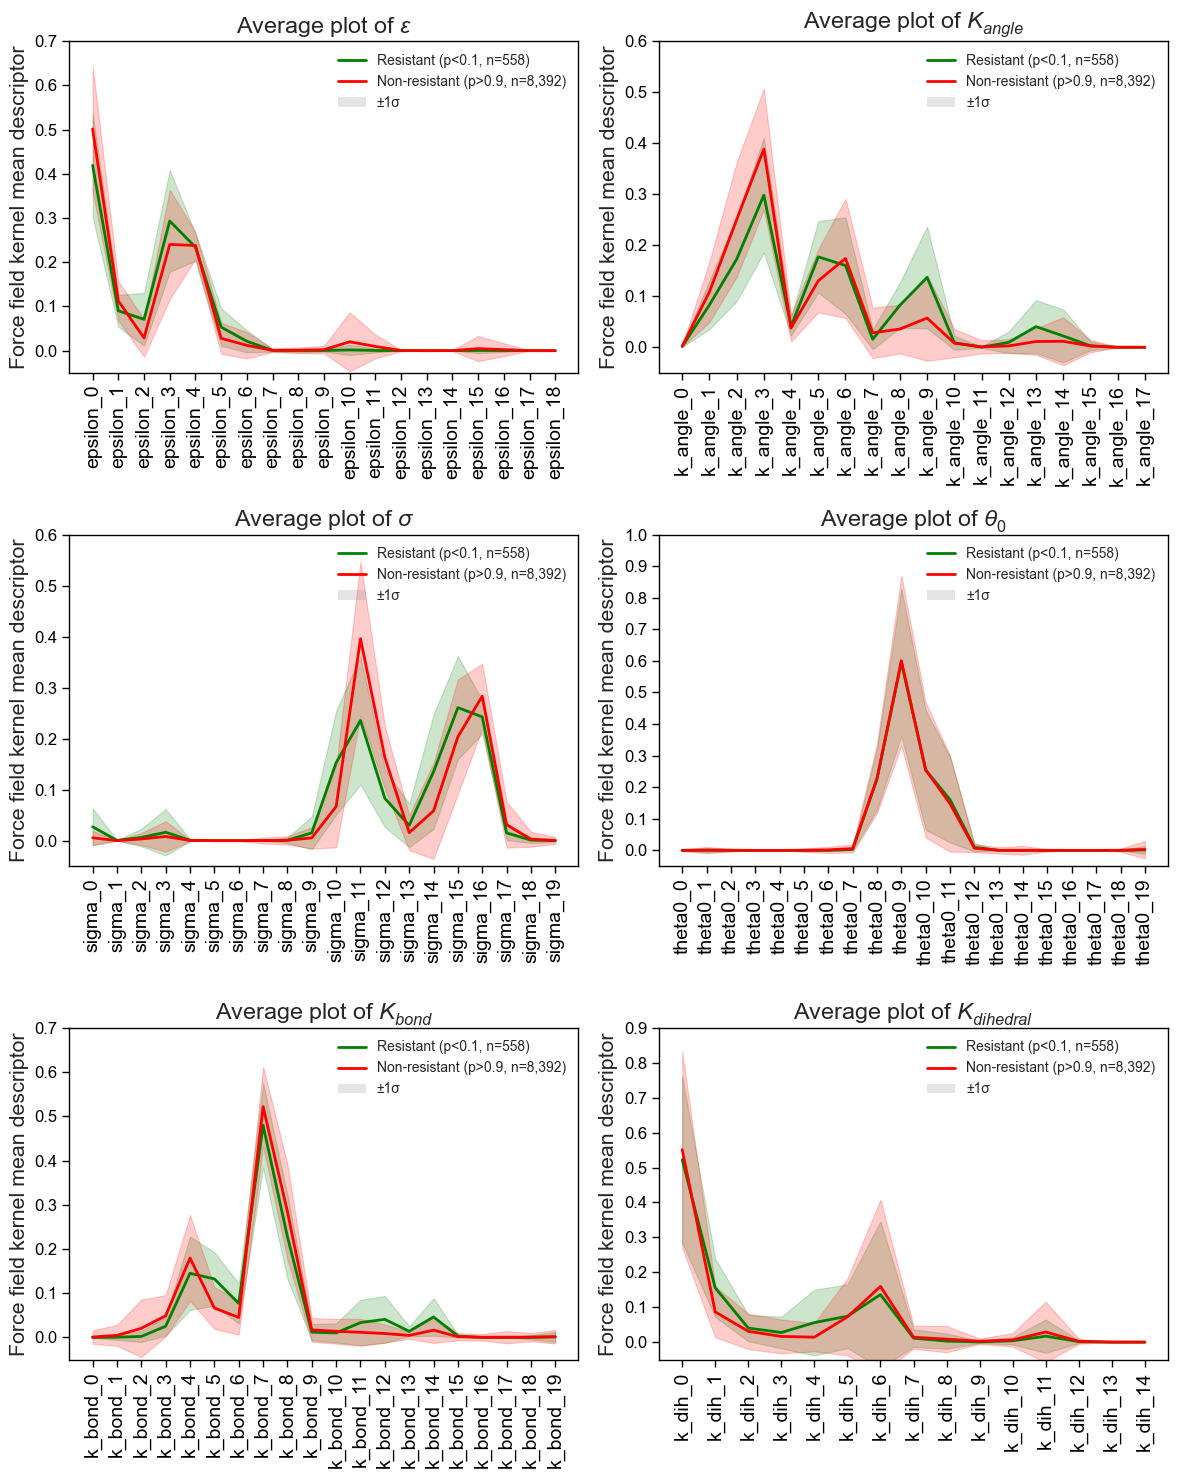

In [56]:
# SUPPLEMENTARY FIGURE S5: Force Field Parameter Average Plots
df_heatmap = df_PE_vSolv.copy()
df_heatmap.sort_values("resistance_pred", inplace=True)
df_vPolymer = df_heatmap.copy()
fig_s5_4panel, fig_s5_6panel = plotting.generate_supplementary_s5_ff_parameter_analysis(
    df_vPolymer=df_vPolymer,
    FF_solvent_cols=FF_solvent_cols,
    save_dir=REPORT_DIR_SUB,
    base_font_size=14,
    Th_high=0.9,
    Th_low=0.1,
    alpha=0.2
)
plt.show()

### 11.4 Figure 8: Comprehensive Model Comparison

Figure 8 saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Main/fig8.jpg, /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Main/fig8.svg, and /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Main/fig8.pdf


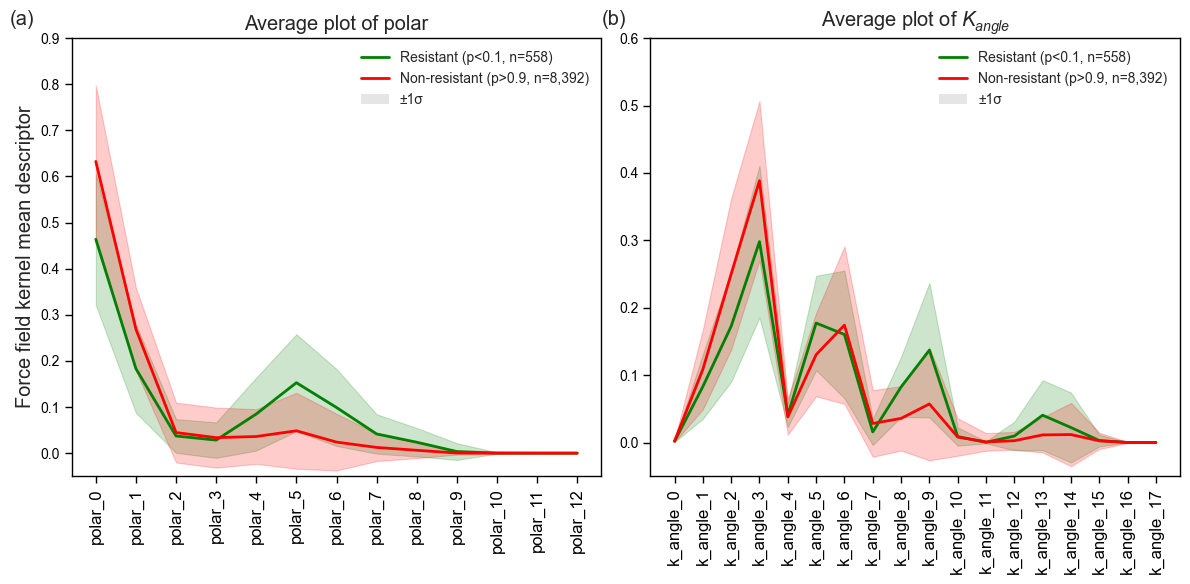

In [57]:
# FIGURE 8: Comprehensive Model Comparison
df_vPolymer = df_heatmap.copy()  # df_heatmap is defined in S5 cell above
fig8 = plotting.generate_figure8_model_comparison(
    df_vPolymer=df_vPolymer,
    FF_solvent_cols=FF_solvent_cols,
    save_dir=REPORT_DIR_MAIN,
    base_font_size=12,
    Th_high=0.9,
    Th_low=0.1
)
plt.show()

---
## 12. Resistance Prediction Results (Figures 5-6)

### 12.1 MIC Calculation for Figure 5

In [58]:
# MIC calculation for Figure 5
print("Calculating MIC for Figure 5 (Resistance prediction)...")
mic_dir = os.path.join(REPORT_DIR_SUB, "gbdt_model_result", "analysis_polymer", "MIC_results")
os.makedirs(mic_dir, exist_ok=True)

features_list = list(all_features_combinations[feature_No])
exclude_cols = ['n_atom_radonpy_polymer', 'mol_weight_radonpy_polymer']
features_list = [col for col in features_list if col not in exclude_cols]

if "chi" not in df_acetone_vPolymer.columns:
    df_acetone_vPolymer["chi"] = final_model.predict(df_acetone_vPolymer[chi_explanatory_cols])

X_vpolymer = df_acetone_vPolymer[features_list].copy()
y_resistance = gbdt_model.predict_proba(X_vpolymer)[:, 1]

print(f"  Dataset size: {len(X_vpolymer)}, Features: {len(features_list)}")

# Calculate MIC for all data
print("  - Calculating MIC for all data...")
filename_all = "MPK_polymer_all_40971_data.jpg"
mic.calculate_and_save_mic(
    gbdt_model, X_vpolymer, pd.Series(y_resistance),
    dir_name=mic_dir, top_n=50, filename=filename_all, n_jobs=N_JOBS
)

# Calculate MIC for crystalline data
mask_crystal = df_acetone_vPolymer["crystalinity_binary"] == 1
X_crystal = X_vpolymer[mask_crystal].copy()
y_crystal = pd.Series(y_resistance[mask_crystal])
print(f"  - Calculating MIC for crystalline data (n={len(X_crystal)})...")
filename_crystal = "MPK_polymer_crystalinity_1_24361_data.jpg"
mic.calculate_and_save_mic(
    gbdt_model, X_crystal, y_crystal,
    dir_name=mic_dir, top_n=50, filename=filename_crystal, n_jobs=N_JOBS
)

# Calculate MIC for amorphous data
mask_amorph = df_acetone_vPolymer["crystalinity_binary"] == 0
X_amorph = X_vpolymer[mask_amorph].copy()
y_amorph = pd.Series(y_resistance[mask_amorph])
print(f"  - Calculating MIC for amorphous data (n={len(X_amorph)})...")
filename_amorph = "MPK_polymer_crystalinity_0_16610_data.jpg"
mic.calculate_and_save_mic(
    gbdt_model, X_amorph, y_amorph,
    dir_name=mic_dir, top_n=50, filename=filename_amorph, n_jobs=N_JOBS
)

print("✅ MIC calculation for Figure 5 completed!")

Calculating MIC for Figure 5 (Resistance prediction)...
  Dataset size: 40971, Features: 314
  - Calculating MIC for all data...
📊 Starting MIC calculation...
📈 Number of features to compute: 314
🔄 Computing MIC (35 parallel jobs)...


[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=35)]: Done  15 tasks      | elapsed:    0.6s
[Parallel(n_jobs=35)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=35)]: Done  43 tasks      | elapsed:    1.1s
[Parallel(n_jobs=35)]: Done  58 tasks      | elapsed:    1.1s
[Parallel(n_jobs=35)]: Done  75 tasks      | elapsed:    1.6s
[Parallel(n_jobs=35)]: Done  92 tasks      | elapsed:    1.7s
[Parallel(n_jobs=35)]: Done 111 tasks      | elapsed:    2.1s
[Parallel(n_jobs=35)]: Done 130 tasks      | elapsed:    2.2s
[Parallel(n_jobs=35)]: Done 151 tasks      | elapsed:    2.7s
[Parallel(n_jobs=35)]: Done 172 tasks      | elapsed:  1.0min
[Parallel(n_jobs=35)]: Done 195 tasks      | elapsed:  1.1min
[Parallel(n_jobs=35)]: Done 218 tasks      | elapsed:  2.2min
[Parallel(n_jobs=35)]: Done 243 tasks      | elapsed:  3.0min
[Parallel(n_jobs=35)]: Done 277 out of 314 | elapsed:  

🖼️ Figure saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/gbdt_model_result/analysis_polymer/MIC_results/MPK_polymer_all_40971_data.jpg
📄 MIC scores saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/gbdt_model_result/analysis_polymer/MIC_results/MPK_polymer_all_40971_data_mic_scores.csv
✅ MIC calculation completed.
  - Calculating MIC for crystalline data (n=24361)...
📊 Starting MIC calculation...
📈 Number of features to compute: 314
🔄 Computing MIC (35 parallel jobs)...


[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=35)]: Done  15 tasks      | elapsed:    0.3s
[Parallel(n_jobs=35)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=35)]: Done  43 tasks      | elapsed:    0.4s
[Parallel(n_jobs=35)]: Done  58 tasks      | elapsed:    0.5s
[Parallel(n_jobs=35)]: Done  75 tasks      | elapsed:    0.6s
[Parallel(n_jobs=35)]: Done  92 tasks      | elapsed:    0.7s
[Parallel(n_jobs=35)]: Done 111 tasks      | elapsed:    0.8s
[Parallel(n_jobs=35)]: Done 130 tasks      | elapsed:    0.9s
[Parallel(n_jobs=35)]: Done 151 tasks      | elapsed:    1.0s
[Parallel(n_jobs=35)]: Done 172 tasks      | elapsed:   20.8s
[Parallel(n_jobs=35)]: Done 195 tasks      | elapsed:   23.2s
[Parallel(n_jobs=35)]: Done 218 tasks      | elapsed:   42.9s
[Parallel(n_jobs=35)]: Done 243 tasks      | elapsed:   59.7s
[Parallel(n_jobs=35)]: Done 277 out of 314 | elapsed:  

🖼️ Figure saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/gbdt_model_result/analysis_polymer/MIC_results/MPK_polymer_crystalinity_1_24361_data.jpg
📄 MIC scores saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/gbdt_model_result/analysis_polymer/MIC_results/MPK_polymer_crystalinity_1_24361_data_mic_scores.csv
✅ MIC calculation completed.
  - Calculating MIC for amorphous data (n=16610)...
📊 Starting MIC calculation...
📈 Number of features to compute: 314
🔄 Computing MIC (35 parallel jobs)...


[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Batch computation too fast (0.12517547607421875s.) Setting batch_size=2.
[Parallel(n_jobs=35)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=35)]: Done  15 tasks      | elapsed:    0.1s
[Parallel(n_jobs=35)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=35)]: Done  43 tasks      | elapsed:    0.2s
[Parallel(n_jobs=35)]: Done  58 tasks      | elapsed:    0.3s
[Parallel(n_jobs=35)]: Done  80 tasks      | elapsed:    0.4s
[Parallel(n_jobs=35)]: Done 114 tasks      | elapsed:    0.5s
[Parallel(n_jobs=35)]: Done 152 tasks      | elapsed:    0.6s
[Parallel(n_jobs=35)]: Batch computation too slow (4.103218626935279s.) Setting batch_size=1.
[Parallel(n_jobs=35)]: Done 190 tasks      | elapsed:   17.4s
[Parallel(n_jobs=35)]: Done 245 out of 314 | elapsed:   28.2s remaining:    7.9s
[Parallel(n_jobs=35)]: Done 309 out of 314 | elapsed:   41.3s remaining:    0.7s
[Parallel(n_j

🖼️ Figure saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/gbdt_model_result/analysis_polymer/MIC_results/MPK_polymer_crystalinity_0_16610_data.jpg
📄 MIC scores saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Sub/gbdt_model_result/analysis_polymer/MIC_results/MPK_polymer_crystalinity_0_16610_data_mic_scores.csv
✅ MIC calculation completed.
✅ MIC calculation for Figure 5 completed!


### 12.2 Figure 5: Resistance Prediction Results

Figure 5 saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Main/fig5.svg, .jpg and .pdf


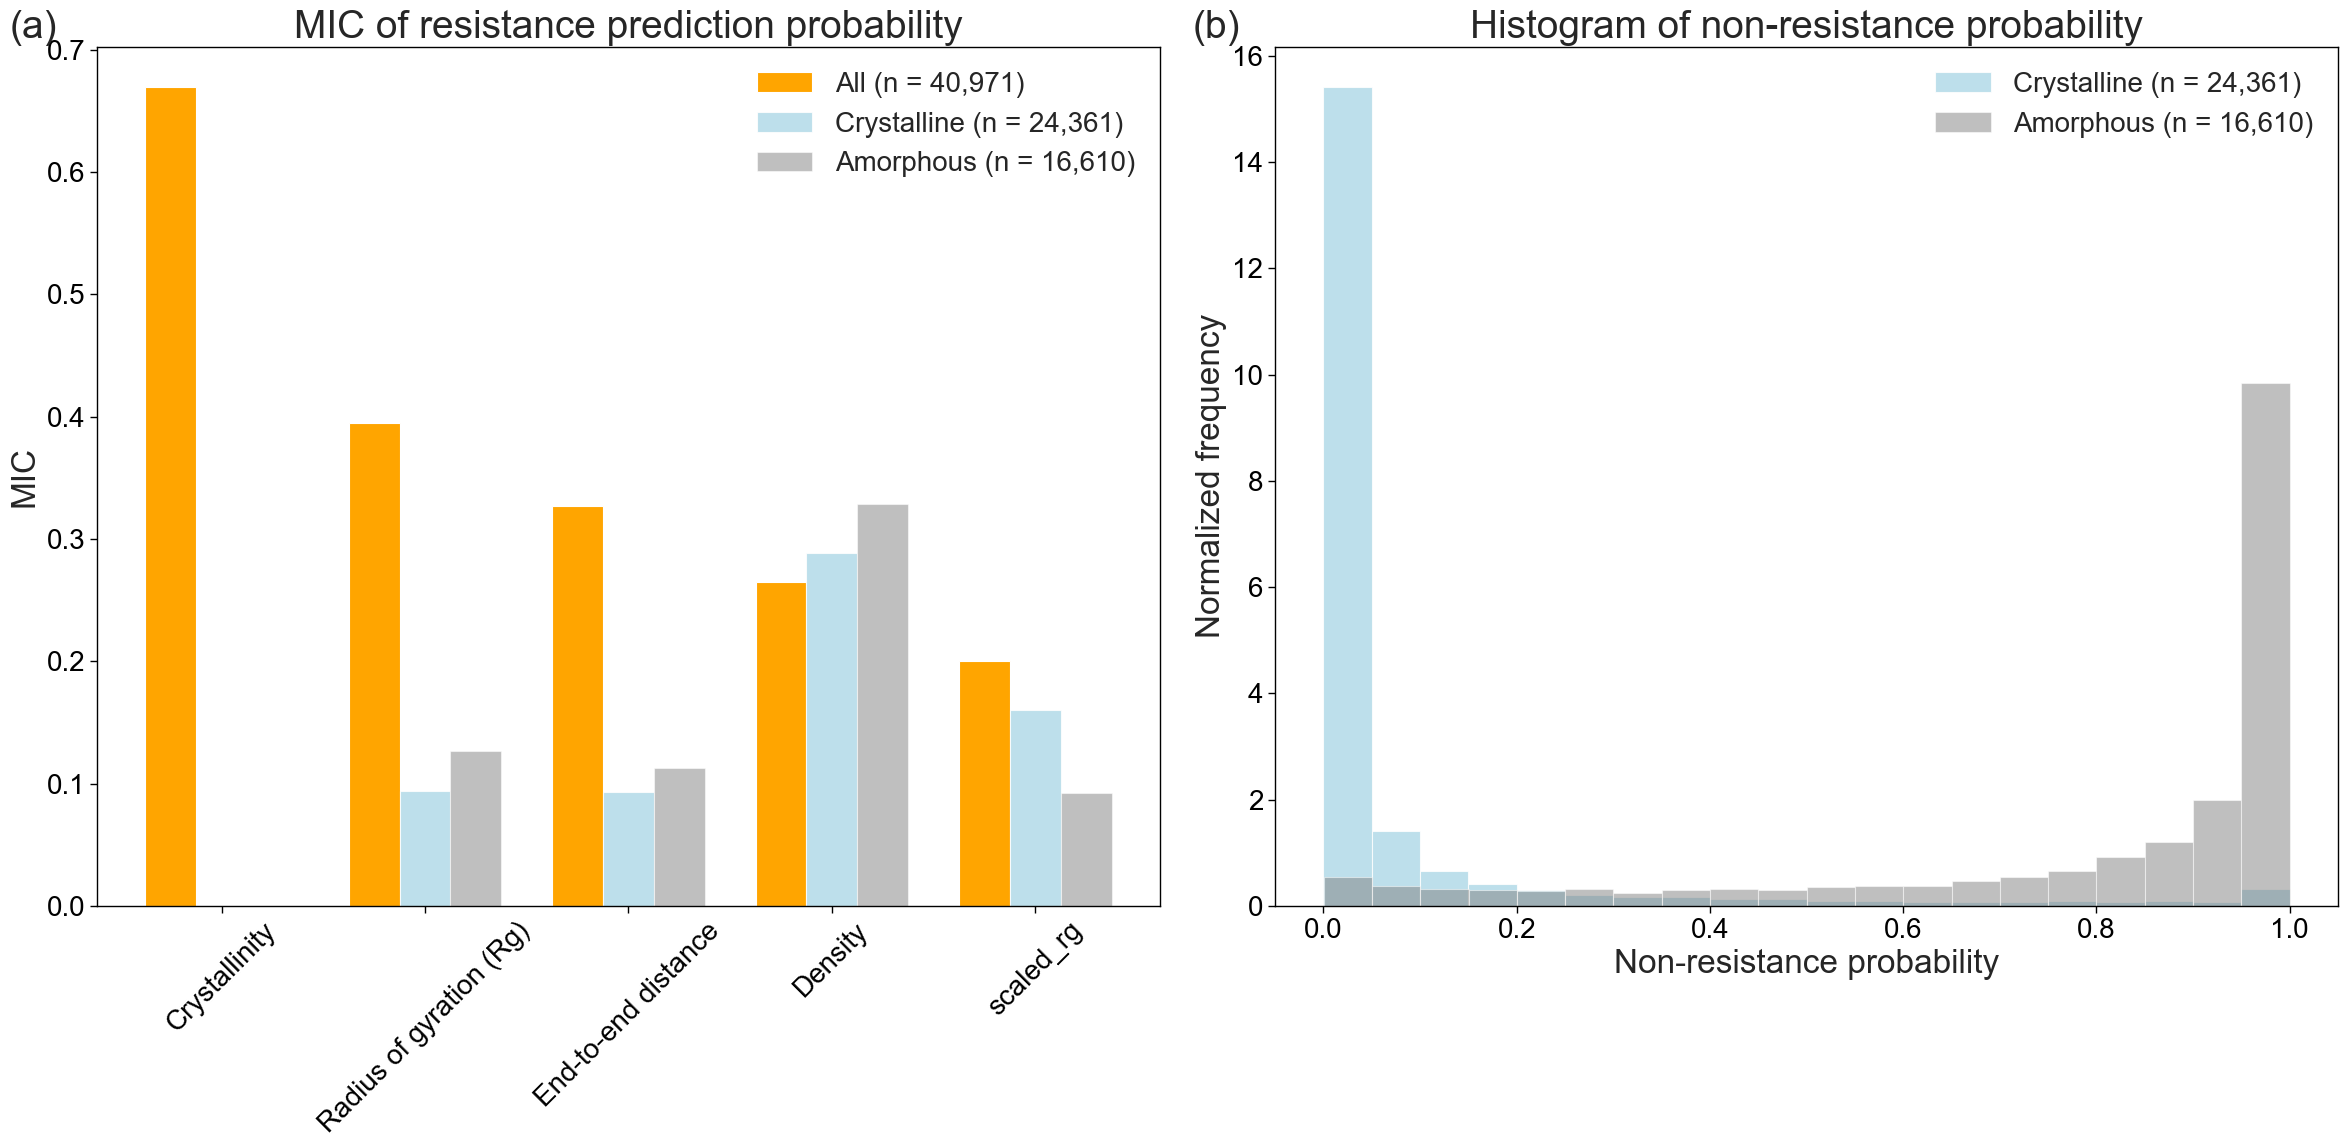

In [59]:
# Load MIC results
filepath_all = os.path.join(REPORT_DIR_SUB, "gbdt_model_result", "analysis_polymer", "MIC_results", "MPK_polymer_all_40971_data_mic_scores.csv")
filepath_crystal = os.path.join(REPORT_DIR_SUB, "gbdt_model_result", "analysis_polymer", "MIC_results", "MPK_polymer_crystalinity_1_24361_data_mic_scores.csv")
filepath_noncrystal = os.path.join(REPORT_DIR_SUB, "gbdt_model_result", "analysis_polymer", "MIC_results", "MPK_polymer_crystalinity_0_16610_data_mic_scores.csv")

def load_and_filter(filepath):
    df = pd.read_csv(filepath)
    df = df[~df['feature'].str.startswith('FF_')].copy()
    df['feature_clean'] = df['feature'].str.replace('_radonpy_polymer', '', regex=False)
    return df

df_all = load_and_filter(filepath_all)
df_crystal = load_and_filter(filepath_crystal)
df_noncrystal = load_and_filter(filepath_noncrystal)

# Prepare prediction data
df_acetone_vPolymer["crystalinity_binary"] = model.predict(df_acetone_vPolymer[CL_explanatory_cols])
df_acetone_vPolymer["crystalinity_prob"] = model.predict_proba(df_acetone_vPolymer[CL_explanatory_cols])[:,1]
df_acetone_vPolymer["chi"] = final_model.predict(df_acetone_vPolymer[chi_explanatory_cols])
df_acetone_vPolymer["resistance_pred"] = gbdt_model.predict_proba(df_acetone_vPolymer[features])[:, 1]

plt.rcParams.update({'font.size': 24})
features_list = list(all_features_combinations[feature_No])
exclude_cols = ['n_atom_radonpy_polymer', 'mol_weight_radonpy_polymer']
features_list = [col for col in features_list if col not in exclude_cols]
train_data = df_acetone_vPolymer.copy()[features_list]
X_train_exp = train_data[features_list]
train_data["resistance_pred"] = gbdt_model.predict_proba(X_train_exp)[:, 1]
CL_label = train_data["crystalinity_binary"]
pred_CL0 = train_data["resistance_pred"][CL_label == 0]
pred_CL1 = train_data["resistance_pred"][CL_label == 1]
n_CL0, n_CL1 = len(pred_CL0), len(pred_CL1)
n_all = n_CL0 + n_CL1

# FIGURE 5: Resistance Prediction Results
fig5 = plotting.generate_figure5_resistance_prediction(
    df_all_mic=df_all,
    df_crystal_mic=df_crystal,
    df_noncrystal_mic=df_noncrystal,
    pred_CL0=pred_CL0,
    pred_CL1=pred_CL1,
    n_all=n_all,
    save_dir=REPORT_DIR_MAIN
)
plt.show()

### 12.3 Figure 6: Crystallinity Effect on Resistance

Figure 6 saved to /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Main/fig6.jpg and /home/jovyan/HD/200_Projects/85th/303_paper_for_polymer/analysis-polymer-chemical-resistance/output/Main/fig6.svg


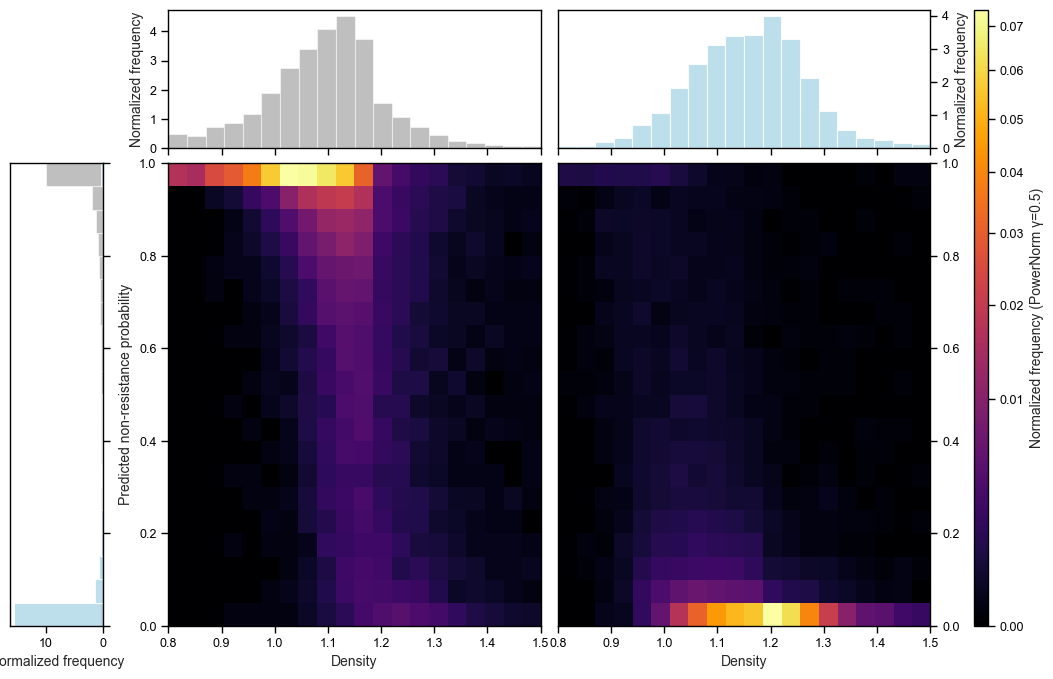

In [60]:
# FIGURE 6: Crystallinity Effect on Resistance
fig6 = plotting.generate_figure6_crystallinity_effect(
    df_acetone_vPolymer=df_acetone_vPolymer,
    x_col="density_radonpy_polymer",
    y_col="resistance_pred",
    save_dir=REPORT_DIR_MAIN,
    base_fontsize=20
)
plt.show()

---
## Summary

This notebook has generated all main and supplementary figures for the chemical resistance prediction paper:

### Main Figures
- **Figure 1**: Chemical Resistance Heatmap
- **Figure 3**: LOGOCV Cross-Validation Results
- **Figure 4**: Feature Importance Analysis (MIC)
- **Figure 5**: Resistance Prediction Results
- **Figure 6**: Crystallinity Effect on Resistance
- **Figure 7a-d**: Chi Parameter Analysis
- **Figure 8**: Comprehensive Model Comparison
- **Figure 9**: Crystallinity Parameter Analysis

### Supplementary Figures
- **S1**: Resistance Binary Distribution by Polymer
- **S2**: Cluster Heatmaps
- **S3**: ROC Curves and Confusion Matrices
- **S4**: Cross-Validation Performance Scatter Plots
- **S5**: Force Field Parameter Analysis
- **S6**: Chi Parameter Histogram by Polymer

All figures are saved in the `reports_paper/` directory.

In [61]:
print("Analysis complete!")

Analysis complete!
